In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import os
import graphviz
import matplotlib.pyplot as plt
import matplotlib
from pylab import figure, show, legend, ylabel
import seaborn as sns
from scipy.interpolate import spline
fig = matplotlib.pyplot.gcf()
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
os.environ["PATH"] += os.pathsep + r"C:\Users\zhaodo\Desktop\graphviz-2.38\release\bin"
%matplotlib inline

## Import dataset and merge into one (item, timeline, activities, product, customer, HR, cost)

In [2]:
#### Read AI China Capris raw data
df = pd.read_excel('ACE AI China 03_20.xlsx', converters = {'Project ID': str,'Account Key':str,'IB Product Key':str,
                                                            'IB Segment Key': str, 'Material Number Key':str,
                                                                   'Customer sold-to Key':str })
df['Project ID'] = df['Project ID'].astype(str)
df['Project ID'] = df['Project ID'].apply(lambda x: x.zfill(10))
df['Account Key'] = df['Account Key'].astype(str)
df['Account Key'] = df['Account Key'].apply(lambda x: x.zfill(10))
df['Material Number Key'] = df['Material Number Key'].astype(str)
df['Material Number Key'] = df['Material Number Key'].apply(lambda x:x.zfill(10))
df['Customer sold-to Key'] = df['Customer sold-to Key'] .astype(str)
df['Customer sold-to Key'] = df['Customer sold-to Key'].apply(lambda x:x.zfill(10))
#df

In [3]:
#### remove strange rows
#### 1. remove rows with 0 sales year 1
df = df.loc[df['Sales Year1']!=0]
#### 2. remove account key == nan
df = df.loc[df['Account Key']!='0000000nan']
#### 3. material key empty
df = df.loc[df['Material Number Key']!='0000000nan']
#### 4. remove both sales Y1 and sales Y2 smaller than 100 EURO
df = df.loc[~((df['Sales Annualized']<=100)&(df['Sales Year1']<=100))]
#### 5. remove most duplicated projects
duplicate = pd.DataFrame(df['Project ID'].value_counts())
duplicate = duplicate.loc[duplicate['Project ID']>=5].reset_index()
df = df.loc[~df['Project ID'].isin(duplicate['index'])]
#### 6. select only completed and cancelled
df = df.loc[df['Project Status'].isin(['Completed','Cancelled','Active'])]
#### 7. select closing year 2013, 2014, 2015 2016 2017 2018
df = df.loc[df['Exp. Closing Date Year'].isin(['2014','2015','2016','2017','2018','2019','2020'])]
#### 8.remove Sales Annualized_cor <= 100; new column: Sales Annualized_cor - when sales y2 = 0 (one-off), take sales y1 as annualized.
df['Sales Annualized_cor'] = np.where(df['Sales Annualized']==0, df['Sales Year1'], df['Sales Annualized'])
df = df.loc[~(df['Sales Annualized_cor']<=100)]
#### 9.remove Unit Price larger than 2000
df = df.loc[df['Unit Price']<2000] # most of the wierd rows are created by Michael Zhang/ 张英, from AIF
#df

In [4]:
#### read timeline aging data
df2 = pd.read_excel("Timeline_Aging Report.xlsx", converters = {'Project ID':str})

#### merge timeline aging into main df
df = pd.merge(df,df2, on = "Project ID", how = "inner")
#df

In [5]:
#### read activity data
df3 = pd.read_excel("Activity Reporting.xlsx",converters = {"Activity ID":str, "Account Key":str})

account_activities = df3['Activity ID'].groupby(df3['Account Key']).count()
account_activities = pd.DataFrame(account_activities).rename(index = str, 
                                                             columns = {'Account Key':'Account Key', 
                                                                        "Activity ID":"Numbers of Activities"})
account_activities = account_activities.reset_index()

#### merge acount activities into main df
df = pd.merge(df,account_activities, on = "Account Key", how = "left")
#df

In [6]:
#### import prodcuct info
df4 = pd.read_excel('Product info.xlsx', converters = {'PRDA - IDH Nr':str})
df4['PRDA - IDH Nr'] = df4['PRDA - IDH Nr'].apply(lambda x: x.zfill(10))
df = pd.merge(df, df4, left_on = 'Material Number Key', right_on = 'PRDA - IDH Nr', how = 'left')
#df = df.drop(['PRDA - IDH Nr', 'Unnamed: 10','Unnamed: 11','Unnamed: 12','Unnamed: 13','Unnamed: 14','Unnamed: 15',
#              'Unnamed: 16','Unnamed: 17','Unnamed: 18','Unnamed: 19', 'Unnamed: 20','Unnamed: 21','Unnamed: 22',
#              'Unnamed: 23','Unnamed: 24','Unnamed: 25','Unnamed: 26','Unnamed: 27','Unnamed: 28',], axis = 1)
#df

In [7]:
#### import customer segmentation
#### remap by sold to

df6 = pd.read_excel('AI Segmentation.xlsx', converters = {'Customer (KNA1-KUNNR)': str,'Sales Org. (KNVV-VKORG)':str})
df6['Customer (KNA1-KUNNR)'] = df6['Customer (KNA1-KUNNR)'].astype(str)
df6['Customer (KNA1-KUNNR)'] = df6['Customer (KNA1-KUNNR)'].apply(lambda x: x.zfill(10))
df6 = df6.drop_duplicates(subset = 'Customer (KNA1-KUNNR)', keep = 'last')
df7 = pd.merge(df, df6, left_on = 'Account Key', right_on = 'Customer (KNA1-KUNNR)', how = "left")
df9 = df7.loc[~df7['Customer (KNA1-KUNNR)'].isnull()]
df8 = df.loc[df7['Customer (KNA1-KUNNR)'].isnull()]
df8 = pd.merge(df8, df6, left_on = 'Customer sold-to Key', right_on ='Customer (KNA1-KUNNR)', how = "left" )
df = pd.concat([df9,df8],axis = 0)

In [8]:
#### import HR data
df7 = pd.read_excel('AI China sales.xlsx')

df7['Last name'] = df7['Last name'].str.lower()
df7['First name'] = df7['First name'].str.lower()
df['Employee Responsible'] = df['Employee Responsible'].str.lower()
first_names = pd.DataFrame(df7['First name'].str.split(' ',1).tolist(),
                          columns = ['English_name','Chinese_name'])

frame = [df7, first_names]
df7 = pd.concat(frame, axis = 1)
df7['name1'] = df7['English_name']+ ' ' +df7['Last name']
df7['name2'] = df7['First name']+ ' ' +df7['Last name']
df7['name3'] = df7['Chinese_name']+ ' ' + df7['Last name']

df['Employee Responsible'] = df['Employee Responsible'].replace({'hong-jun gu':'hongjun gu', 'martinjianyuan xie':'martin jianyuan xie',
                                                            'sun-woo ha': 'roy sun woo ha', 'roger chan':'roger wenbo chen',
                                                            'qing fang': 'kimi qin fang','cheng.l liu':'cheng liu',
                                                                 'yuki zhong':'rick qiyu zhong'})
df['Employee Responsible'] = df['Employee Responsible'].str.replace('\(exit\)','')

sales1 = df7.drop(['name2','name3'], axis = 1)
sales1 = sales1.rename(columns = {'name1':'sales_name'})
sales2 = df7.drop(['name1','name3'], axis = 1)
sales3 = df7.drop(['name2','name1'], axis = 1)
sales2 = sales2.rename(columns = {'name2':'sales_name'})
sales3 = sales3.rename(columns = {'name3':'sales_name'})
frame = [sales1, sales2, sales3]

sales = pd.concat(frame, axis = 0)
sales = sales.drop_duplicates('sales_name', keep = 'first')
df = pd.merge(df, sales, left_on = 'Employee Responsible', right_on = 'sales_name', how = "left")
df = df.drop(['English_name', 'Chinese_name','Last name','First name'], axis = 1)

In [9]:
#### import product cost data
prod1 = pd.read_excel("AI_unit product cost_2015-2016YTD.xlsx", converters = {'Product IDH#':str}) 
# 2015 - 2016 cost
prod2 = pd.read_excel("AI_unit product cost_2017-2019YTD.xlsx", converters = {'Product IDH#':str})
# 2017 - 2019 cost

prod1['Product IDH#'] = prod1['Product IDH#'].astype(str)
prod1['Product IDH#'] = prod1['Product IDH#'].apply(lambda x: x.zfill(10))
prod2['Product IDH#'] = prod2['Product IDH#'].astype(str)
prod2['Product IDH#'] = prod2['Product IDH#'].apply(lambda x: x.zfill(10))

prod = pd.merge(prod1, prod2, on = ['Country', 'Product IDH#','Product Name', 'Curr'], how = "outer")
prod_cn = prod.loc[prod['Country'].isin(['PR of China'])]
df = pd.merge(df, prod_cn, left_on = "Material Number Key", right_on = 'Product IDH#', how = "left")

## Data Cleaning 

In [10]:
df['Project Status Cor'] = df['Phase'].map({'(100) Batch production':"Completed",'(30) Test initiated':'Cancelled',
                                           '(60) Approved by customer':'Cancelled',
                                            '(90) First delivery in purchase order':'Completed',
                                           '(10) Discussed with customer':'Cancelled',
                                           '(05) Potential': 'Cancelled'})

In [11]:
df['Project Status Cor1'] = df['Phase'].map({'(100) Batch production':"Completed",'(30) Test initiated':'Cancelled',
                                           '(60) Approved by customer':'Cancelled',
                                            '(90) First delivery in purchase order':'Cancelled',
                                           '(10) Discussed with customer':'Cancelled',
                                           '(05) Potential': 'Cancelled'})

In [12]:
#df['Project Status Cor1'] = df['Project Status Cor1'].map({'Completed':1, "Cancelled":0})

In [13]:
print(df['Project Status'].value_counts())

Cancelled    9836
Completed    4963
Active       2149
Name: Project Status, dtype: int64


In [14]:
df['Segmentation (KNA1-KATR2)'].value_counts()
print(df['Segmentation (KNA1-KATR2)'].isnull().sum())

4402


In [15]:
df['Segmentation (KNA1-KATR2)'] = df['Segmentation (KNA1-KATR2)'].fillna('G1')

In [16]:
df['Account_City_Lower'] = df['Account City'].str.lower()

In [17]:
target_values = {'Guang Dong':["chaozhou","dongguan","enping","foshan","gaozhou","guangzhou","heshan","heyuan","huazhou",
                               "huizhou","jiangmen","jieyang","kaiping","lechang","leizhou","lianjiang","lianzhou",
                               "lufeng","luoding","maoming","meizhou","nanxiong","puning","qingyuan","shantou","shanwei",
                               "shaoguan","shenzhen","sihui","taishan","wuchuan","xingning","xinyi","yangchun","yangjiang",
                               "yingde","yunfu","zhanjiang","zhaoqing","zhongshan","zhuhai","guangdong",'panyu','dongguang',
                               'houjie town, dongguan','zengcheng','佛山','东莞','dg'],
                 'An Hui':["anqing","bengbu","bozhou","chaohu","chizhou","chuzhou","fuyang","hefei","huaibei","huainan",
                           "huangshan","jieshou","lu'an","ma'anshan","mingguang","ningguo","suzhou","tianchang",
                           "tongcheng","tongling","wuhu","xuancheng","anhui",'maanshan'],
                'Fu Jian':["changle","fu'an","fuding","fuqing","fuzhou","jian'ou","jinjiang","longhai","longyan","nan'an",
                           "nanping","ningde","putian","quanzhou","sanming","shaowu","shishi","wuyishan","xiamen","yong'an","zhangzhou",
                           "zhangping","fujian",'lianjiang county','xiameng','quanhou','quanzhoushi','xiamenshi','putian city',
                          'nanan'],
                'Gan Su': ["baiyin","dingxi","dunhuang","hezuo","jiayuguan","jinchang","jiuquan","lanzhou","linxia","longnan",
                           "pingliang","qingyang","tianshui","wuwei","yumen","zhangye","gansu"],               
                'Guang Xi': ["baise","beihai","beiliu","cenxi","chongzuo","dongxing","fangchenggang","guigang","guilin","guiping",
                             "hechi","heshan","hezhou","laibin","liuzhou","nanning","pingxiang","qinzhou","wuzhou",
                             "yulin, guangxi","yizhou","guangxi"],
                'Gui Zhou': ["anshun","bijie","chishui","duyun","fuquan","guiyang","kaili","liupanshui","qingzhen","renhuai",
                             "tongren","xingyi","zunyi","guizhou",'longli'],
                'Hai Nan': ["danzhou","dongfang","haikou","qionghai","sansha","sanya","wanning","wenchang","wuzhishan","hainan"],
                'He Bei': ["anguo","baoding","bazhou","botou","cangzhou","chengde","dingzhou","gaobeidian","handan","hengshui",
                           "hejian","huanghua","jinzhou","jizhou","langfang","luquan","nangong","qian'an","qinhuangdao",
                           "renqiu","shahe","sanhe","shenzhou","shijiazhuang","tangshan","xinji","wu'an","xingtai",
                           "xinle","zhangjiakou","zhuozhou","zunhua","hebei"],
                'Hei Long Jiang': ["anda","bei'an","daqing","fujin","hailin","hailun","harbin","hegang","heihe","hulin",
                                   "jiamusi","jixi","mishan","mudanjiang","muling","nehe","ning'an","qiqihar","qitaihe",
                                   "shangzhi","shuangyashan","suifenhe","suihua","tieli","tongjiang","wuchang","wudalianchi",
                                   "yichun","zhaodong","heilongjiang",'haerbin'],
                'He Nan':["anyang","changge","dengfeng","dengzhou","gongyi","hebi","huixian","jiaozuo","jiyuan",
                          "kaifeng","lingbao","linzhou","luohe","luoyang","mengzhou","nanyang","pingdingshan","puyang",
                          "qinyang","ruzhou","sanmenxia","shangqiu","weihui","wugang","xiangcheng","xingyang","xinmi",
                          "xinxiang","xinyang","xinzheng","xuchang","yanshi","yima","yongcheng","yuzhou","zhengzhou",
                          "zhoukou","zhumadian","henan"],
                'Hu Bei':["anlu","chibi","dangyang","danjiangkou","daye","enshi","ezhou","guangshui","hanchuan",
                          "honghu","huanggang","huangshi","jingmen","jingzhou","laohekou","lichuan","macheng","qianjiang",
                          "shennongjia","shishou","shiyan","suizhou","songzi","tianmen","wuhan","wuxue","xiangyang",
                          "xianning","xiantao","xiaogan","yichang","yicheng","yidu","yingcheng","zaoyang","zhijiang",
                          "zhongxiang","hubei"],
                'Hu Nan':["changde","changning","changsha","chenzhou","hengyang","hongjiang","huaihua","jinshi","jishou",
                          "leiyang","lengshuijiang","lianyuan","liling","linxiang","liuyang","loudi","miluo","shaoshan",
                          "shaoyang","wugang","xiangtan","xiangxiang","yiyang","yongzhou","yuanjiang","yueyang",
                          "zhangjiajie","zhuzhou","zixing","hunan",'chansha'],
                'Inner Mongolia':["arxan","baotou","bayannur","chifeng","erenhot","fengzhen","ergun","genhe","hohhot",
                                  "holingol","hulunbuir","manzhouli","ordos","tongliao","ulanhot","ulanqab","wuhai",
                                  "xilinhot","yakeshi","zhalantun","inner mongolia",'huhehaote'],
                'Jiang Su':["changshu","changzhou","dafeng","danyang","dongtai","gaoyou","haimen","huai'an","jiangyin",
                            "jingjiang","jurong","liyang","lianyungang","kunshan","nanjing","nantong","pizhou","qidong",
                            "rugao","suqian","suzhou","taicang","taizhou","taixing","wuxi","xinyi","xinghua","xuzhou",
                            "yancheng","yangzhong","yangzhou","yixing","yizheng","zhangjiagang","zhenjiang","jiangsu",
                           'nan jing','wujiang','jintan'],
                'Jiang Xi':["dexing","fengcheng","fuzhou","ganzhou","gao'an","guixi","ji'an","jingdezhen","jinggangshan",
                            "jiujiang","leping","nanchang","pingxiang","ruichang","ruijin","shangrao","xinyu","yingtan",
                            "yichun","zhangshu","jiangxi",'nan chang','nankang'],
                'Ji Lin':["baicheng","baishan","changchun","da'an","dehui","dunhua","fuyu","gongzhuling","helong","huadian",
                          "hunchun","ji'an","jiaohe","jilin","liaoyuan","linjiang","longjing","meihekou","panshi","shuangliao",
                          "shulan","siping","songyuan","taonan","tonghua","tumen","yanji","yushu","jilin"],
                'Liao Ning':["anshan","benxi","beipiao","beizhen","chaoyang","dalian","dandong","dashiqiao","dengta",
                             "diaobingshan","donggang","fengcheng","fushun","fuxin","gaizhou","haicheng","huludao","jinzhou",
                             "kaiyuan","liaoyang","linghai","lingyuan","panjin","pulandian","shenyang","tieling","wafangdian",
                             "xingcheng","xinmin","yingkou","zhuanghe","liaoning",'dalianshi'],
                'Ning Xia':["guyuan","lingwu","qingtongxia","shizuishan","wuzhong","yinchuan","zhongwei","ningxia"],
                'Qing Hai':["delhi","golmud","haidong","xining","yushu","qinghai"],
                'Shaan Xi':["ankang","baoji","hancheng","hanzhong","huayin","shangluo","tongchuan","xi'an","xianyang",
                            "xingping","weinan","yan'an","yulin","shaanxi",'xi`an','xian'],
                'Shan Dong':["anqiu","binzhou","changyi","dezhou","dongying","feicheng","gaomi","haiyang","heze","jiaozhou",
                            "jinan","jining","jimo","laiwu","laixi","laiyang","laizhou","leling","liaocheng","linqing","linyi",
                            "longkou","penglai","pingdu","qingdao","qingzhou","qixia","qufu","rongcheng","rizhao","rushan",
                            "shouguang","tai'an","tengzhou","weifang","weihai","xintai","yantai","yucheng","zaozhuang",
                            "zhaoyuan","zhucheng","zoucheng","zhangqiu","zibo","shandong",'laixi city, qingdao','taian'],
                'Shan Xi':["changzhi","datong","fenyang","gaoping","gujiao","hejin","houma","huozhou","jiexiu","jincheng",
                           "jinzhong","linfen","lucheng","lüliang","shuozhou","taiyuan","xiaoyi","xinzhou","yangquan",
                           "yongji","yuncheng","yuanping","shanxi"],
                'Si Chuan':["bazhong","chengdu","chongzhou","dazhou","deyang","dujiangyan","emeishan","guang'an","guanghan",
                            "guangyuan","huaying","jiangyou","jianyang","kangding","langzhong","leshan","luzhou","mianzhu",
                            "meishan","mianyang","neijiang","nanchong","panzhihua","pengzhou","qionglai","shifang","suining",
                            "wanyuan","xichang","ya'an","yibin","zigong","ziyang","sichuan"],
                'Tibet':["lhasa","xigazê","qamdo","nyingchi","xizang","tibet"],
                'Xin Jiang':["aksu","alashankou","altay","aral","artux","beitun","bole","changji","fukang","yining","hotan",
                             "karamay","kashgar","korgas","kokdala","korla","kumul","kuytun","shihezi","shuanghe","tumxuk",
                             "tacheng","tiemenguan","turpan","ürümqi","wujiaqu","wusu","xinjiang",'wulumuqi'],
                'Yun Nan':["anning","baoshan","chuxiong","dali","gejiu","jinghong","kaiyuan","kunming","lincang","lijiang",
                           "mang","mengzi","mile","pu'er","qujing","ruili","shangri-la","xuanwei","yuxi","zhaotong","yunnan"],
                'Zhe Jiang':["cixi","dongyang","fenghua","haining","hangzhou","huzhou","jiande","jiangshan","jiaxing","jinhua",
                             "lanxi","longquan","lin'an","linhai","lishui","ningbo","pinghu","quzhou","ruian","shaoxing",
                             "shengzhou","taizhou","tongxiang","wenling","wenzhou","yueqing","yongkang","yiwu","yuyao",
                             "zhoushan","zhuji","zhejiang",'shangyu','jiashan','cangnan'],
                "Hong Kong":["hong kong",'hongkong'],
                "Shang Hai":['shanghai','shang hai'],
                "Tian Jin":['tianjin','tian jin','xiqing','beicheng','天津','tinajin','天津'],
                "Chong Qing":['chongqing',"chong qing"],
                "Bei Jing":["beijing", "beijing",'beijng'],
                "Province Unknown":['to be input by sales']}

In [18]:
for k,v in target_values.items():
    df.loc[df.Account_City_Lower.isin(v),"Account_Province"] = k

In [19]:
df['Area'] = df['Account_Province'].map({'Guang Dong':'Hua Nan', 'An Hui':'Hua Dong','Fu Jian':'Hua Dong','Gan Su':'Xi Bei',
                                        'Guang Xi':'Hua Nan','Gui Zhou':'Xi Nan','Hai Nan':'Hua Nan','He Bei':'Hua Bei',
                                        'Hei Long Jiang':'Dong Bei', 'He Nan':'Hua Zhong','Hu Bei':'Hua Zhong',
                                        'Hu Nan':'Hua Zhong', 'Inner Mongolia':'Hua Bei', 'Jiang Su':'Hua Dong',
                                        'Jiang Xi':'Hua Dong','Ji Lin':'Dong Bei','Liao Ning':'Dong Bei','Ning Xia':'Xi Bei',
                                        'Qing Hai':'Xi Bei','Shaan Xi':'Xi Bei','Shan Dong':'Hua Dong', 'Shan Xi':'Hua Bei',
                                        'Si Chuan':'Xi Nan','Tibet':'Xi Nan','Xin Jiang':'Xi Bei', 'Yun Nan':'Xi Nan',
                                         'Zhe Jiang':'Hua Dong',"Hong Kong":"Hong Kong", "Shang Hai":'Hua Dong',
                                        "Tian Jin": 'Hua Bei',"Chong Qing":'Xi Nan',"Bei Jing":'Hua Bei',
                                         "Province Unknown":"Province Unknown"})

In [20]:
#### clean exp closing month
df['Exp. Closing Date Month'],df['year'] = df['Exp. Closing Date Month'].str.split(' ').str
df = df.drop(['year'],axis = 1)

In [21]:
df['Exp. Closing Date Month'] = df['Exp. Closing Date Month'].map({'Jan':"Close in Jan", "Feb":"Close in Feb", "Mar":"Close in Mar",
                                  'Apr':"Close in Apr", "May":"Close in May", "Jun":"Close in Jun",
                                  'Jul':"Close in Jul", "Aug":"Close in Aug", "Sep":"Close in Sep",
                                  'Oct':"Close in Oct", "Nov":"Close in Nov", "Dec":"Close in Dec"})

In [22]:
df['Close Quarter'] = df['Exp. Closing Date Month'].map({'Close in Jan':'Start in first quarter', 
                                                         'Close in Feb':'Close in first quarter', 
                                                         'Close in Mar':'Closed in first quarter',
                                                         'Close in Apr':'Close in second quarter',
                                                         'Close in May':"Close in second quarter",
                                                         'Close in Jun':'Close in second quarter', 
                                                         'Close in Jul':'Close in third quarter',
                                                         'Close in Aug':'Close in third quarter', 
                                                         'Close in Sep':'Close in third quarter', 
                                                         'Close in Oct':'Close in forth quarter', 
                                                         'Close in Nov':'Close in forth quarter', 
                                                         'Close in Dec':'Close in forth quarter'})

In [23]:
df['Start Year'], df['Start Month'], df['Start date']=df['Start Date for Project'].str.split(".", 3).str
df['Start Month'] = df['Start Month'].map({"01":"Start in Jan", "02":"Start in Feb", "02":"Start in Mar",
                                              "04":"Start in Apr","05":"Start in May","06":"Start in Jun",
                                              "07":"Start in Jul","08":"Start in Aug","09":"Start in Sep",
                                              "10":"Start in Oct","11":"Start in Nov","12":"Start in Dec",})
df['Start Quarter'] = df['Start Month'].map({'Start in Jan':'Start in first quarter', 'Start in Mar':'Start in first quarter',
                                             'Start in Apr':'Start in second quarter','Start in May':"Start in second quarter",
                                             'Start in Jun':'Start in second quarter', 'Start in Jul':'Start in third quarter',
                                             'Start in Aug':'Start in third quarter', 'Start in Sep':'Start in third quarter', 
                                             'Start in Oct':'Start in forth quarter', 'Start in Nov':'Start in forth quarter', 
                                             'Start in Dec':'Start in forth quarter'})
df = df.drop(['Start Year'],axis = 1)
df = df.drop(['Start date'],axis = 1)

In [24]:
#### clean AI Application L1/L2, AL Platform
AI_PLAT_L1 = df['AI Application L1']
AI_PLAT_L1[(AI_PLAT_L1=='#N/A')|(AI_PLAT_L1=='n/a')|(AI_PLAT_L1=='000')]='AI Application L1 unknown'
df['AI Application L1'] = AI_PLAT_L1.fillna('AI Application L1 unknown')

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
AI_PLAT_L2 = df['AI Application L2']
AI_PLAT_L2[(AI_PLAT_L2=='#N/A')|(AI_PLAT_L2=='n/a')|(AI_PLAT_L2=='000')]='AI Application L2 unknown'
df['AI Application L2'] = AI_PLAT_L2.fillna('AI Application L2 unknown')

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
AI_PLAT_L3 = df['AI Platform']
AI_PLAT_L3[(AI_PLAT_L3=='#N/A')|(AI_PLAT_L3=='n/a')|(AI_PLAT_L3=='000')]='AI Platform unknown'
df['AI Platform'] = AI_PLAT_L3.fillna('AI Platform unknown')

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### convert price into Euro (sale is in Euro already)

In [27]:
exchange_rate = {"AUD":1.6022,"CNY":7.75132,"EUR":1,"IDR":16906.1,"JPY":131.468, "KRW":1313.65, "MYR":4.75001,
                 "NZD":1.68396,"PHP":63.9079,"RMB":7.75132, "SGD":1.61270,"THB":38.3895,"TWB":35.8991,
                 "USD":1.22739, "VND":27978.2, "HKD": 9.63569, "TTWD":35.8991 }

In [28]:
df['FX Rate'] = df['Local Currency'].map(exchange_rate).astype(float)

In [29]:
df['Unit Price Euro'] = df['Unit Price'].div(df['FX Rate'])

In [30]:
#### Extract SU from IB Segment
df['SU'],df['Segment'] = df['IB Segment'].str.split(" ", 1).str
df = df.drop(['Segment'], axis = 1)

In [31]:
df['Last Change Date Project'] = df['Last Change Date Project'].astype(str)
df['In Status since'] = df['In Status since'].astype(str)

In [32]:
df['Start Year'], df['Start Month'], df['Start date']=df['Start Date for Project'].str.split(".", 3).str

In [33]:
df['Start Month'] = df['Start Month'].map({"01":"Start in Jan", "02":"Start in Feb", "02":"Start in Mar",
                                              "04":"Start in Apr","05":"Start in May","06":"Start in Jun",
                                              "07":"Start in Jul","08":"Start in Aug","09":"Start in Sep",
                                              "10":"Start in Oct","11":"Start in Nov","12":"Start in Dec",})

In [34]:
#df[['Project ID','Start Date for Project','Exp. Closing Date','In Phase since','In Status since','Start Date Phase100',
#    'Project Duration']]

In [35]:
#### from time spot calculate duration
df['Start Date for Project'] = pd.to_datetime(df['Start Date for Project'], format = '%d.%m.%Y', errors = 'coerce')
df['Exp. Closing Date'] = pd.to_datetime(df['Exp. Closing Date'], format = '%d.%m.%Y', errors = 'coerce')
df['Expected First Delivery'] = pd.to_datetime(df['Expected First Delivery'], format = '%d.%m.%Y', errors = 'coerce')
df['In Phase since'] = pd.to_datetime(df['In Phase since'],format = '%d.%m.%Y', errors = 'coerce')
df['In Status since'] = pd.to_datetime(df['In Status since'],format = '%d.%m.%Y', errors = 'coerce')
df['Last Change Date Project'] = pd.to_datetime(df['Last Change Date Project'],format = '%d.%m.%Y', errors = 'coerce')
df['Start Date Phase5'] = pd.to_datetime(df['Start Date Phase5'],format = '%d.%m.%Y', errors = 'coerce')
df['Start Date Phase10'] = pd.to_datetime(df['Start Date Phase10'],format = '%d.%m.%Y', errors = 'coerce')
df['Start Date Phase30'] = pd.to_datetime(df['Start Date Phase30'],format = '%d.%m.%Y', errors = 'coerce')
df['Start Date Phase60'] = pd.to_datetime(df['Start Date Phase60'],format = '%d.%m.%Y', errors = 'coerce')
df['Start Date Phase90'] = pd.to_datetime(df['Start Date Phase90'],format = '%d.%m.%Y', errors = 'coerce')
df['Start Date Phase100'] = pd.to_datetime(df['Start Date Phase100'],format = '%d.%m.%Y', errors = 'coerce')
df['Last Change Date Project']
df['Start Date Phase5']

0       2010-10-15
1       2014-07-25
2       2012-06-07
3       2014-09-30
4       2011-11-20
5       2009-06-29
6       2011-07-28
7       2010-10-15
8       2010-10-15
9       2010-10-15
10      2010-10-15
11      2010-10-15
12      2010-10-15
13      2014-11-06
14      2013-01-27
15      2010-10-15
16      2010-10-18
17      2010-12-30
18      2015-11-25
19      2010-12-24
20      2011-03-15
21      2011-04-18
22      2014-11-25
23      2011-04-30
24      2011-05-25
25      2013-11-24
26      2018-08-27
27      2011-05-31
28      2011-05-31
29      2011-06-08
30      2011-06-22
31      2012-10-31
32      2014-09-30
33      2011-06-29
34      2011-06-30
35      2011-06-30
36      2011-07-01
37      2016-09-27
38      2018-08-21
39      2014-07-18
40      2013-07-08
41      2011-07-29
42      2011-07-29
43      2011-07-29
44      2013-08-18
45      2012-10-15
46      2011-07-31
47      2011-07-31
48      2011-08-03
49      2011-08-11
50      2011-08-11
51      2011-09-18
52      2011

In [36]:
#### Project duration: if phase = 100 >>> phase100date - start date; else exp closing - start date

df['Project Duration'] = (df['Start Date Phase100'] - df['Start Date for Project']).\
where(df['Phase']=='(100) Batch production', (df['Exp. Closing Date'] - df['Start Date for Project']))

df['Delivery to Closing Gap'] = df['Exp. Closing Date'] - df['Expected First Delivery']

df['Last Change to In Status'] = df['Last Change Date Project'] - df['In Status since']
df['Last Change Date Project']

0       NaT
1       NaT
2       NaT
3       NaT
4       NaT
5       NaT
6       NaT
7       NaT
8       NaT
9       NaT
10      NaT
11      NaT
12      NaT
13      NaT
14      NaT
15      NaT
16      NaT
17      NaT
18      NaT
19      NaT
20      NaT
21      NaT
22      NaT
23      NaT
24      NaT
25      NaT
26      NaT
27      NaT
28      NaT
29      NaT
30      NaT
31      NaT
32      NaT
33      NaT
34      NaT
35      NaT
36      NaT
37      NaT
38      NaT
39      NaT
40      NaT
41      NaT
42      NaT
43      NaT
44      NaT
45      NaT
46      NaT
47      NaT
48      NaT
49      NaT
50      NaT
51      NaT
52      NaT
53      NaT
54      NaT
55      NaT
56      NaT
57      NaT
58      NaT
59      NaT
60      NaT
61      NaT
62      NaT
63      NaT
64      NaT
65      NaT
66      NaT
67      NaT
68      NaT
69      NaT
70      NaT
71      NaT
72      NaT
73      NaT
74      NaT
75      NaT
76      NaT
77      NaT
78      NaT
79      NaT
80      NaT
81      NaT
82      NaT
83  

In [37]:
#### exclude project duration less than 1 day projects (793 in total)
df = df.loc[~((df['Project Duration']<(pd.Timedelta('1 days')))&(df['Project Status']!="Active"))]

df['Project Duration'] = df['Project Duration'].dt.days
df['Delivery to Closing Gap'] = df['Delivery to Closing Gap'].dt.days
df['Last Change to In Status'] = df['Last Change to In Status'].dt.days


In [38]:
#### Identify existing/new customers
df['Customer Type'] = df['Project Group'].map({'New Applications at Existing Customers':'Existing Customer',
                                              'New Customers':'New Customer',
                                              'Product / Process Upgrade':'Existing Customer',
                                              'Equipment Lease & Engineering Service':'Existing Customer'})
df['Customer Type'] = df['Customer Type'].fillna('Customer Type Unknown')

In [39]:
#### Clean customer origin
df['Origin_new'] = df['Origin'].map({'Visit':'Other Origin', 'Customer referral':'Other Origin', 'Trade Fair':'Other Origin',
                                'Lead Database':'Other Origin', 'Transplant':'Other Origin', 'Sales':'Other Origin',
                                'Sales Force':'Other Origin', 'Web Inquiry':'Other Origin', 'Telephone Inquiry':'Other Origin',
                                'Technical':'Other Origin', 'Customer':'Other Origin', 'Test':'Other Origin',
                                    'Customer Roadmap':'Customer Roadmap'})

In [40]:
df['Reference Type'].value_counts()

Master Project      10654
Sales Project          70
Ongoing Business        4
Name: Reference Type, dtype: int64

In [41]:
#### KSI Link
df['KSI Link'] = df['Reference Description'].fillna('KSI link unknown')
df['KSI Link'].loc[~((df['KSI Link']=='KSI_link_unknown')|(df['KSI Link']=='No link to AI KSI Master Projects'))]='Project with KSI Link'

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [42]:
#### Project reference: master/normal
df['If Master Project'] = df['Reference Type'].map({'Master Project':"Master Project", "Ongoing Business":"Normal Project", 
                                                    "Sales Project":'Normal Project'})

In [43]:
df['If Master Project'] = df['If Master Project'].fillna("Master Project unknown")

In [44]:
####  new feature: how many historical project have we done with certain customer

#### df1 = unique project ID of df
df1 = df.drop_duplicates(subset = 'Project ID', keep = 'first')
df1 = df1.loc[df1['Project Status'].isin(['Completed','Cancelled','Active'])]

df_count = df1[['Project ID', 'Account Key', 'Sales Annualized','Start Date for Project']]
df_count['count']=1
df_count = df_count.set_index('Account Key')
df_count = df_count.sort_values(by=['Start Date for Project'])
grouped1 = df_count.groupby('Account Key').cumsum()
grouped1['count'] = grouped1['count']-1
grouped1 = grouped1.rename(columns = {'Sales Annualized':'Cummulated account sales', 'count':'Past Account Projects'})
grouped1 = grouped1.reset_index()
df_count = df_count.reset_index()
df_count = pd.concat([grouped1,df_count], axis = 1)
df_count = df_count.drop(['Account Key','Sales Annualized','Start Date for Project' ,'count'], axis = 1)
df = pd.merge(df,df_count, on = 'Project ID', how = "left")

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [45]:
df['PRDA IDH - Leading Plant Region'] = df['PRDA IDH - Leading Plant Region'].replace({'APAC':'Produced in APAC', 
                                                                                       'EU':'Produced in EU',
                                                                                      'Unknown':'Leading production region unknown'})\
.fillna('Leading production region unknown')

In [46]:
df['PRDA IDH - P03 Creation Date'] = pd.to_datetime(df['PRDA IDH - P03 Creation Date'], format = '%Y-%m-%d', errors = 'coerce')
df['Product existing time'] = df['Start Date for Project'] - df['PRDA IDH - P03 Creation Date']
df['Product existing time'] = df['Product existing time'].fillna(0)
df['Product existing time'] = df['Product existing time'].astype(str)
df['Product existing time'] = df['Product existing time'].str.split(' ').str[0]
df['Product existing time'] = df['Product existing time'].astype(int)

In [47]:
df['Education level (such as bachelor, master or etc.)'] = df['Education level (such as bachelor, master or etc.)'].\
replace({'Not assigned':'education background unknown'}).fillna('education background unknown')

In [48]:
df['Age'] = df['Age'].fillna(df['Age'].median())

In [49]:
df['Working seniority '] = df['Working seniority '].fillna(df['Working seniority '].median())

In [50]:
#list(df.head())

In [51]:
df['NES per day'] = df['Sales Annualized']/df['Project Duration']

In [52]:
df['Segmentation (KNA1-KATR2)'] = df['Segmentation (KNA1-KATR2)'].fillna('Segmentation unknown')

In [53]:
df['Unit Price'] = np.where(df['Quantity Year1']==df['Quantity Year1CON'], 
                             df['Unit Price']*df['Quantity Year1CON']/df['Quantity Year1KG'],
                            df['Unit Price'])

In [54]:
df['status'] = df['Project Status'].map({'Completed':1,'Cancelled':0,'Active':2})

In [55]:
#### split dataset by SU
df_AIF = df.loc[(df['SU']=="AIF")&(df['Project Status'].isin(['Completed', 'Cancelled','Active']))]
df_AIL = df.loc[(df['SU']=="AIL")&(df['Project Status'].isin(['Completed', 'Cancelled','Active']))]
df_AIS = df.loc[(df['SU']=="AIS")&(df['Project Status'].isin(['Completed', 'Cancelled','Active']))]
df_AIC = df.loc[(df['SU']=="AIC")&(df['Project Status'].isin(['Completed', 'Cancelled','Active']))]
df_AIN = df.loc[(df['SU']=="AIN")&(df['Project Status'].isin(['Completed', 'Cancelled','Active']))]
df_AIH = df.loc[(df['SU']=="AIH")&(df['Project Status'].isin(['Completed', 'Cancelled','Active']))]
df_AIP = df.loc[(df['SU']=="AIP")&(df['Project Status'].isin(['Completed', 'Cancelled','Active']))]

In [56]:
a = df.loc[df['Product IDH#'].isnull()]

In [57]:
#a['SU'].value_counts()

In [58]:
#df.to_excel("ACE_3_27.xlsx")

In [59]:
df

Project ID                                   Account  \
0      0000014299           Gaoming Feshan Tiaowei Food Ltd   
1      0000014402       Shenyang Pepsi Cola Beverage Co.Ltd   
2      0000016708          Jiangsu Zhongcai Printing Co Ltd   
3      0000016743          Fenshun Hongda Furniture Factory   
4      0000017165             Xian Xizheng Printing Co.,Ltd   
5      0000017423           Hangzhou Xinhua Group Co., Ltd.   
6      0000017580         Lionscore Sport Products Co., Ltd   
7      0000017818                   TOPPAN PRINTING CO (HK)   
8      0000018739         Xinghua (Yunnan) Printing Co. Ltd   
9      0000018810                     Hengan (China) Co Ltd   
10     0000018955          Walki Packaging Paper (Changshu)   
11     0000018955          Walki Packaging Paper (Changshu)   
12     0000019319                DAIKEN Industries (Ningbo)   
13     0000019390                Huanmao Furniture (SZ) Ltd   
14     0000019391         Xiameng Xinguang Gongmao Co., Ltd   
15     0000019727         Jinmailang Flour Products Co.,Ltd   
16     0000023490           First Technology Innovation Inc   
17     0000026693        Suofeiya Furniture Stock Co., Ltd.   
18     0000027004               Guangzhou Xingling Adhesive   
19     0000038788                Fuqing Yushu Furniture Ltd   
20     0000051456               Yuhuan Dafan Furniture Ltd.   
21     0000070364             Tangshan Huida Ceramics Group   
22     0000086629         Yishui Xinyuan Stickiness Factory   
23     0000086680                         Zhuhai Jinye  Ltd   
24     0000089330        Ningbo Zhibao Stationery Co., Ltd.   
25     0000089339       Dalian Dafu Plastic Colour Printing   
26     0000089349          Henan Yaan Electrical Insulation   
27     0000092045                        Tusen Woods Co Ltd   
28     0000092045                        Tusen Woods Co Ltd   
29     0000093752         Jiangsu Liba Industrial Co., Ltd.   
30     0000096639                       Zhejiang Cigareztte   
31     0000096733                       Zhejiang Cigareztte   
32     0000097487         YANJING BAOTOU XUELU BREWERY CO.,   
33     0000097829         Kangshifu (Xian) Beverage Co.,Ltd   
34     0000098380               Beijin Xingyijia Zhuangding   
35     0000098636         Beijing Tata Decoration Co., Ltd.   
36     0000098788          Guangdong Wanchang Printpack Ltd   
37     0000100996          Sichuan Wanxiang Floor Co., Ltd.   
38     0000102840             Jinmailang Beverage Co., Ltd.   
39     0000103010        Shengyang Xinghua Printing Factory   
40     0000103801              Shantou Rongda New Materials   
41     0000104220            Shanghai Cuiyu Trade Co., Ltd.   
42     0000104523         ZHEJIANG XINHUA PRINTING MATERIAL   
43     0000104525         Hangzhou Yiwen Newspaper Printing   
44     0000104592          Yantai Hengli Printing Co., Ltd.   
45     0000104594             Qingzhou Shuang Bao Baozhuang   
46     0000104960       Hangzhou Haihong Colour printing Co   
47     0000104960       Hangzhou Haihong Colour printing Co   
48     0000105378           Huiyang Eastern Asia Electronic   
49     0000106864              Dali (Chengdu) Food Co. Ltd.   
50     0000106934        Chongqing Langsa Furniture Co.,Ltd   
51     0000107128                 Kunshan Huaqing Furniture   
52     0000107130               Suzhou Xiangchen Lumuhualin   
53     0000107190             Yihai Jiali (Wuhan) Grain-Oil   
54     0000108046          Pinghu BindEx Machinery Co.,Ltd.   
55     0000108091              KUNSHAN PRESIDENT ENTERPRISE   
56     0000108095         Boluo ChangNing XiYunLai Printing   
57     0000108190            Beijing Langlangqing Furniture   
58     0000108230        Yifeng Furniture Industry (Xiamen)   
59     0000108268              Jiangsu Pai'en New Materials   
60     0000108290            Jingbo Agrochemicals Co., Ltd.   
61     0000108353               Huarun Xuehua Beer (LN) Ltd   
62     0000109513           Mondelez B

## Sales Phase Test

In [60]:
df['Phase(%)'] = df['Phase'].map({'(05) Potential': 5,
                                                                  '(10) Discussed with customer': 10,
                                                                  '(30) Test initiated': 30,
                                                                 '(60) Approved by customer': 60,
                                                                 '(90) First delivery in purchase order': 90,
                                                                 '(100) Batch production': 100})

df['Phase Count'] = 1
df['Sales Annualized_cor(M)'] = df['Sales Annualized_cor']/(10**6)

df['Cost'] = np.where(df['2019 Unit cost'].isnull(), df['2018 Unit cost'],df['2019 Unit cost'] )
df['Cost'] = np.where(df['Cost'].isnull(), df['2017 Unit cost'],df['Cost'] )
df['Cost'] = np.where(df['Cost'].isnull(), df['2016 Unit cost'],df['Cost'] )
df['Cost'] = np.where(df['Cost'].isnull(), df['2015 Unit cost'],df['Cost'] )


df['Unit Price'] = np.where(df['Quantity Year1']==df['Quantity Year1CON'], 
                             df['Unit Price']*df['Quantity Year1CON']/df['Quantity Year1KG'],
                            df['Unit Price'])

df['Margin'] = (df['Unit Price']-df['Cost'])/df['Unit Price']
df['Profit per kg'] = df['Unit Price']-df['Cost']
df['Profit'] = df['Profit per kg']*df['Quantity Year1KG']/8.05
df['Profit(M)'] = df['Profit']/(10**6)

In [61]:
test = df[['Profit(M)','Sales Annualized_cor(M)','Cost','Unit Price','Profit per kg']].groupby(df['sales_name']).sum()
test

Profit(M)  Sales Annualized_cor(M)          Cost  \
sales_name                                                              
aaron pengfei xu      0.107809                 0.556497    196.875907   
adam zheng            0.585828                 3.471923   1648.032319   
adams jiao            0.455447                 3.160360   1396.451977   
alan zheng            1.729420                 4.116848   5218.732502   
alex zongyan chen     0.079204                 0.463050    192.615246   
an jiang              0.401428                 1.247875   2188.979296   
andy zhang            0.853194                 8.166414   2839.707766   
anke cai              0.308344                 2.526006   2051.345393   
anthony hu            0.370463                13.309444   2149.522210   
arvin wang            0.973946                 5.668211   2440.665389   
baolin peng           0.959116                 6.154585   2367.299189   
benjamin li           1.236236                11.701056    496.397108   
benny liu             0.002175                 0.015690    221.079284   
bill guobiao zhou     0.067567                 0.310559     19.066418   
boey huang            0.257984                 2.647696    595.284920   
calvin wang          -0.059426                 2.761957    869.251616   
carl min              0.665893                 4.219425   3414.434483   
changping zhang       0.376619                 2.693339   2105.111673   
cheng liu             0.665203                 4.008170   1768.003727   
danny xu              0.651798                 4.721068   1464.570734   
delong xia            0.348536                 4.063567   1863.142607   
east wang             0.173445                 1.741593   2011.346797   
eric shi              0.504689                 3.860857    918.368978   
fengjuan zou          0.299572                 3.474256   2118.888932   
frank li              0.007552                 0.096286     86.343341   
frank lou             0.225194                 1.800899   1501.057606   
fred song             0.029111                 0.224157    129.276073   
gary chen             0.015714                 0.073292     19.424932   
gaven zhang           0.314762                 4.952907   2058.305769   
gengxin yang          0.392018                 2.740224    761.408563   
guangzhe li           0.157275                 1.277730   2184.708932   
guochen yang          1.029521                14.038529   4805.139199   
guohua gu             0.715233                 4.523106   1179.550230   
haihui pan            0.327438                 2.069528   1477.412946   
hairong huang         0.247436                 1.438729    476.669642   
hank wang             3.074465                24.399405  12873.944633   
hekai ni              1.020567                 3.282836   2893.289341   
henry tang           -0.756261                 1.532030    828.931555   
hongjun gu            0.975628                 6.917727   2471.562518   
hongqiao li           0.385803                 4.030559   1746.837288   
hongshan kang         0.091259                 6.268168   6699.275302   
hui luo               1.617512                13.943296   3823.295870   
ivan yuanfeng you   -17.708440                 2.556363    774.358781   
james chien           0.010386                 0.067081     37.530691   
james li              0.581766                 2.214993   3490.984333   
jason luo             0.651278                 4.898655   2952.381972   
jay li                0.135107                 1.421051    590.747507   
jesse xu              0.921275                10.206878   7274.693957   
jian li               0.338260                 3.663356    995.116737   
jianfang liu          0.101132                 1.239618   1697.750151   
jiangguo zhan         0.293761                 1.871867    535.561104   
jiansong zheng        0.511269                 1.595083   2114.219140   
jiaxing yan           0.493131                 4.778553   1722.584870   
jie yu

In [62]:
df_cancelled = df[df['Project Status'] == 'Cancelled']
df_cancelled['Phase(%)'] = df_cancelled['Phase'].map({'(05) Potential': 5,
                                                                  '(10) Discussed with customer': 10,
                                                                  '(30) Test initiated': 30,
                                                                 '(60) Approved by customer': 60,
                                                                 '(90) First delivery in purchase order': 90,
                                                                 '(100) Batch production': 100})
df_cancelled['Phase Count'] = 1
df_cancelled['Sales Annualized_cor(M)'] = df_cancelled['Sales Annualized_cor']/(10**6)
#df_cancelled['Project length'] = min((df_cancelled['In Status since'] - df_cancelled['Start Date for Project']).astype(float),(df_cancelled['In Phase since'] - df_cancelled['Start Date for Project']).astype(float))

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Overview of Project Count

In [63]:
#Overview of project count vs cancelled phase

df_phase = pd.pivot_table(df_cancelled, index=['Phase(%)'], columns=['Reason'], values = 'Phase Count', aggfunc=np.sum)
df_phase = df_phase.reset_index()

df_phase = df_phase.drop(['Relationship (Gain from competition)'],axis=1)
df_phase

df_phase.to_excel("Count overall.xlsx")

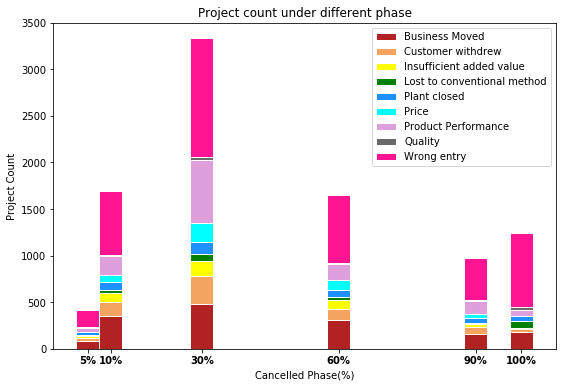

In [64]:


fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 6)

plt.bar(df_phase['Phase(%)'], df_phase['Business Moved'],color='firebrick', edgecolor='white', width=5)

plt.bar(df_phase['Phase(%)'], df_phase['Customer withdrew'],bottom=df_phase['Business Moved'], color='sandybrown', edgecolor='white', width=5)

plt.bar(df_phase['Phase(%)'], df_phase['Insufficient added value'],bottom=df_phase['Business Moved']+df_phase['Customer withdrew'], 
        color='yellow', edgecolor='white', width=5)

plt.bar(df_phase['Phase(%)'], df_phase['Lost to conventional method'],bottom=df_phase['Business Moved']+df_phase['Customer withdrew']+
        df_phase['Insufficient added value'], color='g', edgecolor='white', width=5)

plt.bar(df_phase['Phase(%)'], df_phase['Plant closed'],bottom=df_phase['Business Moved']+df_phase['Customer withdrew']+
        df_phase['Insufficient added value']+df_phase['Lost to conventional method'], color='dodgerblue', edgecolor='white', width=5)

plt.bar(df_phase['Phase(%)'], df_phase['Price'],bottom=df_phase['Business Moved']+df_phase['Customer withdrew']+
        df_phase['Insufficient added value']+df_phase['Lost to conventional method']+df_phase['Plant closed'], color='aqua', edgecolor='white', width=5)

plt.bar(df_phase['Phase(%)'], df_phase['Product Performance'],bottom=df_phase['Business Moved']+df_phase['Customer withdrew']+
        df_phase['Insufficient added value']+df_phase['Lost to conventional method']+df_phase['Price'], color='plum', edgecolor='white', width=5)

plt.bar(df_phase['Phase(%)'], df_phase['Quality'],bottom=df_phase['Business Moved']+df_phase['Customer withdrew']+
        df_phase['Insufficient added value']+df_phase['Lost to conventional method']+df_phase['Price']+df_phase['Product Performance'], color='dimgray', edgecolor='white', width=5)

plt.bar(df_phase['Phase(%)'], df_phase['Wrong entry'],bottom=df_phase['Business Moved']+df_phase['Customer withdrew']+
        df_phase['Insufficient added value']+df_phase['Lost to conventional method']+df_phase['Price']+df_phase['Product Performance']+df_phase['Quality'], color='deeppink', edgecolor='white', width=5)


plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Project Count')
plt.title('Project count under different phase')
plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality','Wrong entry'], loc='upper right')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')

plt.savefig('Project count under different phase.png')

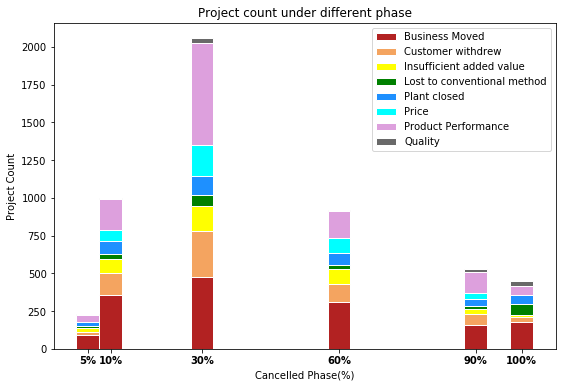

In [127]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 6)

plt.bar(df_phase['Phase(%)'], df_phase['Business Moved'],color='firebrick', edgecolor='white', width=5)

plt.bar(df_phase['Phase(%)'], df_phase['Customer withdrew'],bottom=df_phase['Business Moved'], color='sandybrown', edgecolor='white', width=5)

plt.bar(df_phase['Phase(%)'], df_phase['Insufficient added value'],bottom=df_phase['Business Moved']+df_phase['Customer withdrew'], 
        color='yellow', edgecolor='white', width=5)

plt.bar(df_phase['Phase(%)'], df_phase['Lost to conventional method'],bottom=df_phase['Business Moved']+df_phase['Customer withdrew']+
        df_phase['Insufficient added value'], color='g', edgecolor='white', width=5)

plt.bar(df_phase['Phase(%)'], df_phase['Plant closed'],bottom=df_phase['Business Moved']+df_phase['Customer withdrew']+
        df_phase['Insufficient added value']+df_phase['Lost to conventional method'], color='dodgerblue', edgecolor='white', width=5)

plt.bar(df_phase['Phase(%)'], df_phase['Price'],bottom=df_phase['Business Moved']+df_phase['Customer withdrew']+
        df_phase['Insufficient added value']+df_phase['Lost to conventional method']+df_phase['Plant closed'], color='aqua', edgecolor='white', width=5)

plt.bar(df_phase['Phase(%)'], df_phase['Product Performance'],bottom=df_phase['Business Moved']+df_phase['Customer withdrew']+
        df_phase['Insufficient added value']+df_phase['Lost to conventional method']+df_phase['Price'], color='plum', edgecolor='white', width=5)

plt.bar(df_phase['Phase(%)'], df_phase['Quality'],bottom=df_phase['Business Moved']+df_phase['Customer withdrew']+
        df_phase['Insufficient added value']+df_phase['Lost to conventional method']+df_phase['Price']+df_phase['Product Performance'], color='dimgray', edgecolor='white', width=5)

#plt.bar(df_phase['Phase(%)'], df_phase['Wrong entry'],bottom=df_phase['Business Moved']+df_phase['Customer withdrew']+
#        df_phase['Insufficient added value']+df_phase['Lost to conventional method']+df_phase['Price']+df_phase['Product Performance']+df_phase['Quality'], color='deeppink', edgecolor='white', width=5)


plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Project Count')
plt.title('Project count under different phase')
plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality'], loc='upper right')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')

plt.savefig('Project count wo wrong entry.png')

Overview of Sales Annualzied(M)

In [65]:


sales = pd.pivot_table(df_cancelled, index=['Phase(%)'], columns=['Reason'], values = 'Sales Annualized_cor(M)', aggfunc=np.sum)
sales = sales.reset_index()

sales = sales.drop(['Relationship (Gain from competition)'],axis=1)
sales

ss1 = sales.rename(columns={'Business Moved': 'B', 'Customer withdrew': 'C', 
                           'Insufficient added value':'I', 'Lost to conventional method':'L', 'Plant closed':'P1',
                          'Price':'P2','Product Performance':'P3','Quality':'Q', 'Wrong entry':'W'})
ss1

ss1.to_excel("NES overall.xlsx")

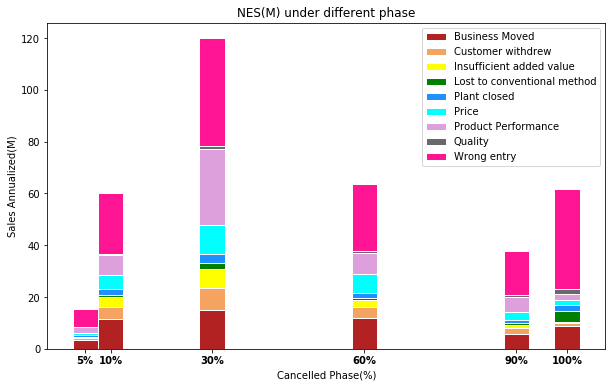

In [66]:
#df_sales.plot.bar(x='Phase(%)',y='Sales Annualized_cor(M)')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)

A = ss1['Phase(%)']
B = ss1['B']
C = ss1['C']
I = ss1['I']
L = ss1['L']
P1 = ss1['P1']
P2 = ss1['P2']
P3 = ss1['P3']
Q = ss1['Q']
W = ss1['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)

#label = ['n = 6', 'n = 25', 'n = 13', 'n = 36', 'n = 30', 'n = 11', 'n = 16', 'n = 37', 'n = 14', 'n = 4', 'n = 31', 'n = 34']


plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Sales Annualized(M)')
plt.title('NES(M) under different phase')
plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality','Wrong entry'], loc='upper right')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('Sales Annualzied under different phase.png')

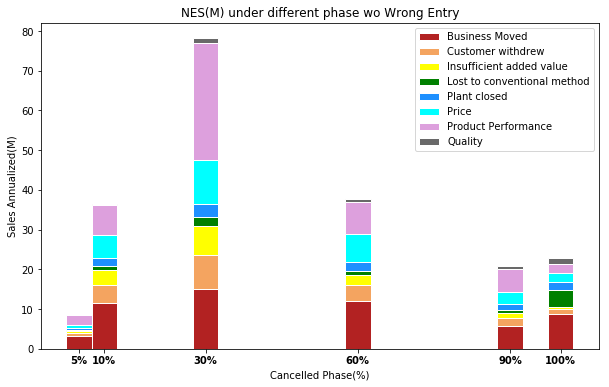

In [126]:
#df_sales.plot.bar(x='Phase(%)',y='Sales Annualized_cor(M)')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 6)

A = ss1['Phase(%)']
B = ss1['B']
C = ss1['C']
I = ss1['I']
L = ss1['L']
P1 = ss1['P1']
P2 = ss1['P2']
P3 = ss1['P3']
Q = ss1['Q']
#W = ss1['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
#plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)

#label = ['n = 6', 'n = 25', 'n = 13', 'n = 36', 'n = 30', 'n = 11', 'n = 16', 'n = 37', 'n = 14', 'n = 4', 'n = 31', 'n = 34']


plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Sales Annualized(M)')
plt.title('NES(M) under different phase wo Wrong Entry')
plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality'], loc='upper right')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('Sales Annualzied without Wrong Entry.png')

View Project Count by SU

In [67]:
#Breakdown project count by SU vs cancelled phase
df_su = pd.pivot_table(df_cancelled, index=['Phase(%)','SU'], columns=['Reason'], values = 'Phase Count', aggfunc=np.sum)
df_su = df_su.reset_index()

df_su = df_su[~((df_su['SU']=='AIG')|(df_su['SU']=='AIT')|(df_su['SU']=='AIZ'))]
df_su = df_su.drop(['Relationship (Gain from competition)'],axis=1)
df_su = df_su.fillna(0)

su = df_su.rename(columns={'Business Moved': 'B', 'Customer withdrew': 'C', 
                           'Insufficient added value':'I', 'Lost to conventional method':'L', 'Plant closed':'P1',
                          'Price':'P2','Product Performance':'P3','Quality':'Q', 'Wrong entry':'W'})

#su


In [68]:
#By SU
s2 = su[su['SU']=='AIC']
s3 = su[su['SU']=='AIF']
s4 = su[su['SU']=='AIH']
s5 = su[su['SU']=='AIL']
s6 = su[su['SU']=='AIN']
s7 = su[su['SU']=='AIP']
s8 = su[su['SU']=='AIS']

#s2
#s3
#s2.to_excel("AIC Count.xlsx")
s3.to_excel("AIF Count.xlsx")
s4.to_excel("AIH Count.xlsx")
s5.to_excel("AIL Count.xlsx")
s6.to_excel("AIN Count.xlsx")
s7.to_excel("AIP Count.xlsx")
s8.to_excel("AIS Count.xlsx")

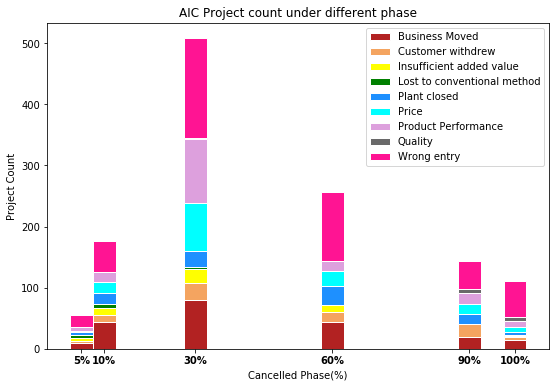

In [69]:
#AIC
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 6)

A = s2['Phase(%)']
B = s2['B']
C = s2['C']
I = s2['I']
L = s2['L']
P1 = s2['P1']
P2 = s2['P2']
P3 = s2['P3']
Q = s2['Q']
W = s2['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)


plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Project Count')
plt.title('AIC Project count under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality','Wrong entry'], loc='upper right')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('AIC Project Count under different phase.png')

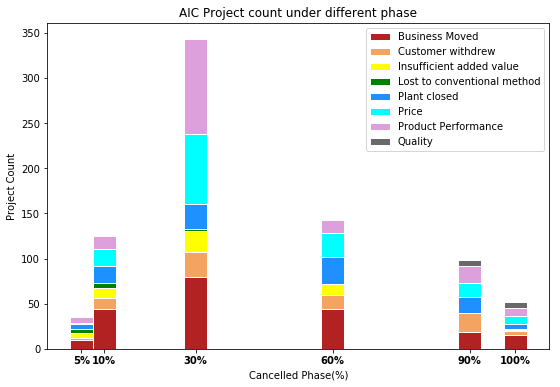

In [128]:
#AIC
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 6)

A = s2['Phase(%)']
B = s2['B']
C = s2['C']
I = s2['I']
L = s2['L']
P1 = s2['P1']
P2 = s2['P2']
P3 = s2['P3']
Q = s2['Q']
W = s2['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
#plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)


plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Project Count')
plt.title('AIC Project count under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality'], loc='upper right')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('AIC Project Count wo wrong entry.png')

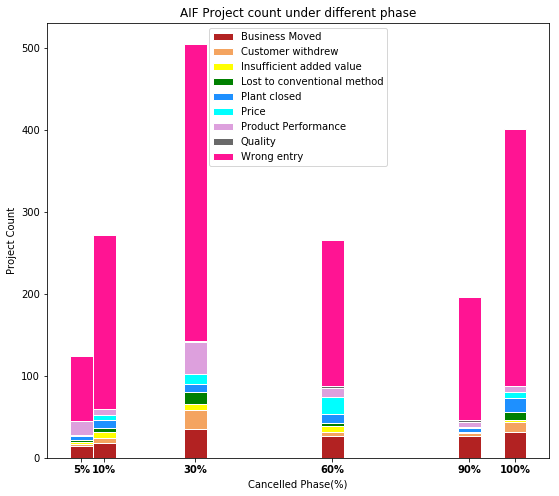

In [70]:
#AIF
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9,8)

A = s3['Phase(%)']
B = s3['B']
C = s3['C']
I = s3['I']
L = s3['L']
P1 = s3['P1']
P2 = s3['P2']
P3 = s3['P3']
Q = s3['Q']
W = s3['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)


plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Project Count')
plt.title('AIF Project count under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality','Wrong entry'], loc='upper center')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('AIF Project Count under different phase.png')

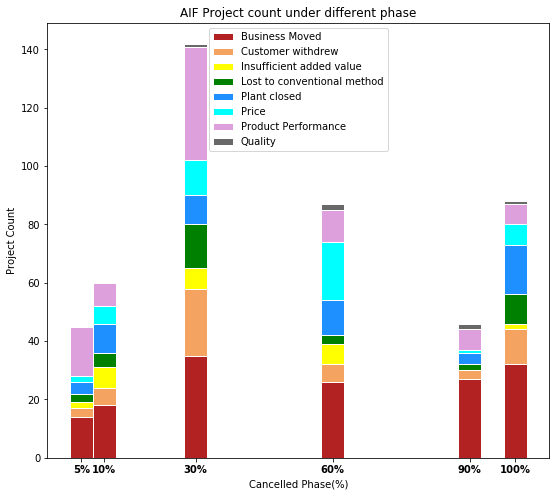

In [129]:
#AIF
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9,8)

A = s3['Phase(%)']
B = s3['B']
C = s3['C']
I = s3['I']
L = s3['L']
P1 = s3['P1']
P2 = s3['P2']
P3 = s3['P3']
Q = s3['Q']
W = s3['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
#plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)


plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Project Count')
plt.title('AIF Project count under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality'], loc='upper center')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('AIF Project Count wo wrong enrty.png')

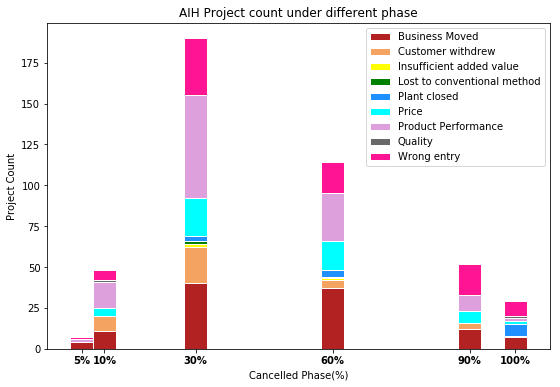

In [71]:
#AIH
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9,6)

A = s4['Phase(%)']
B = s4['B']
C = s4['C']
I = s4['I']
L = s4['L']
P1 = s4['P1']
P2 = s4['P2']
P3 = s4['P3']
Q = s4['Q']
W = s4['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)

plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Project Count')
plt.title('AIH Project count under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality','Wrong entry'], loc='upper right')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')

plt.savefig('AIH Project Count under different phase.png')

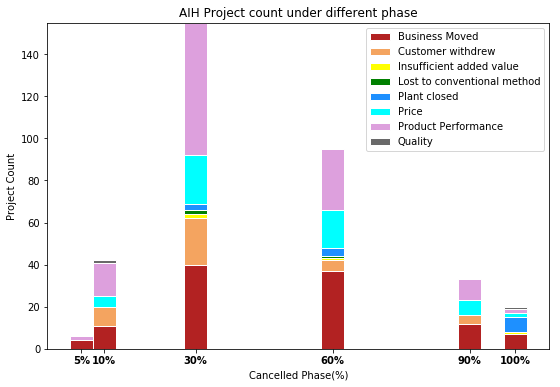

In [133]:
#AIH
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9,6)

A = s4['Phase(%)']
B = s4['B']
C = s4['C']
I = s4['I']
L = s4['L']
P1 = s4['P1']
P2 = s4['P2']
P3 = s4['P3']
Q = s4['Q']
#W = s4['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
#plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)

plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Project Count')
plt.title('AIH Project count under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality'], loc='upper right')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')

plt.savefig('AIH Project Count wo wrong entry.png')

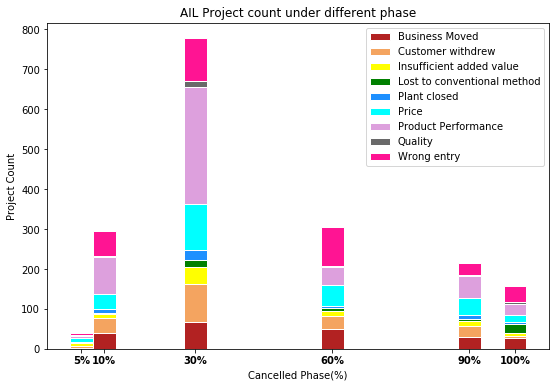

In [72]:
#AIL

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9,6)

A = s5['Phase(%)']
B = s5['B']
C = s5['C']
I = s5['I']
L = s5['L']
P1 = s5['P1']
P2 = s5['P2']
P3 = s5['P3']
Q = s5['Q']
W = s5['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)

plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Project Count')
plt.title('AIL Project count under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality','Wrong entry'], loc='upper right')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('AIL Project Count under different phase.png')

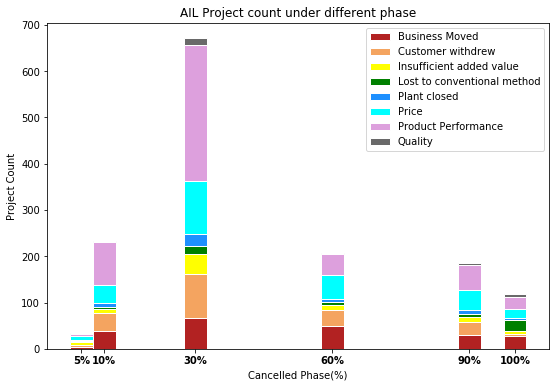

In [134]:
#AIL

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9,6)

A = s5['Phase(%)']
B = s5['B']
C = s5['C']
I = s5['I']
L = s5['L']
P1 = s5['P1']
P2 = s5['P2']
P3 = s5['P3']
Q = s5['Q']
#W = s5['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
#plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)

plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Project Count')
plt.title('AIL Project count under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality'], loc='upper right')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('AIL Project Count wo wrong entry.png')

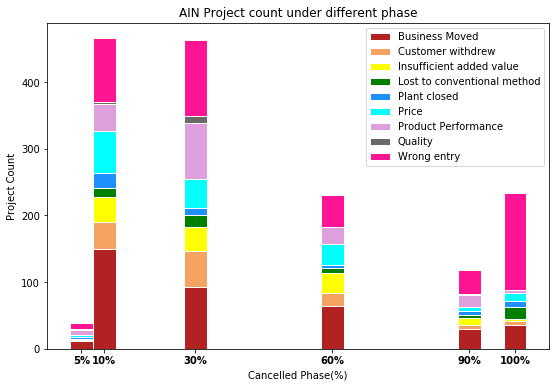

In [73]:
#AIN
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9,6)

A = s6['Phase(%)']
B = s6['B']
C = s6['C']
I = s6['I']
L = s6['L']
P1 = s6['P1']
P2 = s6['P2']
P3 = s6['P3']
Q = s6['Q']
W = s6['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)

plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Project Count')
plt.title('AIN Project count under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality','Wrong entry'], loc='upper right')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('AIN Project Count under different phase.png')

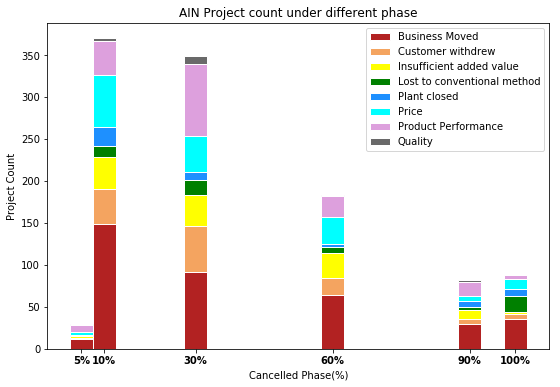

In [135]:
#AIN
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9,6)

A = s6['Phase(%)']
B = s6['B']
C = s6['C']
I = s6['I']
L = s6['L']
P1 = s6['P1']
P2 = s6['P2']
P3 = s6['P3']
Q = s6['Q']
#W = s6['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
#plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)

plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Project Count')
plt.title('AIN Project count under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality'], loc='upper right')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('AIN Project Count wo wrong entry.png')

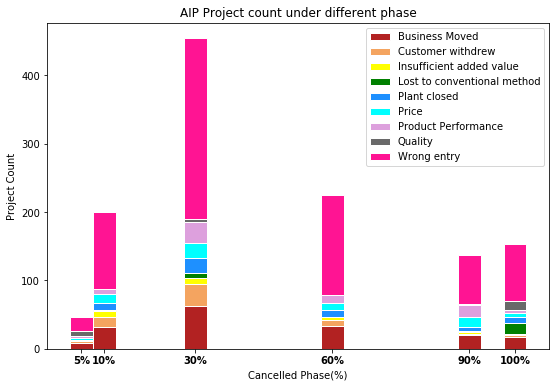

In [74]:
#AIP

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9,6)

A = s7['Phase(%)']
B = s7['B']
C = s7['C']
I = s7['I']
L = s7['L']
P1 = s7['P1']
P2 = s7['P2']
P3 = s7['P3']
Q = s7['Q']
W = s7['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)

plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Project Count')
plt.title('AIP Project count under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality','Wrong entry'], loc='upper right')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('AIP Project Count under different phase.png')

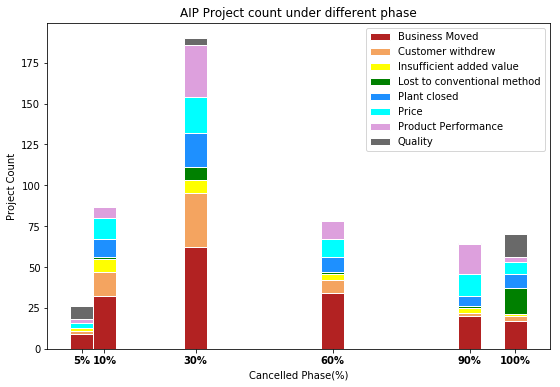

In [136]:
#AIP

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9,6)

A = s7['Phase(%)']
B = s7['B']
C = s7['C']
I = s7['I']
L = s7['L']
P1 = s7['P1']
P2 = s7['P2']
P3 = s7['P3']
Q = s7['Q']
#W = s7['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
#plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)

plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Project Count')
plt.title('AIP Project count under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality'], loc='upper right')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('AIP Project Count wo wrong entry.png')

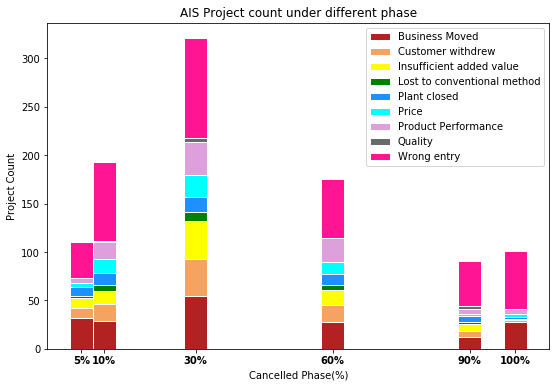

In [75]:
#AIS

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9,6)

A = s8['Phase(%)']
B = s8['B']
C = s8['C']
I = s8['I']
L = s8['L']
P1 = s8['P1']
P2 = s8['P2']
P3 = s8['P3']
Q = s8['Q']
W = s8['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)

plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Project Count')
plt.title('AIS Project count under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality','Wrong entry'], loc='upper right')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('AIS Project Count under different phase.png')

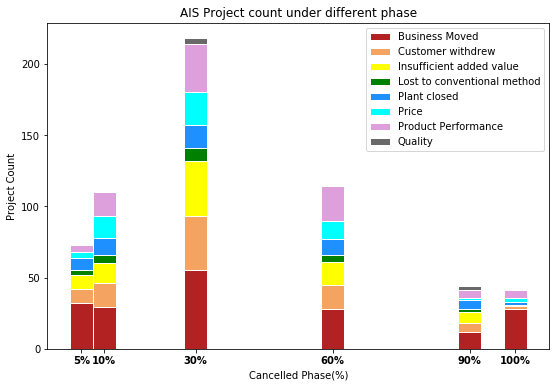

In [137]:
#AIS

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9,6)

A = s8['Phase(%)']
B = s8['B']
C = s8['C']
I = s8['I']
L = s8['L']
P1 = s8['P1']
P2 = s8['P2']
P3 = s8['P3']
Q = s8['Q']
#W = s8['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
#plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)

plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Project Count')
plt.title('AIS Project count under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality'], loc='upper right')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('AIS Project Count wo wrong entry.png')

View Sales Annualized(M) by SU

In [76]:

#Breakdown sales annualized(M) by SU vs cancelled phase
sales_su = pd.pivot_table(df_cancelled, index=['Phase(%)','SU'], columns=['Reason'], values = 'Sales Annualized_cor(M)', aggfunc=np.sum)
sales_su = sales_su.reset_index()

sales_su = sales_su[~((sales_su['SU']=='AIG')|(sales_su['SU']=='AIT')|(sales_su['SU']=='AIZ'))]
sales_su = sales_su.drop(['Relationship (Gain from competition)'],axis=1)
sales_su = sales_su.fillna(0)

ssu = sales_su.rename(columns={'Business Moved': 'B', 'Customer withdrew': 'C', 
                           'Insufficient added value':'I', 'Lost to conventional method':'L', 'Plant closed':'P1',
                          'Price':'P2','Product Performance':'P3','Quality':'Q', 'Wrong entry':'W'})

#ssu


In [77]:
#By SU
ss2 = ssu[ssu['SU']=='AIC']
ss3 = ssu[ssu['SU']=='AIF']
ss4 = ssu[ssu['SU']=='AIH']
ss5 = ssu[ssu['SU']=='AIL']
ss6 = ssu[ssu['SU']=='AIN']
ss7 = ssu[ssu['SU']=='AIP']
ss8 = ssu[ssu['SU']=='AIS']

#ss2.to_excel("AIC NES.xlsx")
#ss3.to_excel("AIF NES.xlsx")
#ss4.to_excel("AIH NES.xlsx")
#ss5.to_excel("AIL NES.xlsx")
#ss6.to_excel("AIN NES.xlsx")
#ss7.to_excel("AIP NES.xlsx")
#ss8.to_excel("AIS NES.xlsx")

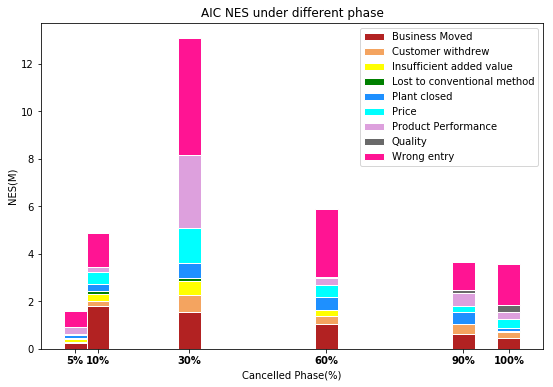

In [78]:
#AIC
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 6)

A = ss2['Phase(%)']
B = ss2['B']
C = ss2['C']
I = ss2['I']
L = ss2['L']
P1 = ss2['P1']
P2 = ss2['P2']
P3 = ss2['P3']
Q = ss2['Q']
W = ss2['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)


plt.xlabel('Cancelled Phase(%)')
plt.ylabel('NES(M)')
plt.title('AIC NES under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality','Wrong entry'], loc='upper right')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('AIC NES under different phase.png')

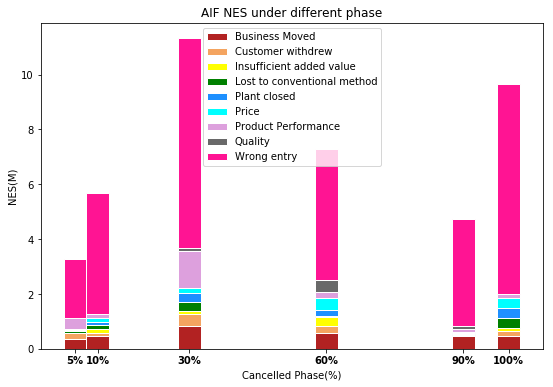

In [79]:
#AIF
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9,6)

A = ss3['Phase(%)']
B = ss3['B']
C = ss3['C']
I = ss3['I']
L = ss3['L']
P1 = ss3['P1']
P2 = ss3['P2']
P3 = ss3['P3']
Q = ss3['Q']
W = ss3['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)


plt.xlabel('Cancelled Phase(%)')
plt.ylabel('NES(M)')
plt.title('AIF NES under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality','Wrong entry'], loc='upper center')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('AIF NES under different phase.png')

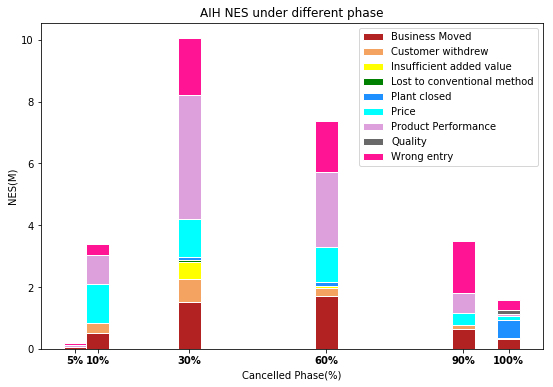

In [80]:
#AIH
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 6)

A = ss4['Phase(%)']
B = ss4['B']
C = ss4['C']
I = ss4['I']
L = ss4['L']
P1 = ss4['P1']
P2 = ss4['P2']
P3 = ss4['P3']
Q = ss4['Q']
W = ss4['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)


plt.xlabel('Cancelled Phase(%)')
plt.ylabel('NES(M)')
plt.title('AIH NES under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality','Wrong entry'], loc='upper right')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('AIH NES under different phase.png')

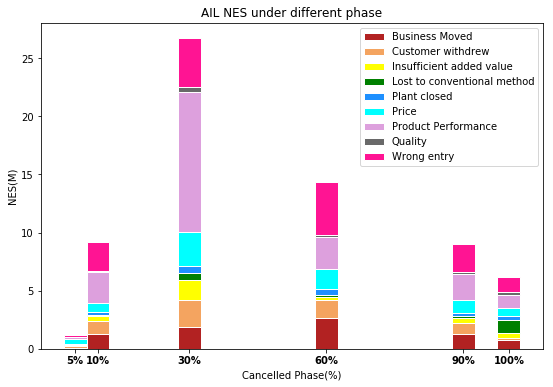

In [81]:
#AIL

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 6)

A = ss5['Phase(%)']
B = ss5['B']
C = ss5['C']
I = ss5['I']
L = ss5['L']
P1 = ss5['P1']
P2 = ss5['P2']
P3 = ss5['P3']
Q = ss5['Q']
W = ss5['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)


plt.xlabel('Cancelled Phase(%)')
plt.ylabel('NES(M)')
plt.title('AIL NES under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality','Wrong entry'], loc='upper right')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('AIL NES under different phase.png')

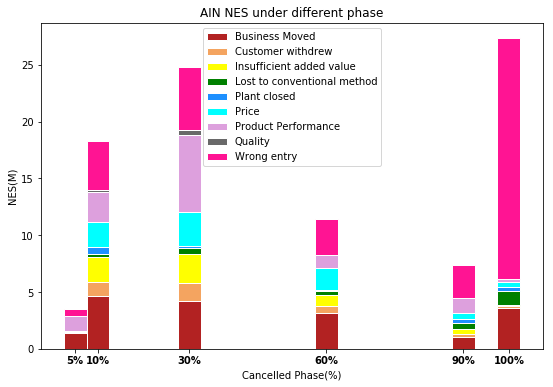

In [82]:
#AIN

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 6)

A = ss6['Phase(%)']
B = ss6['B']
C = ss6['C']
I = ss6['I']
L = ss6['L']
P1 = ss6['P1']
P2 = ss6['P2']
P3 = ss6['P3']
Q = ss6['Q']
W = ss6['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)


plt.xlabel('Cancelled Phase(%)')
plt.ylabel('NES(M)')
plt.title('AIN NES under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality','Wrong entry'], loc='upper center')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('AIN NES under different phase.png')

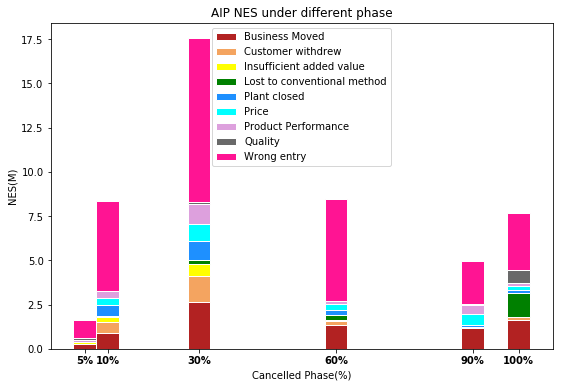

In [83]:
#AIP

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 6)

A = ss7['Phase(%)']
B = ss7['B']
C = ss7['C']
I = ss7['I']
L = ss7['L']
P1 = ss7['P1']
P2 = ss7['P2']
P3 = ss7['P3']
Q = ss7['Q']
W = ss7['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)


plt.xlabel('Cancelled Phase(%)')
plt.ylabel('NES(M)')
plt.title('AIP NES under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality','Wrong entry'], loc='upper center')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('AIP NES under different phase.png')

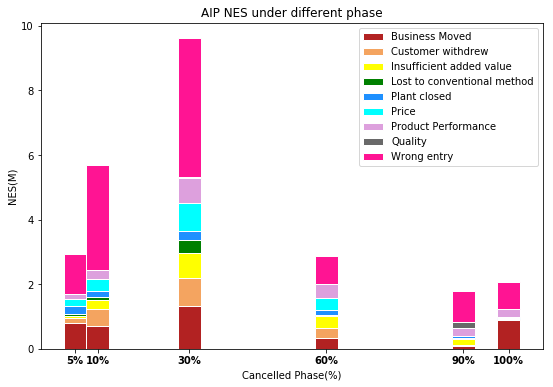

In [84]:
#AIS
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 6)

A = ss8['Phase(%)']
B = ss8['B']
C = ss8['C']
I = ss8['I']
L = ss8['L']
P1 = ss8['P1']
P2 = ss8['P2']
P3 = ss8['P3']
Q = ss8['Q']
W = ss8['W']

plt.bar(A, B, color='firebrick', edgecolor='white', width=5)
plt.bar(A, C, bottom = B, color='sandybrown', edgecolor='white', width=5)
plt.bar(A, I, bottom = B+C, color='yellow', edgecolor='white', width=5)
plt.bar(A, L, bottom = B+C+I, color='g', edgecolor='white', width=5)
plt.bar(A, P1, bottom = B+C+I+L, color='dodgerblue', edgecolor='white', width=5)
plt.bar(A, P2, bottom = B+C+I+L+P1, color='aqua', edgecolor='white', width=5)
plt.bar(A, P3, bottom = B+C+I+L+P1+P2, color='plum', edgecolor='white', width=5)
plt.bar(A, Q, bottom = B+C+I+L+P1+P2+P3, color='dimgray', edgecolor='white', width=5)
plt.bar(A, W, bottom = B+C+I+L+P1+P2+P3+Q, color='deeppink', edgecolor='white', width=5)


plt.xlabel('Cancelled Phase(%)')
plt.ylabel('NES(M)')
plt.title('AIP NES under different phase')

plt.legend(['Business Moved', 'Customer withdrew', 'Insufficient added value','Lost to conventional method','Plant closed','Price','Product Performance','Quality','Wrong entry'], loc='upper right')
names=['5%','10%','30%','60%','90%','100%']
plt.xticks(df_phase['Phase(%)'], names, fontweight='bold')
plt.savefig('AIS NES under different phase.png')

View Project Count by Segmentation

In [85]:
#Breakdown project count by Segmentation vs cancelled phase
df_seg = pd.pivot_table(df_cancelled, index=['Phase(%)'], columns=['Segmentation (KNA1-KATR2)'], values = 'Phase Count', aggfunc=np.sum)
df_seg = df_seg.reset_index()
#df_seg

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


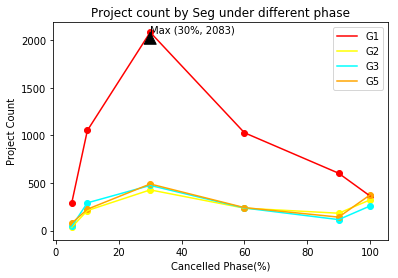

In [86]:

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(6, 4)
plt.scatter(df_seg['Phase(%)'], df_seg['G1'], color='red')
plt.plot(df_seg['Phase(%)'], df_seg['G1'], color='red')

plt.scatter(df_seg['Phase(%)'], df_seg['G2'], color='yellow')
plt.plot(df_seg['Phase(%)'], df_seg['G2'], color='yellow')

plt.scatter(df_seg['Phase(%)'], df_seg['G3'], color='cyan')
plt.plot(df_seg['Phase(%)'], df_seg['G3'], color='cyan')

plt.scatter(df_seg['Phase(%)'], df_seg['G5'], color='orange')
plt.plot(df_seg['Phase(%)'], df_seg['G5'], color='orange')

y_max = df_seg['G1'].max()
x=df_seg['G1'].argmax()
x_max=df_seg['Phase(%)'][x]
plt.annotate('Max (30%, 2083)',xy=(x_max,y_max), arrowprops=dict(facecolor='black'))

plt.legend(['G1', 'G2', 'G3','G5'], loc='upper right')
plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Project Count')
plt.title('Project count by Seg under different phase')
plt.savefig('Project Count by Segment under different phase.png')

View Sales Annualized(M) by Segmentation

In [87]:
#Breakdown sales annualized(M) by Segmentation vs cancelled phase
df_sales_seg = pd.pivot_table(df_cancelled, index=['Phase(%)'], columns=['Segmentation (KNA1-KATR2)'], values = 'Sales Annualized_cor(M)', aggfunc=np.sum)
df_sales_seg = df_sales_seg.reset_index()
#df_sales_seg

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


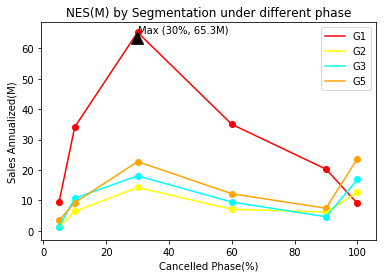

In [88]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(6, 4)

plt.scatter(df_sales_seg['Phase(%)'], df_sales_seg['G1'], color='red')
plt.plot(df_sales_seg['Phase(%)'], df_sales_seg['G1'], color='red')

plt.scatter(df_sales_seg['Phase(%)'], df_sales_seg['G2'], color='yellow')
plt.plot(df_sales_seg['Phase(%)'], df_sales_seg['G2'], color='yellow')

plt.scatter(df_sales_seg['Phase(%)'], df_sales_seg['G3'], color='cyan')
plt.plot(df_sales_seg['Phase(%)'], df_sales_seg['G3'], color='cyan')

plt.scatter(df_sales_seg['Phase(%)'], df_sales_seg['G5'], color='orange')
plt.plot(df_sales_seg['Phase(%)'], df_sales_seg['G5'], color='orange')

y_max = df_sales_seg['G1'].max()
x=df_sales_seg['G1'].argmax()
x_max=df_sales_seg['Phase(%)'][x]
plt.annotate('Max (30%, 65.3M)',xy=(x_max,y_max), arrowprops=dict(facecolor='black'))

plt.legend(['G1', 'G2', 'G3','G5'], loc='upper right')
plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Sales Annualized(M)')
plt.title('NES(M) by Segmentation under different phase')
plt.savefig('Sales Annualized by Seg under different phase.png')

In [89]:
#Average Sales Annualized per project by SU

df_seg_v1 = df_seg.rename(columns={'Phase(%)':'Phase(%)_count','G1':'G1_count','G2':'G2_count','G3':'G3_count','G4':'G4_count','G5':'G5_count'})
sales_seg_avg = pd.concat([df_seg_v1, df_sales_seg], axis=1)
sales_seg_avg = pd.DataFrame(sales_seg_avg)
sales_seg_avg['G1_avg(K)'] = sales_seg_avg['G1']/sales_seg_avg['G1_count'] * 1000
sales_seg_avg['G2_avg(K)'] = sales_seg_avg['G2']/sales_seg_avg['G2_count'] * 1000
sales_seg_avg['G3_avg(K)'] = sales_seg_avg['G3']/sales_seg_avg['G3_count'] * 1000
sales_seg_avg['G5_avg(K)'] = sales_seg_avg['G5']/sales_seg_avg['G5_count'] * 1000
sales_seg_avg

Segmentation (KNA1-KATR2)  Phase(%)_count  G1_count  G2_count  G3_count  \
0                                       5     288.0      35.0      44.0   
1                                      10    1052.0     211.0     292.0   
2                                      30    2083.0     428.0     475.0   
3                                      60    1028.0     236.0     238.0   
4                                      90     603.0     183.0     116.0   
5                                     100     364.0     323.0     259.0   

Segmentation (KNA1-KATR2)  G4_count  G5_count  Phase(%)         G1         G2  \
0                               NaN      77.0         5   9.387434   1.188300   
1                               NaN     225.0        10  34.150178   6.413293   
2                               1.0     490.0        30  65.315149  14.256179   
3                               NaN     242.0        60  35.030316   7.077565   
4                               NaN     142.0        90  20.283901   6.182149   
5                               NaN     375.0       100   9.009141  12.648879   

Segmentation (KNA1-KATR2)         G3        G4         G5  G1_avg(K)  \
0                           1.276325       NaN   3.404762  32.595257   
1                          10.695184       NaN   9.229761  32.462147   
2                          18.084114  0.011801  22.777850  31.356288   
3                           9.466288       NaN  12.173275  34.076182   
4                           4.617717       NaN   7.434419  33.638310   
5                          16.884238       NaN  23.745032  24.750388   

Segmentation (KNA1-KATR2)  G2_avg(K)  G3_avg(K)  G5_avg(K)  
0                          33.951425  29.007391  44.217691  
1                          30.394752  36.627342  41.021159  
2                          33.308830  38.071819  46.485408  
3                          29.989684  39.774319  50.302790  
4                          33.782237  39.807909  52.355060  
5                          39.160617  65.190107  63.320086

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  


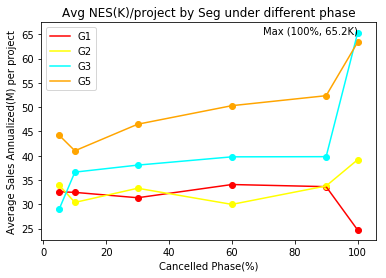

In [90]:
plt.scatter(sales_seg_avg['Phase(%)'], sales_seg_avg['G1_avg(K)'], color='red')
plt.plot(sales_seg_avg['Phase(%)'], sales_seg_avg['G1_avg(K)'], color='red')

plt.scatter(sales_seg_avg['Phase(%)'], sales_seg_avg['G2_avg(K)'], color='yellow')
plt.plot(sales_seg_avg['Phase(%)'], sales_seg_avg['G2_avg(K)'], color='yellow')

plt.scatter(sales_seg_avg['Phase(%)'], sales_seg_avg['G3_avg(K)'], color='cyan')
plt.plot(sales_seg_avg['Phase(%)'], sales_seg_avg['G3_avg(K)'], color='cyan')

plt.scatter(sales_seg_avg['Phase(%)'], sales_seg_avg['G5_avg(K)'], color='orange')
plt.plot(sales_seg_avg['Phase(%)'], sales_seg_avg['G5_avg(K)'], color='orange')

y_max = sales_seg_avg['G3_avg(K)'].max()
x = sales_seg_avg['G3_avg(K)'].argmax()
x_max = sales_seg_avg['Phase(%)'][x]
#plt.annotate('Max (100%, 65.2K)',xy=(x_max-2,y_max+1), arrowprops=dict(facecolor='black'))
plt.annotate('Max (100%, 65.2K)',xy=(x_max-30,y_max))
plt.legend(['G1', 'G2', 'G3','G5'], loc='upper left')
plt.xlabel('Cancelled Phase(%)')
plt.ylabel('Average Sales Annualized(M) per project')
plt.title('Avg NES(K)/project by Seg under different phase')
plt.savefig('NES(K) by seg under different phase.png')

View Project Count by Project Duration

In [91]:
#Breakdown project count by Project Duration vs cancelled phase

df_dur = pd.pivot_table(df_cancelled, index=['Project Duration'], columns=['Phase(%)'], values = 'Phase Count', aggfunc=np.sum)
df_dur=df_dur.fillna(0)

df_dur=df_dur.reset_index()
print(min(df_dur['Project Duration']),max(df_dur['Project Duration']))

Q1 = df_dur.quantile(0.25)
Q3 = df_dur.quantile(0.75)
IQR = Q3 - Q1

df_dur = df_dur[~((df_dur < (Q1 - 1.5 * IQR)) |(df_dur > (Q3 + 1.5 * IQR))).any(axis=1)]

df_dur['Duration_group'] = 1
df_dur['Duration_group'] = np.where((df_dur['Project Duration']>=0)&(df_dur['Project Duration']<=90), "00-03 Months", df_dur['Duration_group'])
df_dur['Duration_group'] = np.where((df_dur['Project Duration']>90)&(df_dur['Project Duration']<=180), "03-06 Months", df_dur['Duration_group'])
df_dur['Duration_group'] = np.where((df_dur['Project Duration']>180)&(df_dur['Project Duration']<=270), "06-09 Months", df_dur['Duration_group'])
df_dur['Duration_group'] = np.where((df_dur['Project Duration']>270)&(df_dur['Project Duration']<=360), "09-12 Months", df_dur['Duration_group'])
df_dur['Duration_group'] = np.where((df_dur['Project Duration']>360)&(df_dur['Project Duration']<=450), "12-15 Months", df_dur['Duration_group'])
df_dur['Duration_group'] = np.where((df_dur['Project Duration']>450)&(df_dur['Project Duration']<=540), "15-18 Months", df_dur['Duration_group'])
df_dur['Duration_group'] = np.where((df_dur['Project Duration']>540)&(df_dur['Project Duration']<=630), "18-21 Months", df_dur['Duration_group'])
df_dur['Duration_group'] = np.where((df_dur['Project Duration']>630)&(df_dur['Project Duration']<=720), "21-24 Months", df_dur['Duration_group'])
df_dur['Duration_group'] = np.where((df_dur['Project Duration']>720)&(df_dur['Project Duration']<=810), "24-27 Months", df_dur['Duration_group'])
df_dur['Duration_group'] = np.where((df_dur['Project Duration']>810)&(df_dur['Project Duration']<=900), "27-30 Months", df_dur['Duration_group'])
df_dur['Duration_group'] = np.where((df_dur['Project Duration']>900)&(df_dur['Project Duration']<=1080), "30-36 Months", df_dur['Duration_group'])
df_dur['Duration_group'] = np.where((df_dur['Project Duration']>1080)&(df_dur['Project Duration']<=1260), "36-42 Months", df_dur['Duration_group'])
df_dur['Duration_group'] = np.where((df_dur['Project Duration']>1260)&(df_dur['Project Duration']<=1440), "42-48 Months", df_dur['Duration_group'])
df_dur['Duration_group'] = np.where((df_dur['Project Duration']>1440), "Above 48 Months", df_dur['Duration_group'])


#df_dur

1.0 2372.0


In [92]:
df_dur_group = df_dur[['Duration_group',5,10,30,60,90,100]].groupby(df_dur['Duration_group']).sum()
df_dur_group = df_dur_group.reset_index()
df_dur_group['Month'] = [1.5,4.5,7.5,10.5,13.5,16.5,19.5,22.5,25.5,28.5,33,39,45,51]
df_dur_group = df_dur_group.iloc[0:8]
df_dur_group

Phase(%) Duration_group    5    10     30    60    90   100  Month
0          00-03 Months  0.0  15.0   19.0   7.0   4.0  17.0    1.5
1          03-06 Months  0.0   9.0   22.0  10.0   2.0   2.0    4.5
2          06-09 Months  0.0  32.0  102.0  54.0  26.0  21.0    7.5
3          09-12 Months  0.0  58.0  147.0  87.0  28.0  29.0   10.5
4          12-15 Months  0.0  58.0  118.0  83.0  34.0  30.0   13.5
5          15-18 Months  0.0  78.0  132.0  95.0  40.0  22.0   16.5
6          18-21 Months  0.0  67.0  107.0  91.0  38.0  25.0   19.5
7          21-24 Months  0.0  52.0   84.0  60.0  39.0   8.0   22.5

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


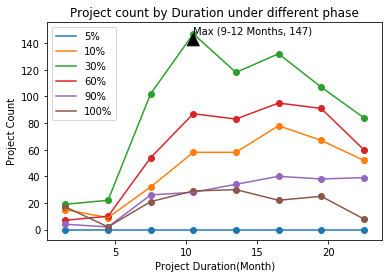

In [93]:

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(6, 4)
plt.scatter(df_dur_group['Month'],df_dur_group[5])
plt.plot(df_dur_group['Month'],df_dur_group[5])
plt.scatter(df_dur_group['Month'],df_dur_group[10])
plt.plot(df_dur_group['Month'],df_dur_group[10])
plt.scatter(df_dur_group['Month'],df_dur_group[30])
plt.plot(df_dur_group['Month'],df_dur_group[30])
plt.scatter(df_dur_group['Month'],df_dur_group[60])
plt.plot(df_dur_group['Month'],df_dur_group[60])
plt.scatter(df_dur_group['Month'],df_dur_group[90])
plt.plot(df_dur_group['Month'],df_dur_group[90])
plt.scatter(df_dur_group['Month'],df_dur_group[100])
plt.plot(df_dur_group['Month'],df_dur_group[100])
plt.xlabel('Project Duration(Month)')
plt.ylabel('Project Count')
y_max = df_dur_group[30].max()
x=df_dur_group[30].argmax()
x_max=df_dur_group['Month'][x]
plt.annotate('Max (9-12 Months, 147)',xy=(x_max,y_max), arrowprops=dict(facecolor='black'))
plt.legend(['5%', '10%', '30%','60%','90%','100%'], loc='upper left')
plt.title('Project count by Duration under different phase')
plt.savefig('Project count by Duration under different phase.png')

View Sales Annualized(M) by Project Duration

In [94]:
#Breakdown project count by Project Duration vs cancelled phase

df_sales_dur = pd.pivot_table(df_cancelled, index=['Project Duration'], columns=['Phase(%)'], values = 'Sales Annualized_cor(M)', aggfunc=np.sum)
df_sales_dur=df_sales_dur.fillna(0)

df_sales_dur=df_sales_dur.reset_index()
print(min(df_sales_dur['Project Duration']),max(df_sales_dur['Project Duration']))

Q1 = df_sales_dur.quantile(0.25)
Q3 = df_sales_dur.quantile(0.75)
IQR = Q3 - Q1

df_sales_dur = df_sales_dur[~((df_sales_dur < (Q1 - 1.5 * IQR)) |(df_sales_dur > (Q3 + 1.5 * IQR))).any(axis=1)]

df_sales_dur['Duration_group'] = 1
df_sales_dur['Duration_group'] = np.where((df_sales_dur['Project Duration']>=0)&(df_sales_dur['Project Duration']<=90), "00-03 Months", df_sales_dur['Duration_group'])
df_sales_dur['Duration_group'] = np.where((df_sales_dur['Project Duration']>90)&(df_sales_dur['Project Duration']<=180), "03-06 Months", df_sales_dur['Duration_group'])
df_sales_dur['Duration_group'] = np.where((df_sales_dur['Project Duration']>180)&(df_sales_dur['Project Duration']<=270), "06-09 Months", df_sales_dur['Duration_group'])
df_sales_dur['Duration_group'] = np.where((df_sales_dur['Project Duration']>270)&(df_sales_dur['Project Duration']<=360), "09-12 Months", df_sales_dur['Duration_group'])
df_sales_dur['Duration_group'] = np.where((df_sales_dur['Project Duration']>360)&(df_sales_dur['Project Duration']<=450), "12-15 Months", df_sales_dur['Duration_group'])
df_sales_dur['Duration_group'] = np.where((df_sales_dur['Project Duration']>450)&(df_sales_dur['Project Duration']<=540), "15-18 Months", df_sales_dur['Duration_group'])
df_sales_dur['Duration_group'] = np.where((df_sales_dur['Project Duration']>540)&(df_sales_dur['Project Duration']<=630), "18-21 Months", df_sales_dur['Duration_group'])
df_sales_dur['Duration_group'] = np.where((df_sales_dur['Project Duration']>630)&(df_sales_dur['Project Duration']<=720), "21-24 Months", df_sales_dur['Duration_group'])
df_sales_dur['Duration_group'] = np.where((df_sales_dur['Project Duration']>720)&(df_sales_dur['Project Duration']<=810), "24-27 Months", df_sales_dur['Duration_group'])
df_sales_dur['Duration_group'] = np.where((df_sales_dur['Project Duration']>810)&(df_sales_dur['Project Duration']<=900), "27-30 Months", df_sales_dur['Duration_group'])
df_sales_dur['Duration_group'] = np.where((df_sales_dur['Project Duration']>900)&(df_sales_dur['Project Duration']<=1080), "30-36 Months", df_sales_dur['Duration_group'])
df_sales_dur['Duration_group'] = np.where((df_sales_dur['Project Duration']>1080)&(df_sales_dur['Project Duration']<=1260), "36-42 Months", df_sales_dur['Duration_group'])
df_sales_dur['Duration_group'] = np.where((df_sales_dur['Project Duration']>1260)&(df_sales_dur['Project Duration']<=1440), "42-48 Months", df_sales_dur['Duration_group'])
df_sales_dur['Duration_group'] = np.where((df_sales_dur['Project Duration']>1440), "Above 48 Months", df_sales_dur['Duration_group'])


#df_sales_dur

1.0 2372.0


In [95]:
df_sales_dur_group = df_sales_dur[['Duration_group',5,10,30,60,90,100]].groupby(df_sales_dur['Duration_group']).sum()
df_sales_dur_group = df_sales_dur_group.reset_index()
df_sales_dur_group['Month'] = [1.5,4.5,7.5,10.5,13.5,16.5,19.5,22.5,25.5,28.5,33,39,45,51]
df_sales_dur_group = df_sales_dur_group.iloc[0:8]
#df_sales_dur_group

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


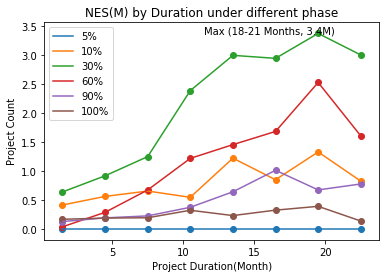

In [96]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(6, 4)

plt.scatter(df_sales_dur_group['Month'],df_sales_dur_group[5])
plt.plot(df_sales_dur_group['Month'],df_sales_dur_group[5])
plt.scatter(df_sales_dur_group['Month'],df_sales_dur_group[10])
plt.plot(df_sales_dur_group['Month'],df_sales_dur_group[10])
plt.scatter(df_sales_dur_group['Month'],df_sales_dur_group[30])
plt.plot(df_sales_dur_group['Month'],df_sales_dur_group[30])
plt.scatter(df_sales_dur_group['Month'],df_sales_dur_group[60])
plt.plot(df_sales_dur_group['Month'],df_sales_dur_group[60])
plt.scatter(df_sales_dur_group['Month'],df_sales_dur_group[90])
plt.plot(df_sales_dur_group['Month'],df_sales_dur_group[90])
plt.scatter(df_sales_dur_group['Month'],df_sales_dur_group[100])
plt.plot(df_sales_dur_group['Month'],df_sales_dur_group[100])
plt.xlabel('Project Duration(Month)')
plt.ylabel('Project Count')
y_max = df_sales_dur_group[30].max()
x=df_sales_dur_group[30].argmax()
x_max=df_sales_dur_group['Month'][x]
#plt.annotate('Max (18-21 Months, 3.4M)',xy=(x_max,y_max), arrowprops=dict(facecolor='black'))
plt.annotate('Max (18-21 Months, 3.4M)',xy=(x_max-8,y_max))
plt.legend(['5%', '10%', '30%','60%','90%','100%'], loc='upper left')
plt.title('NES(M) by Duration under different phase')
plt.savefig('NES(M) by Duration under different phase.png')

In [97]:
#Average Sales Annualized per project by Project Duration

df_dur_v1 = df_dur_group.rename(columns={'Phase(%)':'Phase(%)_count','Duration_group':'Duration_count',5:'5_count',10:'10_count',30:'30_count', 60:'60_count', 90:'90_count', 100:'100_count','Month':'Month_count'})
sales_dur_avg = pd.concat([df_dur_v1, df_sales_dur_group], axis=1)
sales_dur_avg = pd.DataFrame(sales_dur_avg)
sales_dur_avg['5_avg'] = sales_dur_avg[5]
sales_dur_avg['10_avg'] = sales_dur_avg[10] / sales_dur_avg['10_count'] * 1000
sales_dur_avg['30_avg'] = sales_dur_avg[30] / sales_dur_avg['30_count'] * 1000
sales_dur_avg['60_avg'] = sales_dur_avg[60] / sales_dur_avg['60_count'] * 1000
sales_dur_avg['90_avg'] = sales_dur_avg[90] / sales_dur_avg['90_count'] * 1000
sales_dur_avg['100_avg'] = sales_dur_avg[100] / sales_dur_avg['100_count'] * 1000
sales_dur_avg = sales_dur_avg.fillna(0)
sales_dur_avg = sales_dur_avg[0:8]
#sales_dur_avg

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


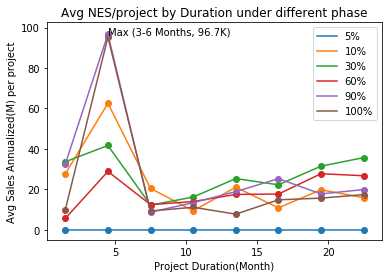

In [98]:
plt.scatter(sales_dur_avg['Month'],sales_dur_avg['5_avg'])
plt.plot(sales_dur_avg['Month'],sales_dur_avg['5_avg'])
plt.scatter(sales_dur_avg['Month'],sales_dur_avg['10_avg'])
plt.plot(sales_dur_avg['Month'],sales_dur_avg['10_avg'])
plt.scatter(sales_dur_avg['Month'],sales_dur_avg['30_avg'])
plt.plot(sales_dur_avg['Month'],sales_dur_avg['30_avg'])
plt.scatter(sales_dur_avg['Month'],sales_dur_avg['60_avg'])
plt.plot(sales_dur_avg['Month'],sales_dur_avg['60_avg'])
plt.scatter(sales_dur_avg['Month'],sales_dur_avg['90_avg'])
plt.plot(sales_dur_avg['Month'],sales_dur_avg['90_avg'])
plt.scatter(sales_dur_avg['Month'],sales_dur_avg['100_avg'])
plt.plot(sales_dur_avg['Month'],sales_dur_avg['100_avg'])

plt.xlabel('Project Duration(Month)')
plt.ylabel('Avg Sales Annualized(M) per project')
y_max = sales_dur_avg['90_avg'].max()
x = sales_dur_avg['90_avg'].argmax()
x_max = sales_dur_avg['Month'][x]
#plt.annotate('Max (3-6 Months, 96.7K)',xy=(x_max,y_max+2), arrowprops=dict(facecolor='black'))
plt.annotate('Max (3-6 Months, 96.7K)',xy=(x_max,y_max))
plt.legend(['5%', '10%', '30%','60%','90%','100%'], loc='upper right')
plt.title('Avg NES/project by Duration under different phase')
plt.savefig('Avg NES by Duration under different phase.png')

View Project count by Area

In [99]:
df_area = pd.pivot_table(df_cancelled, index=['Phase(%)'], columns=['Area'], values = 'Phase Count', aggfunc=np.sum)
df_area = df_area.drop(['Province Unknown'],axis=1)
#df_area
#df_area.to_excel("df_area.xlsx")

View Sales Annualized(M) by Area

In [100]:
df_sales_area = pd.pivot_table(df_cancelled, index=['Phase(%)'], columns=['Area'], values = 'Sales Annualized_cor(M)', aggfunc=np.sum)
df_sales_area = df_sales_area.drop(['Province Unknown'],axis=1)
#df_sales_area
#df_sales_area.to_excel("df_sales_area.xlsx")

In [101]:
df_area_v1 = df_area.rename(columns={'Dong Bei':'Dong Bei_count','Hong Kong':'Hong Kong_count','Hua Bei':'Hua Bei_count','Hua Dong':'Hua Dong_count','Hua Nan':'Hua Nan_count','Hua Zhong':'Hua Zhong_count','Xi Bei':'Xi Bei_count','Xi Nan':'Xi Nan_count'})
sales_area_avg = pd.concat([df_area_v1, df_sales_area], axis=1)
sales_area_avg = pd.DataFrame(sales_area_avg)
sales_area_avg['Dong Bei_avg(K)'] = sales_area_avg['Dong Bei']/sales_area_avg['Dong Bei_count'] * 1000
sales_area_avg['Hong Kong_avg(K)'] = sales_area_avg['Hong Kong']/sales_area_avg['Hong Kong_count'] * 1000
sales_area_avg['Hua Bei_avg(K)'] = sales_area_avg['Hua Bei']/sales_area_avg['Hua Bei_count'] * 1000
sales_area_avg['Hua Dong_avg(K)'] = sales_area_avg['Hua Dong']/sales_area_avg['Hua Dong_count'] * 1000
sales_area_avg['Hua Nan_avg(K)'] = sales_area_avg['Hua Nan']/sales_area_avg['Hua Nan_count'] * 1000
sales_area_avg['Hua Zhong_avg(K)'] = sales_area_avg['Hua Zhong']/sales_area_avg['Hua Zhong_count'] * 1000
sales_area_avg['Xi Bei_avg(K)'] = sales_area_avg['Xi Bei']/sales_area_avg['Xi Bei_count'] * 1000
sales_area_avg['Xi Nan_avg(K)'] = sales_area_avg['Xi Nan']/sales_area_avg['Xi Nan_count'] * 1000
sales_area_avg = sales_area_avg.reset_index()
#sales_area_avg

View Project count by Province

In [102]:
#df_province.sort_values(by=30, ascending=False)
#df_province = pd.pivot_table(df_cancelled, index=['Phase(%)'], columns=['Account_Province'], values = 'Phase Count', aggfunc=np.sum)
df_province = pd.pivot_table(df_cancelled, index=['Account_Province'], columns=['Phase(%)'], values = 'Phase Count', aggfunc=np.sum)
df_province = df_province.drop(['Province Unknown','Qing Hai','Ning Xia'])
df_province = df_province.sort_values(by=30,ascending=False)
#df_province.head()
#df_province.head().to_excel("province count.xlsx")

View Sales Annualized(M) by Province

In [103]:
df_sales_province = pd.pivot_table(df_cancelled, index=['Account_Province'], columns=['Phase(%)'], values = 'Sales Annualized_cor(M)', aggfunc=np.sum)
df_sales_province = df_sales_province.drop(['Province Unknown','Qing Hai','Ning Xia'])
df_sales_province = df_sales_province.sort_values(by=30,ascending=False)
#df_sales_province.head()
#df_sales_province.head().to_excel("province sales.xlsx")

##Sales Person Discovery

In [104]:
test = df[['Profit(M)','Sales Annualized_cor(M)']].groupby(df['sales_name']).sum()
test

Profit(M)  Sales Annualized_cor(M)
sales_name                                             
aaron pengfei xu      0.107809                 0.556497
adam zheng            0.585828                 3.471923
adams jiao            0.455447                 3.160360
alan zheng            1.729420                 4.116848
alex zongyan chen     0.079204                 0.463050
an jiang              0.401428                 1.247875
andy zhang            0.853194                 8.166414
anke cai              0.308344                 2.526006
anthony hu            0.370463                13.309444
arvin wang            0.973946                 5.668211
baolin peng           0.959116                 6.154585
benjamin li           1.236236                11.701056
benny liu             0.002175                 0.015690
bill guobiao zhou     0.067567                 0.310559
boey huang            0.257984                 2.647696
calvin wang          -0.059426                 2.761957
carl min              0.665893                 4.219425
changping zhang       0.376619                 2.693339
cheng liu             0.665203                 4.008170
danny xu              0.651798                 4.721068
delong xia            0.348536                 4.063567
east wang             0.173445                 1.741593
eric shi              0.504689                 3.860857
fengjuan zou          0.299572                 3.474256
frank li              0.007552                 0.096286
frank lou             0.225194                 1.800899
fred song             0.029111                 0.224157
gary chen             0.015714                 0.073292
gaven zhang           0.314762                 4.952907
gengxin yang          0.392018                 2.740224
guangzhe li           0.157275                 1.277730
guochen yang          1.029521                14.038529
guohua gu             0.715233                 4.523106
haihui pan            0.327438                 2.069528
hairong huang         0.247436                 1.438729
hank wang             3.074465                24.399405
hekai ni              1.020567                 3.282836
henry tang           -0.756261                 1.532030
hongjun gu            0.975628                 6.917727
hongqiao li           0.385803                 4.030559
hongshan kang         0.091259                 6.268168
hui luo               1.617512                13.943296
ivan yuanfeng you   -17.708440                 2.556363
james chien           0.010386                 0.067081
james li              0.581766                 2.214993
jason luo             0.651278                 4.898655
jay li                0.135107                 1.421051
jesse xu              0.921275                10.206878
jian li               0.338260                 3.663356
jianfang liu          0.101132                 1.239618
jiangguo zhan         0.293761                 1.871867
jiansong zheng        0.511269                 1.595083
jiaxing yan           0.493131                 4.778553
jie yu                0.235308                 1.707578
jing ye               0.216210                 1.347692
john chen             2.326786                17.014907
jun wang              0.202975                 1.736826
kai di                0.598200                 6.571260
kari su               0.442745                 3.872846
kelvin tian           0.619652                 5.276708
ken liu               0.300667                 2.620373
kevin zhu             0.098733                 0.936025
kimi qin fang         0.435089                 2.916149
kollo gu              1.461342                11.281467
lawrence zhang        0.020619                 0.218460
leo ling              0.500633                 3.247093
leon hu               0.532162                 3.632052
liangzhong wu         0.238283                 1.702153
lijun zhou            0.754389                 4.155317
louin yang            0.650917               

In [105]:
#High NES
#High Margin
#Cancel Phase
#Overall Successful Rate



#count = pd.pivot_table(df, index=['Project Status'], columns=['sales_name'], values = 'Phase Count', aggfunc=np.sum)
count = pd.pivot_table(df, index=['sales_name'], columns=['Project Status'], values = 'Phase Count', aggfunc=np.sum)
count = count.reset_index()

count = count.fillna(0)
count = count.drop(['Active'],axis=1)
count['Sum'] = count.sum(axis = 1, skipna = True)
count['win rate'] = round(count['Completed']/count['Sum']*100, 2)
#count




In [106]:

countc = count.sort_values(by=['Completed','win rate'],ascending=[False,False])
countc = countc.rename(columns={'Completed':'Completed Project'})
countc = countc[:10]
countc

Project Status     sales_name  Cancelled  Completed Project    Sum  win rate
40              hongshan kang      178.0              113.0  291.0     38.83
35                  hank wang      381.0              110.0  491.0     22.40
118              xuezhao wang      156.0              108.0  264.0     40.91
55                  john chen      258.0              105.0  363.0     28.93
31               guochen yang      178.0               95.0  273.0     34.80
56                   jun wang       26.0               94.0  120.0     78.33
107                 tao chang      158.0               89.0  247.0     36.03
70                   lvan liu       66.0               86.0  152.0     56.58
66                    leon hu      106.0               85.0  191.0     44.50
16                   carl min      102.0               83.0  185.0     44.86

<Figure size 648x648 with 0 Axes>

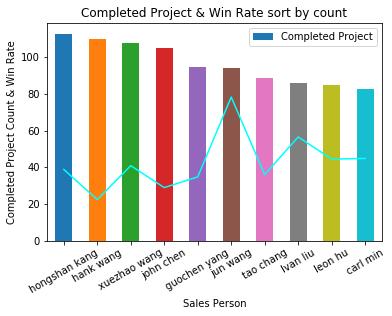

In [107]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 9)
countc.plot.bar(x='sales_name',y='Completed Project')

plt.plot(countc['sales_name'],countc['win rate'], color='cyan')

plt.xticks(rotation=30)

plt.xlabel('Sales Person')
plt.ylabel('Completed Project Count & Win Rate')
plt.title('Completed Project & Win Rate sort by count')
plt.savefig('Completed Project Count & Win Rate by count.png')

In [108]:
countw = count.sort_values(by=['win rate','Completed'],ascending=[False,False])
countw = countw.rename(columns={'Completed':'Completed Project'})
countw = countw[:10]

<Figure size 648x648 with 0 Axes>

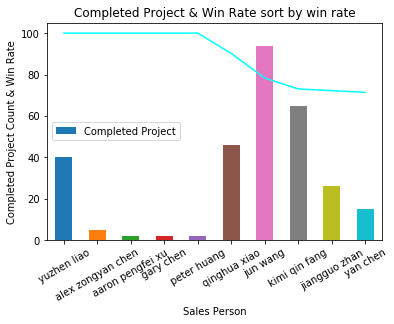

In [109]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 9)
countw.plot.bar(x='sales_name',y='Completed Project')
#countc['win rate'].plot(secondary_y=True)
plt.plot(countw['sales_name'],countw['win rate'], color='cyan')
#plt.scatter(countc['sales_name'],countc['win rate'])
plt.xticks(rotation=30)

plt.xlabel('Sales Person')
plt.ylabel('Completed Project Count & Win Rate')
plt.title('Completed Project & Win Rate sort by win rate')
plt.savefig('Completed Project Count & Win Rate by rate.png')

In [110]:
#sales = df['Sales Annualized_cor(M)'].groupby(df['sales_name']).sum()

sales = pd.pivot_table(df, index=['sales_name'], columns=['Project Status'], values = 'Sales Annualized_cor(M)', aggfunc=np.sum)

sales = sales.reset_index()

sales = sales.fillna(0)
sales = sales.drop(['Active'],axis=1)
sales['Sum'] = sales.sum(axis = 1, skipna = True)
sales['win rate'] = round(sales['Completed']/sales['Sum']*100, 2)
#sales


In [111]:
salesc = sales.sort_values(by=['Completed','win rate'],ascending=[False,False])
salesc = salesc[:10]
salesc

Project Status    sales_name  Cancelled  Completed        Sum  win rate
114                  vito wu  10.738199  14.353130  25.091329     57.20
35                 hank wang  12.675258   8.418656  21.093914     39.91
41                   hui luo   6.948996   5.197143  12.146139     42.79
55                 john chen  11.089224   5.102070  16.191293     31.51
31              guochen yang   8.172826   4.875036  13.047863     37.36
11               benjamin li   5.285714   4.579317   9.865031     46.42
118             xuezhao wang   5.991963   4.072005  10.063968     40.46
125                 yun wang   2.377391   3.233416   5.610807     57.63
107                tao chang   4.032020   2.617841   6.649861     39.37
87                 philip ou   1.353694   2.553011   3.906705     65.35

In [149]:
count1 = count.rename(columns={'sales_name':'sales_name_c','Cancelled':'Cancelled_c','Completed':'Completed_c','Sum':'Sum_c','win rate':'win rate_c'})
sales1 = sales.rename(columns={'Completed':'Gained NES'})
count_sales = pd.concat([count1, sales1], axis=1)
count_sales = pd.DataFrame(count_sales)
count_sales['win rate delta'] = count_sales['win rate'] - count_sales['win rate_c']

In [142]:
count_salesw = count_sales.sort_values(by=['Gained NES','win rate_c','Completed_c'],ascending=[False,False,False])
count_salesw = count_salesw[:30]
count_salesw

Project Status   sales_name_c  Cancelled_c  Completed_c  Sum_c  win rate_c  \
114                   vito wu         93.0         70.0  163.0       42.94   
35                  hank wang        381.0        110.0  491.0       22.40   
41                    hui luo        141.0         72.0  213.0       33.80   
55                  john chen        258.0        105.0  363.0       28.93   
31               guochen yang        178.0         95.0  273.0       34.80   
11                benjamin li         29.0         27.0   56.0       48.21   
118              xuezhao wang        156.0        108.0  264.0       40.91   
125                  yun wang         39.0         11.0   50.0       22.00   
107                 tao chang        158.0         89.0  247.0       36.03   
87                  philip ou         34.0         74.0  108.0       68.52   
16                   carl min        102.0         83.0  185.0       44.86   
52                jiaxing yan         36.0         23.0   59.0       38.98   
38                 hongjun gu        124.0         40.0  164.0       24.39   
10                baolin peng        133.0         52.0  185.0       28.11   
6                  andy zhang         67.0         34.0  101.0       33.66   
72                   max chen         23.0         20.0   43.0       46.51   
117                wuzhong ai        100.0         81.0  181.0       44.75   
101               simon zheng         73.0         42.0  115.0       36.52   
81                   noel wen         36.0         24.0   60.0       40.00   
63                   kollo gu        197.0         37.0  234.0       15.81   
47                   jesse xu        264.0         75.0  339.0       22.12   
58                    kari su         71.0         69.0  140.0       49.29   
102                 sky huang         48.0         22.0   70.0       31.43   
45                  jason luo        102.0         65.0  167.0       38.92   
83              patrick zhong         17.0         19.0   36.0       52.78   
40              hongshan kang        178.0        113.0  291.0       38.83   
28                gaven zhang         77.0         55.0  132.0       41.67   
128                  zegan yu         83.0         35.0  118.0       29.66   
70                   lvan liu         66.0         86.0  152.0       56.58   
123              yitong zhang         51.0         14.0   65.0       21.54   

Project Status     sales_name  Cancelled  Gained NES        Sum  win rate  
114                   vito wu  10.738199   14.353130  25.091329     57.20  
35                  hank wang  12.675258    8.418656  21.093914     39.91  
41                    hui luo   6.948996    5.197143  12.146139     42.79  
55                  john chen  11.089224    5.102070  16.191293     31.51  
31               guochen yang   8.172826    4.875036  13.047863     37.36  
11                benjamin li   5.285714    4.579317   9.865031     46.42  
118              xuezhao wang   5.991963    4.072005  10.063968     40.46  
125                  yun wang   2.377391    3.233416   5.610807     57.63  
107                 tao chang   4.032020    2.617841   6.649861     39.37  
87                  philip ou   1.353694    2.553011   3.906705     65.35  
16                   carl min   1.745473    2.254846   4.000319     56.37  
52                jiaxing yan   1.427366    2.219857   3.647224     60.86  
38                 hongjun gu   3.760994    2.180460   5.941453     36.70  
10                baolin peng   3.910934    2.144384   6.055318     35.41  
6                  andy zhang   4.909817    2.070916   6.980733     29.67  
72                   max chen   1.398221    1.895570   3.293791     57.55  
117                wuzhong ai   2.367570    1.891315   4.258885     44.41  
101               simon zheng   3.530816    1.890320   5.421137     34.87  
81                   noel wen   1.512112    1.872298   3.384410     55.32  
63                   kollo gu   8.130879    1.854712   9.9855

<Figure size 648x648 with 0 Axes>

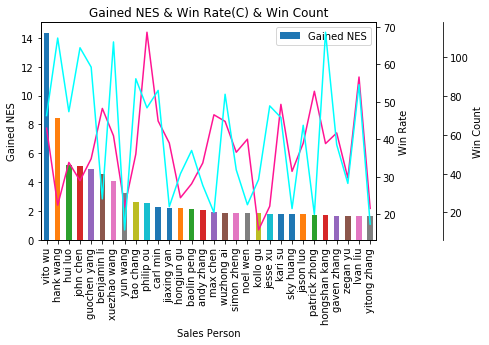

In [143]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 9)
ax1 = count_salesw.plot.bar(x='sales_name',y='Gained NES')
ax1.tick_params(axis='y')
ax1.set_xlabel('Sales Person')
ax1.set_ylabel('Gained NES')

ax2 = ax1.twinx()
ax2.set_ylabel('Win Rate')
ax2.plot(count_salesw['sales_name'],count_salesw['win rate_c'], color='deeppink')
#ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
ax2.tick_params(axis='y')
#ax2.legend('Win Rate')

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
ax3.plot(count_salesw['sales_name'],count_salesw['Completed_c'], color='cyan')
ax3.set_ylabel('Win Count')
#ax3.legend('Win Count')

#ax4 = ax1.twinx()
#ax4.spines["right"].set_position(("axes", 1.4))
#ax4.set_ylabel('Total Count')
#ax4.plot(count_salesw['sales_name'],count_salesw['Sum_c'], color='g')


fig.tight_layout()

#plt.legend(['5%', '10%', '30%','60%','90%','100%'], loc='upper right')
#plt.legend(['NES','Win Rate','Win Count','Total Count'], loc='upper right')
plt.title('Gained NES & Win Rate(C) & Win Count')
plt.savefig('Gained NES & Win Rate(C) & Win Count.png')

<Figure size 648x648 with 0 Axes>

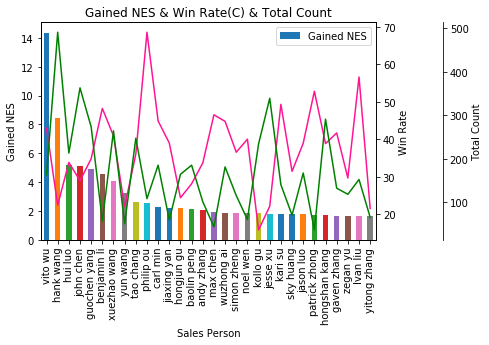

In [144]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 9)
ax1 = count_salesw.plot.bar(x='sales_name',y='Gained NES')
ax1.tick_params(axis='y')
ax1.set_xlabel('Sales Person')
ax1.set_ylabel('Gained NES')

ax2 = ax1.twinx()
ax2.set_ylabel('Win Rate')
ax2.plot(count_salesw['sales_name'],count_salesw['win rate_c'], color='deeppink')
#ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
ax2.tick_params(axis='y')
#ax2.legend('Win Rate')

#ax3 = ax1.twinx()
#ax3.spines["right"].set_position(("axes", 1.2))
#ax3.plot(count_salesw['sales_name'],count_salesw['Completed_c'], color='cyan')
#ax3.set_ylabel('Win Count')
#ax3.legend('Win Count')

ax4 = ax1.twinx()
ax4.spines["right"].set_position(("axes", 1.2))
ax4.set_ylabel('Total Count')
ax4.plot(count_salesw['sales_name'],count_salesw['Sum_c'], color='g')


fig.tight_layout()

#plt.legend(['5%', '10%', '30%','60%','90%','100%'], loc='upper right')
#plt.legend(['NES','Win Rate','Win Count','Total Count'], loc='upper right')
plt.title('Gained NES & Win Rate(C) & Total Count')
plt.savefig('Gained NES & Win Rate(C) & Total Count.png')

In [155]:
count_saless = count_sales.sort_values(by=['Gained NES','win rate','Completed_c'],ascending=[False,False,False])
count_saless = count_saless[:50]
count_saless

Project Status   sales_name_c  Cancelled_c  Completed_c  Sum_c  win rate_c  \
114                   vito wu         93.0         70.0  163.0       42.94   
35                  hank wang        381.0        110.0  491.0       22.40   
41                    hui luo        141.0         72.0  213.0       33.80   
55                  john chen        258.0        105.0  363.0       28.93   
31               guochen yang        178.0         95.0  273.0       34.80   
11                benjamin li         29.0         27.0   56.0       48.21   
118              xuezhao wang        156.0        108.0  264.0       40.91   
125                  yun wang         39.0         11.0   50.0       22.00   
107                 tao chang        158.0         89.0  247.0       36.03   
87                  philip ou         34.0         74.0  108.0       68.52   
16                   carl min        102.0         83.0  185.0       44.86   
52                jiaxing yan         36.0         23.0   59.0       38.98   
38                 hongjun gu        124.0         40.0  164.0       24.39   
10                baolin peng        133.0         52.0  185.0       28.11   
6                  andy zhang         67.0         34.0  101.0       33.66   
72                   max chen         23.0         20.0   43.0       46.51   
117                wuzhong ai        100.0         81.0  181.0       44.75   
101               simon zheng         73.0         42.0  115.0       36.52   
81                   noel wen         36.0         24.0   60.0       40.00   
63                   kollo gu        197.0         37.0  234.0       15.81   
47                   jesse xu        264.0         75.0  339.0       22.12   
58                    kari su         71.0         69.0  140.0       49.29   
102                 sky huang         48.0         22.0   70.0       31.43   
45                  jason luo        102.0         65.0  167.0       38.92   
83              patrick zhong         17.0         19.0   36.0       52.78   
40              hongshan kang        178.0        113.0  291.0       38.83   
28                gaven zhang         77.0         55.0  132.0       41.67   
128                  zegan yu         83.0         35.0  118.0       29.66   
70                   lvan liu         66.0         86.0  152.0       56.58   
123              yitong zhang         51.0         14.0   65.0       21.54   
59                kelvin tian         52.0         25.0   77.0       32.47   
108                 tao liang        109.0         32.0  141.0       22.70   
66                    leon hu        106.0         85.0  191.0       44.50   
68                 lijun zhou        103.0         58.0  161.0       36.02   
112                   tom pan         32.0         14.0   46.0       30.43   
36                   hekai ni         83.0         59.0  142.0       41.55   
48                    jian li         46.0         10.0   56.0       17.86   
65                   leo ling         42.0         32.0   74.0       43.24   
69                 louin yang         63.0         26.0   89.0       29.21   
62              kimi qin fang         24.0         65.0   89.0       73.03   
73                    max shi         84.0         25.0  109.0       22.94   
122                yidong sun        136.0         33.0  169.0       19.53   
96                  sandy liu        156.0         61.0  217.0       28.11   
50              jiangguo zhan         10.0         26.0   36.0       72.22   
20                 delong xia         69.0         44.0  113.0       38.94   
75                    mike li         58.0         49.0  107.0       45.79   
111                tiger song         62.0         41.0  103.0       39.81   
119                 yale fang         13.0         12.0   25.0       48.00   
9                  arvin wang         65.0         38.0  103.0       36.89   
23               fengjuan zou         26.0         21.0   47.0       44.68   

Project Status     sa

<Figure size 648x648 with 0 Axes>

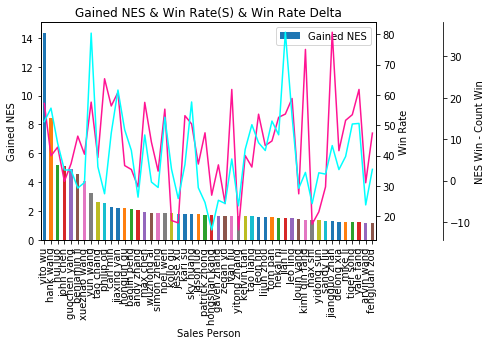

In [156]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 9)
ax1 = count_saless.plot.bar(x='sales_name',y='Gained NES')
ax1.tick_params(axis='y')
ax1.set_xlabel('Sales Person')
ax1.set_ylabel('Gained NES')

ax2 = ax1.twinx()
ax2.set_ylabel('Win Rate')
ax2.plot(count_saless['sales_name'],count_saless['win rate'], color='deeppink')
#ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
ax2.tick_params(axis='y')
#ax2.legend('Win Rate')

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
ax3.plot(count_saless['sales_name'],count_saless['win rate delta'], color='cyan')
ax3.set_ylabel('NES Win - Count Win')
#ax3.legend('Win Count')

#ax4 = ax1.twinx()
#ax4.spines["right"].set_position(("axes", 1.4))
#ax4.set_ylabel('Total Count')
#ax4.plot(count_salesw['sales_name'],count_salesw['Sum_c'], color='g')


fig.tight_layout()

#plt.legend(['5%', '10%', '30%','60%','90%','100%'], loc='upper right')
#plt.legend(['NES','Win Rate','Win Count','Total Count'], loc='upper right')
plt.title('Gained NES & Win Rate(S) & Win Rate Delta')
plt.savefig('Gained NES & Win Rate(S) & Win Rate Delta.png')

<Figure size 648x648 with 0 Axes>

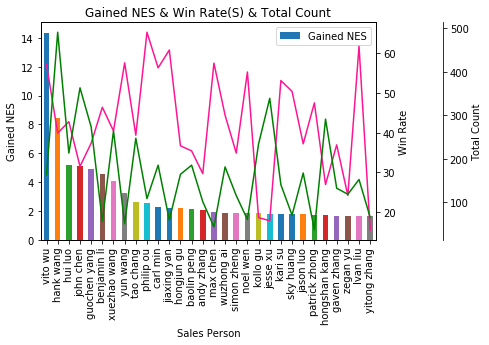

In [147]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(9, 9)
ax1 = count_saless.plot.bar(x='sales_name',y='Gained NES')
ax1.tick_params(axis='y')
ax1.set_xlabel('Sales Person')
ax1.set_ylabel('Gained NES')

ax2 = ax1.twinx()
ax2.set_ylabel('Win Rate')
ax2.plot(count_saless['sales_name'],count_saless['win rate'], color='deeppink')
#ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
ax2.tick_params(axis='y')
#ax2.legend('Win Rate')

#ax3 = ax1.twinx()
#ax3.spines["right"].set_position(("axes", 1.2))
#ax3.plot(count_salesw['sales_name'],count_salesw['Completed_c'], color='cyan')
#ax3.set_ylabel('Win Count')
#ax3.legend('Win Count')

ax4 = ax1.twinx()
ax4.spines["right"].set_position(("axes", 1.2))
ax4.set_ylabel('Total Count')
ax4.plot(count_saless['sales_name'],count_saless['Sum_c'], color='g')


fig.tight_layout()

#plt.legend(['5%', '10%', '30%','60%','90%','100%'], loc='upper right')
#plt.legend(['NES','Win Rate','Win Count','Total Count'], loc='upper right')
plt.title('Gained NES & Win Rate(S) & Total Count')
plt.savefig('Gained NES & Win Rate(S) & Total Count.png')

In [119]:
#df['2019 Margin']

profit = pd.pivot_table(df, index=['sales_name'], columns=['Project Status'], values = 'Profit(M)', aggfunc=np.sum)

profit = profit.reset_index()

profit = profit.fillna(0)
profit = profit.drop(['Active'],axis=1)
profit['Sum'] = profit.sum(axis = 1, skipna = True)
profit['win rate'] = round(profit['Completed']/profit['Sum']*100, 2)
profit

Project Status           sales_name  Cancelled  Completed        Sum  win rate
0                  aaron pengfei xu   0.000000   0.003494   0.003494    100.00
1                        adam zheng   0.317293   0.174086   0.491379     35.43
2                        adams jiao   0.139014   0.168678   0.307692     54.82
3                        alan zheng   1.596118   0.093014   1.689131      5.51
4                 alex zongyan chen   0.000000   0.065482   0.065482    100.00
5                          an jiang   0.013895   0.328329   0.342223     95.94
6                        andy zhang   0.450504   0.288722   0.739226     39.06
7                          anke cai   0.085451   0.101561   0.187012     54.31
8                        anthony hu   0.156042   0.214420   0.370463     57.88
9                        arvin wang   0.400519   0.210895   0.611414     34.49
10                      baolin peng   0.637106   0.313770   0.950876     33.00
11                      benjamin li   0.400704   0.684220   1.084924     63.07
12                        benny liu   0.001834   0.000342   0.002175     15.71
13                bill guobiao zhou   0.000000   0.000000   0.000000       NaN
14                       boey huang   0.108785   0.125465   0.234250     53.56
15                      calvin wang  -0.132802   0.038699  -0.094103    -41.12
16                         carl min   0.266911   0.356169   0.623080     57.16
17                  changping zhang   0.228146   0.064963   0.293108     22.16
18                        cheng liu   0.398080   0.100787   0.498867     20.20
19                         danny xu   0.421902   0.152855   0.574758     26.59
20                       delong xia   0.169900   0.087360   0.257259     33.96
21                        east wang   0.076543   0.047597   0.124139     38.34
22                         eric shi   0.238948   0.140669   0.379617     37.06
23                     fengjuan zou   0.113507   0.081820   0.195327     41.89
24                         frank li   0.007552   0.000000   0.007552      0.00
25                        frank lou   0.111618   0.111381   0.222999     49.95
26                        fred song   0.000000   0.000000   0.000000       NaN
27                        gary chen   0.000000   0.015714   0.015714    100.00
28                      gaven zhang   0.178059   0.117502   0.295561     39.76
29                     gengxin yang   0.310715   0.074881   0.385597     19.42
30                      guangzhe li   0.065307   0.063907   0.129214     49.46
31                     guochen yang   0.772992   0.583999   1.356991     43.04
32                        guohua gu   0.588175   0.097039   0.685215     14.16
33                       haihui pan   0.161043   0.092065   0.253108     36.37
34                    hairong huang   0.051953   0.125332   0.177285     70.70
35                        hank wang   1.487609   1.059174   2.546783     41.59
36                         hekai ni   0.808647   0.161773   0.970420     16.67
37                       henry tang  -0.915056   0.128390  -0.786666    -16.32
38                       hongjun gu   0.486967   0.311122   0.798089     38.98
39                      hongqiao li   0.102459   0.179234   0.281693     63.63
40                    hongshan kang   0.388417  -0.297158   0.091259   -325.62
41                          hui luo   0.665208   0.555501   1.220709     45.51
42                ivan yuanfeng you -18.239764   0.000000 -18.239764     -0.00
43                      james chien   0.004183   0.006202   0.010386     59.72
44                         james li   0.519123   0.040475   0.559598      7.23
45                        jason luo   0.373128   0.253489   0.626617     40.45
46                           jay li   0.057109   0.018567   0.075676     24.53
47                         jesse xu   0.666248   0.255027   0.921275     27.68
48                          jian li   0.138358   0.021158   0.159516     13.26
49                     jianfang liu   0.000042   0

In [120]:
profitw = profit.rename(columns={'Completed':'Gained Profit'})
profitw = profitw.sort_values(by=['Gained Profit','win rate',],ascending=[False,False])
#profitw = profitw.sort_values(by=['sales_name'])
#profitw = profitww.groupby(profitw['sales_name']).sum()
#profitw = profitw[:10]
profitw

Project Status           sales_name  Cancelled  Gained Profit        Sum  \
114                         vito wu   1.092520       3.479801   4.572321   
35                        hank wang   1.487609       1.059174   2.546783   
55                        john chen   1.474536       0.733251   2.207787   
11                      benjamin li   0.400704       0.684220   1.084924   
118                    xuezhao wang   0.833430       0.647081   1.480511   
31                     guochen yang   0.772992       0.583999   1.356991   
41                          hui luo   0.665208       0.555501   1.220709   
125                        yun wang   0.189556       0.447867   0.637423   
101                     simon zheng   0.624766       0.415043   1.039808   
123                    yitong zhang   1.562630       0.373337   1.935967   
87                        philip ou   0.015581       0.368831   0.384412   
16                         carl min   0.266911       0.356169   0.623080   
5                          an jiang   0.013895       0.328329   0.342223   
68                       lijun zhou   0.329683       0.320546   0.650229   
107                       tao chang   0.262742       0.318253   0.580995   
10                      baolin peng   0.637106       0.313770   0.950876   
38                       hongjun gu   0.486967       0.311122   0.798089   
6                        andy zhang   0.450504       0.288722   0.739226   
72                         max chen   0.234431       0.281793   0.516223   
47                         jesse xu   0.666248       0.255027   0.921275   
45                        jason luo   0.373128       0.253489   0.626617   
122                      yidong sun   0.870139       0.243271   1.113409   
62                    kimi qin fang   0.086800       0.241859   0.328659   
69                       louin yang   0.416499       0.234410   0.650910   
65                         leo ling   0.175927       0.231602   0.407529   
66                          leon hu   0.198928       0.230490   0.429418   
117                      wuzhong ai   0.243576       0.224878   0.468454   
8                        anthony hu   0.156042       0.214420   0.370463   
108                       tao liang   0.331618       0.211974   0.543592   
9                        arvin wang   0.400519       0.210895   0.611414   
58                          kari su   0.171004       0.209863   0.380867   
59                      kelvin tian   0.234036       0.201615   0.435651   
96                        sandy liu   0.328874       0.196047   0.524921   
86                       philip liu   0.011701       0.189728   0.201430   
102                       sky huang   0.200211       0.188526   0.388736   
83                    patrick zhong   0.282122       0.188379   0.470501   
50                    jiangguo zhan   0.046464       0.185617   0.232081   
116                   weituan zhang   0.297000       0.181850   0.478850   
111                      tiger song   0.143803       0.179892   0.323695   
81                         noel wen   0.098709       0.179784   0.278493   
39                      hongqiao li   0.102459       0.179234   0.281693   
1                        adam zheng   0.317293       0.174086   0.491379   
2                        adams jiao   0.139014       0.168678   0.307692   
70                         lvan liu   0.084861       0.164557   0.249418   
36                         hekai ni   0.808647       0.161773   0.970420   
63                         kollo gu   1.039223       0.152894   1.192117   
19                         danny xu   0.421902       0.152855   0.574758   
76                          min xie   0.206479       0.149773   0.356251   
51                   jiansong zheng   0.119997       0.140852   0.260850   
57                           kai di   0.424746       0.140800   0.565545   
22                         eric shi   0.238948       0.140669   0.379617   
56                         jun wang   0.056640  

In [121]:
sales

Project Status           sales_name  Cancelled  Completed        Sum  win rate
0                  aaron pengfei xu   0.000000   0.049689   0.049689    100.00
1                        adam zheng   2.330035   0.668820   2.998855     22.30
2                        adams jiao   1.323839   1.076398   2.400236     44.85
3                        alan zheng   3.039086   0.718483   3.757569     19.12
4                 alex zongyan chen   0.000000   0.226180   0.226180    100.00
5                          an jiang   0.075476   0.963666   1.039142     92.74
6                        andy zhang   4.909817   2.070916   6.980733     29.67
7                          anke cai   0.797086   0.807734   1.604820     50.33
8                        anthony hu  12.254962   1.054482  13.309444      7.92
9                        arvin wang   2.561242   1.152186   3.713429     31.03
10                      baolin peng   3.910934   2.144384   6.055318     35.41
11                      benjamin li   5.285714   4.579317   9.865031     46.42
12                        benny liu   0.010448   0.005242   0.015690     33.41
13                bill guobiao zhou   0.000000   0.000000   0.000000       NaN
14                       boey huang   0.812036   1.096986   1.909022     57.46
15                      calvin wang   1.817298   0.663789   2.481087     26.75
16                         carl min   1.745473   2.254846   4.000319     56.37
17                  changping zhang   1.736910   0.501229   2.238139     22.39
18                        cheng liu   1.981720   0.735642   2.717362     27.07
19                         danny xu   3.495317   0.833205   4.328522     19.25
20                       delong xia   1.765662   1.258474   3.024135     41.61
21                        east wang   0.727106   0.529990   1.257096     42.16
22                         eric shi   2.183043   0.926708   3.109752     29.80
23                     fengjuan zou   1.271925   1.146567   2.418492     47.41
24                         frank li   0.096286   0.000000   0.096286      0.00
25                        frank lou   0.894410   0.678402   1.572812     43.13
26                        fred song   0.000000   0.000000   0.000000       NaN
27                        gary chen   0.000000   0.073292   0.073292    100.00
28                      gaven zhang   2.874745   1.683130   4.557876     36.93
29                     gengxin yang   1.883081   0.791553   2.674634     29.59
30                      guangzhe li   0.823599   0.264812   1.088411     24.33
31                     guochen yang   8.172826   4.875036  13.047863     37.36
32                        guohua gu   3.835404   0.542981   4.378385     12.40
33                       haihui pan   1.166845   0.482298   1.649143     29.25
34                    hairong huang   0.165801   0.651512   0.817313     79.71
35                        hank wang  12.675258   8.418656  21.093914     39.91
36                         hekai ni   1.347373   1.496489   2.843862     52.62
37                       henry tang   0.795404   0.542837   1.338241     40.56
38                       hongjun gu   3.760994   2.180460   5.941453     36.70
39                      hongqiao li   2.661453   0.873826   3.535280     24.72
40                    hongshan kang   4.580328   1.687840   6.268168     26.93
41                          hui luo   6.948996   5.197143  12.146139     42.79
42                ivan yuanfeng you   0.584099   0.000000   0.584099      0.00
43                      james chien   0.048447   0.018634   0.067081     27.78
44                         james li   1.891095   0.154022   2.045118      7.53
45                        jason luo   2.978248   1.763947   4.742195     37.20
46                           jay li   0.451019   0.191200   0.642219     29.77
47                         jesse xu   8.391368   1.815510  10.206878     17.79
48                          jian li   1.286081   1.491684   2.777766     53.70
49                     jianfang liu   0.028898   0

In [122]:
profit1 = profit.rename(columns={'sales_name':'sales_name_m','Cancelled':'Cancelled_m','Completed':'Gained Profit','Sum':'Sum_m','win rate':'win rate_m'})
sales1 = sales.rename(columns={'Completed':'Gained NES'})
profit_sales = pd.concat([profit1, sales1], axis=1)
profit_sales = pd.DataFrame(profit_sales)
profit_sales

Project Status         sales_name_m  Cancelled_m  Gained Profit      Sum_m  \
0                  aaron pengfei xu     0.000000       0.003494   0.003494   
1                        adam zheng     0.317293       0.174086   0.491379   
2                        adams jiao     0.139014       0.168678   0.307692   
3                        alan zheng     1.596118       0.093014   1.689131   
4                 alex zongyan chen     0.000000       0.065482   0.065482   
5                          an jiang     0.013895       0.328329   0.342223   
6                        andy zhang     0.450504       0.288722   0.739226   
7                          anke cai     0.085451       0.101561   0.187012   
8                        anthony hu     0.156042       0.214420   0.370463   
9                        arvin wang     0.400519       0.210895   0.611414   
10                      baolin peng     0.637106       0.313770   0.950876   
11                      benjamin li     0.400704       0.684220   1.084924   
12                        benny liu     0.001834       0.000342   0.002175   
13                bill guobiao zhou     0.000000       0.000000   0.000000   
14                       boey huang     0.108785       0.125465   0.234250   
15                      calvin wang    -0.132802       0.038699  -0.094103   
16                         carl min     0.266911       0.356169   0.623080   
17                  changping zhang     0.228146       0.064963   0.293108   
18                        cheng liu     0.398080       0.100787   0.498867   
19                         danny xu     0.421902       0.152855   0.574758   
20                       delong xia     0.169900       0.087360   0.257259   
21                        east wang     0.076543       0.047597   0.124139   
22                         eric shi     0.238948       0.140669   0.379617   
23                     fengjuan zou     0.113507       0.081820   0.195327   
24                         frank li     0.007552       0.000000   0.007552   
25                        frank lou     0.111618       0.111381   0.222999   
26                        fred song     0.000000       0.000000   0.000000   
27                        gary chen     0.000000       0.015714   0.015714   
28                      gaven zhang     0.178059       0.117502   0.295561   
29                     gengxin yang     0.310715       0.074881   0.385597   
30                      guangzhe li     0.065307       0.063907   0.129214   
31                     guochen yang     0.772992       0.583999   1.356991   
32                        guohua gu     0.588175       0.097039   0.685215   
33                       haihui pan     0.161043       0.092065   0.253108   
34                    hairong huang     0.051953       0.125332   0.177285   
35                        hank wang     1.487609       1.059174   2.546783   
36                         hekai ni     0.808647       0.161773   0.970420   
37                       henry tang    -0.915056       0.128390  -0.786666   
38                       hongjun gu     0.486967       0.311122   0.798089   
39                      hongqiao li     0.102459       0.179234   0.281693   
40                    hongshan kang     0.388417      -0.297158   0.091259   
41                          hui luo     0.665208       0.555501   1.220709   
42                ivan yuanfeng you   -18.239764       0.000000 -18.239764   
43                      james chien     0.004183       0.006202   0.010386   
44                         james li     0.519123       0.040475   0.559598   
45                        jason luo     0.373128       0.253489   0.626617   
46                           jay li     0.057109       0.018567   0.075676   
47                         jesse xu     0.666248       0.255027   0.921275   
48                          jian li     0.138358       0.021158   0.159516   
49                     jianfang liu     0.000042       0.010374   0.010417   
50                    

In [123]:
profit_salesw = profit_sales.sort_values(by=['Gained NES','win rate','Gained Profit'],ascending=[False,False,False])
profit_salesw = profit_salesw[:10]
profit_salesw

Project Status  sales_name_m  Cancelled_m  Gained Profit     Sum_m  \
114                  vito wu     1.092520       3.479801  4.572321   
35                 hank wang     1.487609       1.059174  2.546783   
41                   hui luo     0.665208       0.555501  1.220709   
55                 john chen     1.474536       0.733251  2.207787   
31              guochen yang     0.772992       0.583999  1.356991   
11               benjamin li     0.400704       0.684220  1.084924   
118             xuezhao wang     0.833430       0.647081  1.480511   
125                 yun wang     0.189556       0.447867  0.637423   
107                tao chang     0.262742       0.318253  0.580995   
87                 philip ou     0.015581       0.368831  0.384412   

Project Status  win rate_m    sales_name  Cancelled  Gained NES        Sum  \
114                  76.11       vito wu  10.738199   14.353130  25.091329   
35                   41.59     hank wang  12.675258    8.418656  21.093914   
41                   45.51       hui luo   6.948996    5.197143  12.146139   
55                   33.21     john chen  11.089224    5.102070  16.191293   
31                   43.04  guochen yang   8.172826    4.875036  13.047863   
11                   63.07   benjamin li   5.285714    4.579317   9.865031   
118                  43.71  xuezhao wang   5.991963    4.072005  10.063968   
125                  70.26      yun wang   2.377391    3.233416   5.610807   
107                  54.78     tao chang   4.032020    2.617841   6.649861   
87                   95.95     philip ou   1.353694    2.553011   3.906705   

Project Status  win rate  
114                57.20  
35                 39.91  
41                 42.79  
55                 31.51  
31                 37.36  
11                 46.42  
118                40.46  
125                57.63  
107                39.37  
87                 65.35

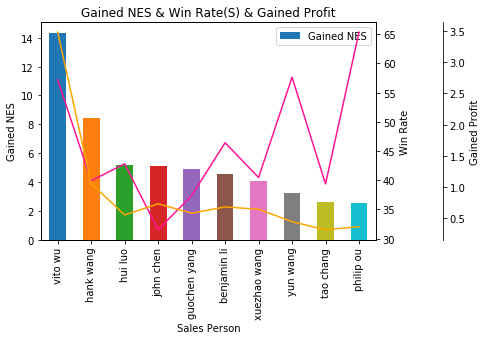

In [124]:
ax1 = profit_salesw.plot.bar(x='sales_name',y='Gained NES')
ax1.tick_params(axis='y')
ax1.set_xlabel('Sales Person')
ax1.set_ylabel('Gained NES')

ax2 = ax1.twinx()
ax2.set_ylabel('Win Rate')
ax2.plot(profit_salesw['sales_name'],profit_salesw['win rate'], color='deeppink')
#ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
ax2.tick_params(axis='y')
#ax2.legend('Win Rate')

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
ax3.plot(profit_salesw['sales_name'],profit_salesw['Gained Profit'], color='orange')
ax3.set_ylabel('Gained Profit')
#ax3.legend('Win Count')

#ax4 = ax1.twinx()
#ax4.spines["right"].set_position(("axes", 1.4))
#ax4.set_ylabel('Total Count')
#ax4.plot(count_salesw['sales_name'],count_salesw['Sum_c'], color='g')


fig.tight_layout()

#plt.legend(['5%', '10%', '30%','60%','90%','100%'], loc='upper right')
#plt.legend(['NES','Win Rate','Win Count','Total Count'], loc='upper right')
plt.title('Gained NES & Win Rate(S) & Gained Profit')
plt.savefig('Gained NES & Win Rate(S) & Gained Profit.png')

In [125]:
#salessu = pd.pivot_table(df, index=['Phase(%)','SU','sales_name'], columns=['Reason'], values = 'Sales Annualized_cor(M)', aggfunc=np.sum)
#salessu = salessu.reset_index()
#salessu = salessu[~((salessu['SU']=='AIG')|(salessu['SU']=='AIT')|(salessu['SU']=='AIZ'))]
#salessu = salessu.drop(['Relationship (Gain from competition)'],axis=1)
#salessu = salessu.fillna(0)
#salessu
#df['sales_name']

## Feature engineering

#### Categorical features

In [59]:
local_AIF = df_AIF['Account Int. Account']
local_AIF = local_AIF.fillna('Local/Int Account Unknown')
local_AIF[local_AIF=='ZZ_Local Account']='Local Account'
local_AIF[~((local_AIF=='Local Account')|(local_AIF=="Local/Int Account Unknown"))]="International Account"
local_AIF = pd.get_dummies(local_AIF)
local_AIL = df_AIL['Account Int. Account']
local_AIL = local_AIL.fillna('Local/Int Account Unknown')
local_AIL[local_AIL=='ZZ_Local Account']='Local Account'
local_AIL[~((local_AIL=='Local Account')|(local_AIL=="Local/Int Account Unknown"))]="International Account"
local_AIL = pd.get_dummies(local_AIL)
local_AIS = df_AIS['Account Int. Account']
local_AIS = local_AIS.fillna('Local/Int Account Unknown')
local_AIS[local_AIS=='ZZ_Local Account']='Local Account'
local_AIS[~((local_AIS=='Local Account')|(local_AIS=="Local/Int Account Unknown"))]="International Account"
local_AIS = pd.get_dummies(local_AIS)
local_AIC = df_AIC['Account Int. Account']
local_AIC = local_AIC.fillna('Local/Int Account Unknown')
local_AIC[local_AIC=='ZZ_Local Account']='Local Account'
local_AIC[~((local_AIC=='Local Account')|(local_AIC=="Local/Int Account Unknown"))]="International Account"
local_AIC = pd.get_dummies(local_AIC)
local_AIN = df_AIN['Account Int. Account']
local_AIN = local_AIN.fillna('Local/Int Account Unknown')
local_AIN[local_AIN=='ZZ_Local Account']='Local Account'
local_AIN[~((local_AIN=='Local Account')|(local_AIN=="Local/Int Account Unknown"))]="International Account"
local_AIN = pd.get_dummies(local_AIN)
local_AIP = df_AIP['Account Int. Account']
local_AIP = local_AIP.fillna('Local/Int Account Unknown')
local_AIP[local_AIP=='ZZ_Local Account']='Local Account'
local_AIP[~((local_AIP=='Local Account')|(local_AIP=="Local/Int Account Unknown"))]="International Account"
local_AIP = pd.get_dummies(local_AIP)
local_AIH = df_AIH['Account Int. Account']
local_AIH = local_AIH.fillna('Local/Int Account Unknown')
local_AIH[local_AIH=='ZZ_Local Account']='Local Account'
local_AIH[~((local_AIH=='Local Account')|(local_AIH=="Local/Int Account Unknown"))]="International Account"
local_AIH = pd.get_dummies(local_AIH)

In [60]:
application_L1_AIF = pd.get_dummies(df_AIF['AI Application L1']) 
application_L1_AIL = pd.get_dummies(df_AIL['AI Application L1']) 
application_L1_AIS = pd.get_dummies(df_AIS['AI Application L1']) 
application_L1_AIC = pd.get_dummies(df_AIC['AI Application L1']) 
application_L1_AIN = pd.get_dummies(df_AIN['AI Application L1']) 
application_L1_AIP = pd.get_dummies(df_AIP['AI Application L1'])
application_L1_AIH = pd.get_dummies(df_AIH['AI Application L1']) 

In [61]:
AI_Platform_AIF = pd.get_dummies(df_AIF['AI Platform'])
AI_Platform_AIL = pd.get_dummies(df_AIL['AI Platform'])
AI_Platform_AIS = pd.get_dummies(df_AIS['AI Platform'])
AI_Platform_AIC = pd.get_dummies(df_AIC['AI Platform'])
AI_Platform_AIN = pd.get_dummies(df_AIN['AI Platform'])
AI_Platform_AIP = pd.get_dummies(df_AIP['AI Platform'])
AI_Platform_AIH = pd.get_dummies(df_AIH['AI Platform'])

In [62]:
primary_brand_AIF = pd.get_dummies(df_AIF['Primary Brand']).fillna("Primary Brand Unknow")
primary_brand_AIL = pd.get_dummies(df_AIL['Primary Brand']).fillna("Primary Brand Unknow")
primary_brand_AIS = pd.get_dummies(df_AIS['Primary Brand']).fillna("Primary Brand Unknow")
primary_brand_AIC = pd.get_dummies(df_AIC['Primary Brand']).fillna("Primary Brand Unknow")
primary_brand_AIN = pd.get_dummies(df_AIN['Primary Brand']).fillna("Primary Brand Unknow")
primary_brand_AIP = pd.get_dummies(df_AIP['Primary Brand']).fillna("Primary Brand Unknow")
primary_brand_AIH = pd.get_dummies(df_AIH['Primary Brand']).fillna("Primary Brand Unknow")

In [63]:
eNACE_code_AIF = pd.get_dummies(df_AIF['eNACE Code (L6)']).fillna("eNACE Code unknown")
eNACE_code_AIL = pd.get_dummies(df_AIL['eNACE Code (L6)']).fillna("eNACE Code unknown")
eNACE_code_AIS = pd.get_dummies(df_AIS['eNACE Code (L6)']).fillna("eNACE Code unknown")
eNACE_code_AIC = pd.get_dummies(df_AIC['eNACE Code (L6)']).fillna("eNACE Code unknown")
eNACE_code_AIN = pd.get_dummies(df_AIN['eNACE Code (L6)']).fillna("eNACE Code unknown")
eNACE_code_AIP = pd.get_dummies(df_AIP['eNACE Code (L6)']).fillna("eNACE Code unknown")
eNACE_code_AIH = pd.get_dummies(df_AIH['eNACE Code (L6)']).fillna("eNACE Code unknown")

In [64]:
channel_AIF = pd.get_dummies(df_AIF['Channel']).fillna('Channel unknown')
channel_AIL = pd.get_dummies(df_AIL['Channel']).fillna('Channel unknown')
channel_AIS = pd.get_dummies(df_AIS['Channel']).fillna('Channel unknown')
channel_AIC = pd.get_dummies(df_AIC['Channel']).fillna('Channel unknown')
channel_AIN = pd.get_dummies(df_AIN['Channel']).fillna('Channel unknown')
channel_AIP = pd.get_dummies(df_AIP['Channel']).fillna('Channel unknown')
channel_AIH = pd.get_dummies(df_AIH['Channel']).fillna('Channel unknown')

In [65]:
IB_segment_AIF = pd.get_dummies(df_AIF['IB Segment'])
IB_segment_AIL = pd.get_dummies(df_AIL['IB Segment'])
IB_segment_AIS = pd.get_dummies(df_AIS['IB Segment'])
IB_segment_AIC = pd.get_dummies(df_AIC['IB Segment'])
IB_segment_AIN = pd.get_dummies(df_AIN['IB Segment'])
IB_segment_AIP = pd.get_dummies(df_AIP['IB Segment'])
IB_segment_AIH = pd.get_dummies(df_AIH['IB Segment'])

In [66]:
KAM_AIF = df_AIF['Key Account Manager'].fillna("KAM_unknown")
KAM_AIF[KAM_AIF!="KAM_unknown"]="Project with KAM"
KAM_AIF = pd.get_dummies(KAM_AIF)
KAM_AIL = df_AIL['Key Account Manager'].fillna("KAM_unknown")
KAM_AIL[KAM_AIL!="KAM_unknown"]="Project with KAM"
KAM_AIL = pd.get_dummies(KAM_AIL)
KAM_AIS = df_AIS['Key Account Manager'].fillna("KAM_unknown")
KAM_AIS[KAM_AIS!="KAM_unknown"]="Project with KAM"
KAM_AIS = pd.get_dummies(KAM_AIS)
KAM_AIC = df_AIC['Key Account Manager'].fillna("KAM_unknown")
KAM_AIC[KAM_AIC!="KAM_unknown"]="Project with KAM"
KAM_AIC = pd.get_dummies(KAM_AIC)
KAM_AIN = df_AIN['Key Account Manager'].fillna("KAM_unknown")
KAM_AIN[KAM_AIN!="KAM_unknown"]="Project with KAM"
KAM_AIN = pd.get_dummies(KAM_AIN)
KAM_AIP = df_AIP['Key Account Manager'].fillna("KAM_unknown")
KAM_AIP[KAM_AIP!="KAM_unknown"]="Project with KAM"
KAM_AIP = pd.get_dummies(KAM_AIP)
KAM_AIH = df_AIH['Key Account Manager'].fillna("KAM_unknown")
KAM_AIH[KAM_AIH!="KAM_unknown"]="Project with KAM"
KAM_AIH = pd.get_dummies(KAM_AIH)

In [67]:
legal_AIF = pd.get_dummies(df_AIF['Legal Agreements']).fillna("Legal Agreement Unsigned")
legal_AIL = pd.get_dummies(df_AIL['Legal Agreements']).fillna("Legal Agreement Unsigned")
legal_AIS = pd.get_dummies(df_AIS['Legal Agreements']).fillna("Legal Agreement Unsigned")
legal_AIC = pd.get_dummies(df_AIC['Legal Agreements']).fillna("Legal Agreement Unsigned")
legal_AIN = pd.get_dummies(df_AIN['Legal Agreements']).fillna("Legal Agreement Unsigned")
legal_AIP = pd.get_dummies(df_AIP['Legal Agreements']).fillna("Legal Agreement Unsigned")
legal_AIH = pd.get_dummies(df_AIH['Legal Agreements']).fillna("Legal Agreement Unsigned")

In [68]:
one_off_sale_AIF = pd.get_dummies(df_AIF['One-Off Sale']).fillna('not oneoff sale')
one_off_sale_AIL = pd.get_dummies(df_AIL['One-Off Sale']).fillna('not oneoff sale')
one_off_sale_AIS = pd.get_dummies(df_AIS['One-Off Sale']).fillna('not oneoff sale')
one_off_sale_AIC = pd.get_dummies(df_AIC['One-Off Sale']).fillna('not oneoff sale')
one_off_sale_AIN = pd.get_dummies(df_AIN['One-Off Sale']).fillna('not oneoff sale')
one_off_sale_AIP = pd.get_dummies(df_AIP['One-Off Sale']).fillna('not oneoff sale')
one_off_sale_AIH = pd.get_dummies(df_AIH['One-Off Sale']).fillna('not oneoff sale')

In [69]:
origin_AIF = pd.get_dummies(df_AIF['Origin']).fillna('origin unknown')
origin_AIL = pd.get_dummies(df_AIL['Origin']).fillna('origin unknown')
origin_AIS = pd.get_dummies(df_AIS['Origin']).fillna('origin unknown')
origin_AIC = pd.get_dummies(df_AIC['Origin']).fillna('origin unknown')
origin_AIN = pd.get_dummies(df_AIN['Origin']).fillna('origin unknown')
origin_AIP = pd.get_dummies(df_AIP['Origin']).fillna('origin unknown')
origin_AIH = pd.get_dummies(df_AIH['Origin']).fillna('origin unknown')

In [70]:
product_type_AIF = pd.get_dummies(df_AIF['Product Type']).fillna('product type unknown')
product_type_AIL = pd.get_dummies(df_AIL['Product Type']).fillna('product type unknown')
product_type_AIS = pd.get_dummies(df_AIS['Product Type']).fillna('product type unknown')
product_type_AIC = pd.get_dummies(df_AIC['Product Type']).fillna('product type unknown')
product_type_AIN = pd.get_dummies(df_AIN['Product Type']).fillna('product type unknown')
product_type_AIP = pd.get_dummies(df_AIP['Product Type']).fillna('product type unknown')
product_type_AIH = pd.get_dummies(df_AIH['Product Type']).fillna('product type unknown')

In [71]:
project_group_AIF = pd.get_dummies(df_AIF['Project Group']).fillna('project group unknown')
project_group_AIL = pd.get_dummies(df_AIL['Project Group']).fillna('project group unknown')
project_group_AIS = pd.get_dummies(df_AIS['Project Group']).fillna('project group unknown')
project_group_AIC = pd.get_dummies(df_AIC['Project Group']).fillna('project group unknown')
project_group_AIN = pd.get_dummies(df_AIN['Project Group']).fillna('project group unknown')
project_group_AIP = pd.get_dummies(df_AIP['Project Group']).fillna('project group unknown')
project_group_AIH = pd.get_dummies(df_AIH['Project Group']).fillna('project group unknown')

In [72]:
SBU_attribute_AIF = pd.get_dummies(df_AIF['SBU Attribute'])
SBU_attribute_AIL = pd.get_dummies(df_AIL['SBU Attribute'])
SBU_attribute_AIS = pd.get_dummies(df_AIS['SBU Attribute'])
SBU_attribute_AIC = pd.get_dummies(df_AIC['SBU Attribute'])
SBU_attribute_AIN = pd.get_dummies(df_AIN['SBU Attribute'])
SBU_attribute_AIP = pd.get_dummies(df_AIP['SBU Attribute'])
SBU_attribute_AIH = pd.get_dummies(df_AIH['SBU Attribute'])

In [73]:
spec_in_AIF = pd.get_dummies(df_AIF['Spec In']).fillna('not spec in')
spec_in_AIL = pd.get_dummies(df_AIL['Spec In']).fillna('not spec in')
spec_in_AIS = pd.get_dummies(df_AIS['Spec In']).fillna('not spec in')
spec_in_AIC = pd.get_dummies(df_AIC['Spec In']).fillna('not spec in')
spec_in_AIN = pd.get_dummies(df_AIN['Spec In']).fillna('not spec in')
spec_in_AIP = pd.get_dummies(df_AIP['Spec In']).fillna('not spec in')
spec_in_AIH = pd.get_dummies(df_AIH['Spec In']).fillna('not spec in')

In [74]:
stratetic_market_segment_AIF = pd.get_dummies(df_AIF['Strategic Market Segment']).fillna('market segment unknown')
stratetic_market_segment_AIL = pd.get_dummies(df_AIL['Strategic Market Segment']).fillna('market segment unknown')
stratetic_market_segment_AIS = pd.get_dummies(df_AIS['Strategic Market Segment']).fillna('market segment unknown')
stratetic_market_segment_AIC = pd.get_dummies(df_AIC['Strategic Market Segment']).fillna('market segment unknown')
stratetic_market_segment_AIN = pd.get_dummies(df_AIN['Strategic Market Segment']).fillna('market segment unknown')
stratetic_market_segment_AIP = pd.get_dummies(df_AIP['Strategic Market Segment']).fillna('market segment unknown')
stratetic_market_segment_AIH = pd.get_dummies(df_AIH['Strategic Market Segment']).fillna('market segment unknown')

In [75]:
stratetic_market_subsegment_AIF = pd.get_dummies(df_AIF['Strategic Market Subsegment']).fillna('market subsegment unknown')
stratetic_market_subsegment_AIL = pd.get_dummies(df_AIL['Strategic Market Subsegment']).fillna('market subsegment unknown')
stratetic_market_subsegment_AIS = pd.get_dummies(df_AIS['Strategic Market Subsegment']).fillna('market subsegment unknown')
stratetic_market_subsegment_AIC = pd.get_dummies(df_AIC['Strategic Market Subsegment']).fillna('market subsegment unknown')
stratetic_market_subsegment_AIN = pd.get_dummies(df_AIN['Strategic Market Subsegment']).fillna('market subsegment unknown')
stratetic_market_subsegment_AIP = pd.get_dummies(df_AIP['Strategic Market Subsegment']).fillna('market subsegment unknown')
stratetic_market_subsegment_AIH = pd.get_dummies(df_AIH['Strategic Market Subsegment']).fillna('market subsegment unknown')

In [76]:
tech_service_AIF = df_AIF['Technical Service'].fillna("Technical Services unknown")
tech_service_AIF[tech_service_AIF!='Technical Services unknown']='technical services applied'
tech_service_AIL = df_AIL['Technical Service'].fillna("Technical Services unknown")
tech_service_AIL[tech_service_AIL!='Technical Services unknown']='technical services applied'
tech_service_AIS = df_AIS['Technical Service'].fillna("Technical Services unknown")
tech_service_AIS[tech_service_AIS!='Technical Services unknown']='technical services applied'
tech_service_AIC = df_AIC['Technical Service'].fillna("Technical Services unknown")
tech_service_AIC[tech_service_AIC!='Technical Services unknown']='technical services applied'
tech_service_AIN = df_AIN['Technical Service'].fillna("Technical Services unknown")
tech_service_AIN[tech_service_AIN!='Technical Services unknown']='technical services applied'
tech_service_AIP = df_AIP['Technical Service'].fillna("Technical Services unknown")
tech_service_AIP[tech_service_AIP!='Technical Services unknown']='technical services applied'
tech_service_AIH = df_AIH['Technical Service'].fillna("Technical Services unknown")
tech_service_AIH[tech_service_AIH!='Technical Services unknown']='technical services applied'

In [77]:
tech_service_AIF = pd.get_dummies(tech_service_AIF)
tech_service_AIL = pd.get_dummies(tech_service_AIL)
tech_service_AIS = pd.get_dummies(tech_service_AIS)
tech_service_AIC = pd.get_dummies(tech_service_AIC)
tech_service_AIN = pd.get_dummies(tech_service_AIN)
tech_service_AIP = pd.get_dummies(tech_service_AIP)
tech_service_AIH = pd.get_dummies(tech_service_AIH)

In [78]:
technology_L1_AIF = pd.get_dummies(df_AIF['Technology L1']).fillna('Technology L1 Unknown')
technology_L1_AIL = pd.get_dummies(df_AIL['Technology L1']).fillna('Technology L1 Unknown')
technology_L1_AIS = pd.get_dummies(df_AIS['Technology L1']).fillna('Technology L1 Unknown')
technology_L1_AIC = pd.get_dummies(df_AIC['Technology L1']).fillna('Technology L1 Unknown')
technology_L1_AIN = pd.get_dummies(df_AIN['Technology L1']).fillna('Technology L1 Unknown')
technology_L1_AIP = pd.get_dummies(df_AIP['Technology L1']).fillna('Technology L1 Unknown')
technology_L1_AIH = pd.get_dummies(df_AIH['Technology L1']).fillna('Technology L1 Unknown')

In [79]:
technology_L2_AIF = pd.get_dummies(df_AIF['Technology L2']).fillna('Technology L2 Unknown')
technology_L2_AIL = pd.get_dummies(df_AIL['Technology L2']).fillna('Technology L2 Unknown')
technology_L2_AIS = pd.get_dummies(df_AIS['Technology L2']).fillna('Technology L2 Unknown')
technology_L2_AIC = pd.get_dummies(df_AIC['Technology L2']).fillna('Technology L2 Unknown')
technology_L2_AIN = pd.get_dummies(df_AIN['Technology L2']).fillna('Technology L2 Unknown')
technology_L2_AIP = pd.get_dummies(df_AIP['Technology L2']).fillna('Technology L2 Unknown')
technology_L2_AIH = pd.get_dummies(df_AIH['Technology L2']).fillna('Technology L2 Unknown')

In [80]:
account_province_AIF = pd.get_dummies(df_AIF['Account_Province']).fillna("Account Province Unknown")
account_province_AIL = pd.get_dummies(df_AIL['Account_Province']).fillna("Account Province Unknown")
account_province_AIS = pd.get_dummies(df_AIS['Account_Province']).fillna("Account Province Unknown")
account_province_AIC = pd.get_dummies(df_AIC['Account_Province']).fillna("Account Province Unknown")
account_province_AIN = pd.get_dummies(df_AIN['Account_Province']).fillna("Account Province Unknown")
account_province_AIP = pd.get_dummies(df_AIP['Account_Province']).fillna("Account Province Unknown")
account_province_AIH = pd.get_dummies(df_AIH['Account_Province']).fillna("Account Province Unknown")

In [81]:
master_project_AIF = pd.get_dummies(df_AIF['If Master Project'])
master_project_AIL = pd.get_dummies(df_AIL['If Master Project'])
master_project_AIS = pd.get_dummies(df_AIS['If Master Project'])
master_project_AIC = pd.get_dummies(df_AIC['If Master Project'])
master_project_AIN = pd.get_dummies(df_AIN['If Master Project'])
master_project_AIP = pd.get_dummies(df_AIP['If Master Project'])
master_project_AIH = pd.get_dummies(df_AIH['If Master Project'])

In [82]:
closing_month_AIF = pd.get_dummies(df_AIF['Exp. Closing Date Month'])
closing_month_AIL = pd.get_dummies(df_AIL['Exp. Closing Date Month'])
closing_month_AIS = pd.get_dummies(df_AIS['Exp. Closing Date Month'])
closing_month_AIC = pd.get_dummies(df_AIC['Exp. Closing Date Month'])
closing_month_AIN = pd.get_dummies(df_AIN['Exp. Closing Date Month'])
closing_month_AIP = pd.get_dummies(df_AIP['Exp. Closing Date Month'])
closing_month_AIH = pd.get_dummies(df_AIH['Exp. Closing Date Month'])

In [83]:
start_month_AIF = pd.get_dummies(df_AIF['Start Month'])
start_month_AIL = pd.get_dummies(df_AIL['Start Month'])
start_month_AIS = pd.get_dummies(df_AIS['Start Month'])
start_month_AIC = pd.get_dummies(df_AIC['Start Month'])
start_month_AIN = pd.get_dummies(df_AIN['Start Month'])
start_month_AIP = pd.get_dummies(df_AIP['Start Month'])
start_month_AIH = pd.get_dummies(df_AIH['Start Month'])

In [84]:
origin_new_AIF = pd.get_dummies(df_AIF['Origin_new'])
origin_new_AIL = pd.get_dummies(df_AIL['Origin_new'])
origin_new_AIS = pd.get_dummies(df_AIS['Origin_new'])
origin_new_AIC = pd.get_dummies(df_AIC['Origin_new'])
origin_new_AIN = pd.get_dummies(df_AIN['Origin_new'])
origin_new_AIP = pd.get_dummies(df_AIP['Origin_new'])
origin_new_AIH = pd.get_dummies(df_AIH['Origin_new'])

In [85]:
customer_type_AIF = pd.get_dummies(df_AIF['Customer Type'])
customer_type_AIL = pd.get_dummies(df_AIL['Customer Type'])
customer_type_AIS = pd.get_dummies(df_AIS['Customer Type'])
customer_type_AIC = pd.get_dummies(df_AIC['Customer Type'])
customer_type_AIN = pd.get_dummies(df_AIN['Customer Type'])
customer_type_AIP = pd.get_dummies(df_AIP['Customer Type'])
customer_type_AIH = pd.get_dummies(df_AIH['Customer Type'])

In [86]:
KSI_link_AIF = pd.get_dummies(df_AIF['KSI Link'])
KSI_link_AIL = pd.get_dummies(df_AIL['KSI Link'])
KSI_link_AIS = pd.get_dummies(df_AIS['KSI Link'])
KSI_link_AIC = pd.get_dummies(df_AIC['KSI Link'])
KSI_link_AIN = pd.get_dummies(df_AIN['KSI Link'])
KSI_link_AIP = pd.get_dummies(df_AIP['KSI Link'])
KSI_link_AIH = pd.get_dummies(df_AIH['KSI Link'])

In [87]:
leading_plant_region_AIF = pd.get_dummies(df_AIF['PRDA IDH - Leading Plant Region'])
leading_plant_region_AIL = pd.get_dummies(df_AIL['PRDA IDH - Leading Plant Region'])
leading_plant_region_AIS = pd.get_dummies(df_AIS['PRDA IDH - Leading Plant Region'])
leading_plant_region_AIC = pd.get_dummies(df_AIC['PRDA IDH - Leading Plant Region'])
leading_plant_region_AIN = pd.get_dummies(df_AIN['PRDA IDH - Leading Plant Region'])
leading_plant_region_AIP = pd.get_dummies(df_AIP['PRDA IDH - Leading Plant Region'])
leading_plant_region_AIH = pd.get_dummies(df_AIH['PRDA IDH - Leading Plant Region'])

In [88]:
segmentation_AIF = pd.get_dummies(df_AIF['Segmentation (KNA1-KATR2)'].fillna('Segmentation unknown'))
segmentation_AIL = pd.get_dummies(df_AIL['Segmentation (KNA1-KATR2)'].fillna('Segmentation unknown'))
segmentation_AIS = pd.get_dummies(df_AIS['Segmentation (KNA1-KATR2)'].fillna('Segmentation unknown'))
segmentation_AIC = pd.get_dummies(df_AIC['Segmentation (KNA1-KATR2)'].fillna('Segmentation unknown'))
segmentation_AIN = pd.get_dummies(df_AIN['Segmentation (KNA1-KATR2)'].fillna('Segmentation unknown'))
segmentation_AIP = pd.get_dummies(df_AIP['Segmentation (KNA1-KATR2)'].fillna('Segmentation unknown'))
segmentation_AIH = pd.get_dummies(df_AIH['Segmentation (KNA1-KATR2)'].fillna('Segmentation unknown'))

In [89]:
gender_AIF = pd.get_dummies(df_AIF['Gender'].fillna('gender unknown'))
gender_AIL = pd.get_dummies(df_AIL['Gender'].fillna('gender unknown'))
gender_AIS = pd.get_dummies(df_AIS['Gender'].fillna('gender unknown'))
gender_AIC = pd.get_dummies(df_AIC['Gender'].fillna('gender unknown'))
gender_AIN = pd.get_dummies(df_AIN['Gender'].fillna('gender unknown'))
gender_AIP = pd.get_dummies(df_AIP['Gender'].fillna('gender unknown'))
gender_AIH = pd.get_dummies(df_AIH['Gender'].fillna('gender unknown'))

In [90]:
job_level_AIF = pd.get_dummies(df_AIF['Job Level'].fillna('job level unknown'))
job_level_AIL = pd.get_dummies(df_AIL['Job Level'].fillna('job level unknown'))
job_level_AIS = pd.get_dummies(df_AIS['Job Level'].fillna('job level unknown'))
job_level_AIC = pd.get_dummies(df_AIC['Job Level'].fillna('job level unknown'))
job_level_AIN = pd.get_dummies(df_AIN['Job Level'].fillna('job level unknown'))
job_level_AIP = pd.get_dummies(df_AIP['Job Level'].fillna('job level unknown'))
job_level_AIH = pd.get_dummies(df_AIH['Job Level'].fillna('job level unknown'))

In [91]:
education_background_AIF = pd.get_dummies(df_AIF['Education level (such as bachelor, master or etc.)'])
education_background_AIL = pd.get_dummies(df_AIL['Education level (such as bachelor, master or etc.)'])
education_background_AIS = pd.get_dummies(df_AIS['Education level (such as bachelor, master or etc.)'])
education_background_AIC = pd.get_dummies(df_AIC['Education level (such as bachelor, master or etc.)'])
education_background_AIN = pd.get_dummies(df_AIN['Education level (such as bachelor, master or etc.)'])
education_background_AIP = pd.get_dummies(df_AIP['Education level (such as bachelor, master or etc.)'])
education_background_AIH = pd.get_dummies(df_AIH['Education level (such as bachelor, master or etc.)'])

In [92]:
leadership_experience_AIF = pd.get_dummies(df_AIF['Leadership experience (lead a team or not)'].fillna('leadership experience unknown'))
leadership_experience_AIL = pd.get_dummies(df_AIL['Leadership experience (lead a team or not)'].fillna('leadership experience unknown'))
leadership_experience_AIS = pd.get_dummies(df_AIS['Leadership experience (lead a team or not)'].fillna('leadership experience unknown'))
leadership_experience_AIC = pd.get_dummies(df_AIC['Leadership experience (lead a team or not)'].fillna('leadership experience unknown'))
leadership_experience_AIN = pd.get_dummies(df_AIN['Leadership experience (lead a team or not)'].fillna('leadership experience unknown'))
leadership_experience_AIP = pd.get_dummies(df_AIP['Leadership experience (lead a team or not)'].fillna('leadership experience unknown'))
leadership_experience_AIH = pd.get_dummies(df_AIH['Leadership experience (lead a team or not)'].fillna('leadership experience unknown'))

In [93]:
area_AIF = pd.get_dummies(df_AIF['Area'].fillna('area unknown'))
area_AIL = pd.get_dummies(df_AIL['Area'].fillna('area unknown'))
area_AIS = pd.get_dummies(df_AIS['Area'].fillna('area unknown'))
area_AIC = pd.get_dummies(df_AIC['Area'].fillna('area unknown'))
area_AIN = pd.get_dummies(df_AIN['Area'].fillna('area unknown'))
area_AIP = pd.get_dummies(df_AIP['Area'].fillna('area unknown'))
area_AIH = pd.get_dummies(df_AIH['Area'].fillna('area unknown'))

In [94]:
reference_AIF = pd.get_dummies(df_AIF['Reference Description'].fillna('Reference unknown'))
reference_AIL = pd.get_dummies(df_AIL['Reference Description'].fillna('Reference unknown'))
reference_AIS = pd.get_dummies(df_AIS['Reference Description'].fillna('Reference unknown'))
reference_AIC = pd.get_dummies(df_AIC['Reference Description'].fillna('Reference unknown'))
reference_AIN = pd.get_dummies(df_AIN['Reference Description'].fillna('Reference unknown'))
reference_AIP = pd.get_dummies(df_AIP['Reference Description'].fillna('Reference unknown'))
reference_AIH = pd.get_dummies(df_AIH['Reference Description'].fillna('Reference unknown'))

In [95]:
closing_quater_AIF = pd.get_dummies(df_AIF['Close Quarter'].fillna('close quater unknown'))
closing_quater_AIL = pd.get_dummies(df_AIL['Close Quarter'].fillna('close quater unknown'))
closing_quater_AIS = pd.get_dummies(df_AIS['Close Quarter'].fillna('close quater unknown'))
closing_quater_AIC = pd.get_dummies(df_AIC['Close Quarter'].fillna('close quater unknown'))
closing_quater_AIN = pd.get_dummies(df_AIN['Close Quarter'].fillna('close quater unknown'))
closing_quater_AIP = pd.get_dummies(df_AIP['Close Quarter'].fillna('close quater unknown'))
closing_quater_AIH = pd.get_dummies(df_AIH['Close Quarter'].fillna('quater unknown'))

In [96]:
start_quater_AIF = pd.get_dummies(df_AIF['Start Quarter'].fillna('start quater unknown'))
start_quater_AIL = pd.get_dummies(df_AIL['Start Quarter'].fillna('start quater unknown'))
start_quater_AIS = pd.get_dummies(df_AIS['Start Quarter'].fillna('start quater unknown'))
start_quater_AIC = pd.get_dummies(df_AIC['Start Quarter'].fillna('start quater unknown'))
start_quater_AIN = pd.get_dummies(df_AIN['Start Quarter'].fillna('start quater unknown'))
start_quater_AIP = pd.get_dummies(df_AIP['Start Quarter'].fillna('start quater unknown'))
start_quater_AIH = pd.get_dummies(df_AIH['Start Quarter'].fillna('start quater unknown'))

#### feature engineering for avtive projects

#### Numerical features

In [97]:
num_features_AIF = df_AIF[['Sales Year1','Sales Annualized_cor', 'Quantity Year1', 'Quantity Year2', 'Numbers of Activities',
                 'Project Duration','Cummulated account sales', 'Past Account Projects','Age',
                          'Working seniority ', 'Product existing time','status', 'Total Annualized Potential',
                           'NES per day', "Project Status Cor1"]].fillna(0)
num_features_AIL = df_AIL[['Sales Year1','Sales Annualized_cor', 'Quantity Year1', 'Quantity Year2', 'Numbers of Activities',
                 'Project Duration', 'Cummulated account sales', 'Past Account Projects','Age',
                          'Working seniority ', 'Product existing time','status', 'Total Annualized Potential',
                           'NES per day', "Project Status Cor1"]].fillna(0)
num_features_AIS = df_AIS[['Sales Year1','Sales Annualized_cor', 'Quantity Year1', 'Quantity Year2', 'Numbers of Activities',
                'Project Duration','Cummulated account sales', 'Past Account Projects','Age',
                          'Working seniority ', 'Product existing time','status', 'Total Annualized Potential',
                           'NES per day', "Project Status Cor1"]].fillna(0)
num_features_AIC = df_AIC[['Sales Year1','Sales Annualized_cor', 'Quantity Year1', 'Quantity Year2', 'Numbers of Activities',
                 'Project Duration', 'Cummulated account sales', 'Past Account Projects','Age',
                          'Working seniority ', 'Product existing time','status', 'Total Annualized Potential',
                           'NES per day', "Project Status Cor1"]].fillna(0)
num_features_AIN = df_AIN[['Sales Year1','Sales Annualized_cor', 'Quantity Year1', 'Quantity Year2', 'Numbers of Activities',
                'Project Duration', 'Cummulated account sales', 'Past Account Projects','Age',
                          'Working seniority ', 'Product existing time','status', 'Total Annualized Potential',
                           'NES per day', "Project Status Cor1"]].fillna(0)
num_features_AIP = df_AIP[['Sales Year1','Sales Annualized_cor', 'Quantity Year1', 'Quantity Year2', 'Numbers of Activities',
                'Project Duration', 'Cummulated account sales', 'Past Account Projects','Age',
                          'Working seniority ', 'Product existing time','status', 'Total Annualized Potential',
                           'NES per day', "Project Status Cor1"]].fillna(0)
num_features_AIH = df_AIH[['Sales Year1','Sales Annualized_cor', 'Quantity Year1', 'Quantity Year2', 'Numbers of Activities',
                'Project Duration', 'Cummulated account sales', 'Past Account Projects','Age',
                          'Working seniority ', 'Product existing time','status', 'Total Annualized Potential',
                           'NES per day', "Project Status Cor1"]].fillna(0)

## Import features into model

In [98]:
features__AIF = pd.concat([local_AIF, application_L1_AIF, AI_Platform_AIF, primary_brand_AIF, eNACE_code_AIF, channel_AIF,
                       IB_segment_AIF, KAM_AIF, legal_AIF,one_off_sale_AIF, origin_AIF, product_type_AIF, project_group_AIF, 
                       SBU_attribute_AIF, spec_in_AIF,stratetic_market_segment_AIF, stratetic_market_subsegment_AIF, 
                       tech_service_AIF, technology_L1_AIF, technology_L2_AIF,account_province_AIF,
                       closing_month_AIF, start_month_AIF, num_features_AIF,
                          origin_new_AIF, customer_type_AIF, KSI_link_AIF,
                          leading_plant_region_AIF, segmentation_AIF, gender_AIF, job_level_AIF, education_background_AIF,
                          leadership_experience_AIF, area_AIF, reference_AIF, closing_quater_AIF, start_quater_AIF], axis = 1)

features__AIL = pd.concat([local_AIL, application_L1_AIL, AI_Platform_AIL, primary_brand_AIL, eNACE_code_AIL, channel_AIL,
                       IB_segment_AIL, KAM_AIL, legal_AIL,one_off_sale_AIL, origin_AIL, product_type_AIL, project_group_AIL, 
                       SBU_attribute_AIL, spec_in_AIL,stratetic_market_segment_AIL, stratetic_market_subsegment_AIL, 
                       tech_service_AIL, technology_L1_AIL, technology_L2_AIL,account_province_AIL,
                       closing_month_AIL, start_month_AIL, num_features_AIL,
                          origin_new_AIL, customer_type_AIL, KSI_link_AIL,
                          leading_plant_region_AIL, segmentation_AIL, gender_AIL, job_level_AIL, education_background_AIL,
                          leadership_experience_AIL, area_AIL, reference_AIL,closing_quater_AIL, start_quater_AIL], axis = 1)

features__AIS = pd.concat([local_AIS, application_L1_AIS, AI_Platform_AIS, primary_brand_AIS, eNACE_code_AIS, channel_AIS,
                       IB_segment_AIS, KAM_AIS, legal_AIS,one_off_sale_AIS, origin_AIS, product_type_AIS, project_group_AIS, 
                       SBU_attribute_AIS, spec_in_AIS,stratetic_market_segment_AIS, stratetic_market_subsegment_AIS, 
                       tech_service_AIS, technology_L1_AIS, technology_L2_AIS,account_province_AIS,
                      closing_month_AIS, start_month_AIS, num_features_AIS,
                          origin_new_AIS, customer_type_AIS, KSI_link_AIS,
                          leading_plant_region_AIS, segmentation_AIS, gender_AIS, job_level_AIS, education_background_AIS,
                          leadership_experience_AIS, area_AIS, reference_AIS, closing_quater_AIS, start_quater_AIS], axis = 1)

features__AIC = pd.concat([local_AIC, application_L1_AIC, AI_Platform_AIC, primary_brand_AIC, eNACE_code_AIC, channel_AIC,
                       IB_segment_AIC, KAM_AIC, legal_AIC,one_off_sale_AIC, origin_AIC, product_type_AIC, project_group_AIC, 
                       SBU_attribute_AIC, spec_in_AIC,stratetic_market_segment_AIC, stratetic_market_subsegment_AIC, 
                       tech_service_AIC, technology_L1_AIC, technology_L2_AIC,account_province_AIC,
                     closing_month_AIC, start_month_AIC, num_features_AIC,
                          origin_new_AIC, customer_type_AIC, KSI_link_AIC, 
                          leading_plant_region_AIC, segmentation_AIC, gender_AIC, job_level_AIC, education_background_AIC,
                          leadership_experience_AIC, area_AIC, reference_AIC,closing_quater_AIC, start_quater_AIC], axis = 1)

features__AIN = pd.concat([local_AIN, application_L1_AIN, AI_Platform_AIN, primary_brand_AIN, eNACE_code_AIN, channel_AIN,
                       IB_segment_AIN, KAM_AIN, legal_AIN,one_off_sale_AIN, origin_AIN, product_type_AIN, project_group_AIN, 
                       SBU_attribute_AIN, spec_in_AIN,stratetic_market_segment_AIN, stratetic_market_subsegment_AIN, 
                       tech_service_AIN, technology_L1_AIN, technology_L2_AIN,account_province_AIN,
                      closing_month_AIN, start_month_AIN, num_features_AIN,
                          origin_new_AIN, customer_type_AIN, KSI_link_AIN,
                          leading_plant_region_AIN, segmentation_AIN, gender_AIN, job_level_AIN, education_background_AIN,
                          leadership_experience_AIN, area_AIN, reference_AIN,closing_quater_AIN, start_quater_AIN], axis = 1)

features__AIP = pd.concat([local_AIP, application_L1_AIP, AI_Platform_AIP, primary_brand_AIP, eNACE_code_AIP, channel_AIP,
                       IB_segment_AIP, KAM_AIP, legal_AIP, one_off_sale_AIP, origin_AIP, product_type_AIP, project_group_AIP, 
                       SBU_attribute_AIP, spec_in_AIP, stratetic_market_segment_AIP, stratetic_market_subsegment_AIP, 
                       tech_service_AIP, technology_L1_AIP, technology_L2_AIP, account_province_AIP,
                       closing_month_AIP, start_month_AIP, num_features_AIP,
                          origin_new_AIP, customer_type_AIP, KSI_link_AIP,
                          leading_plant_region_AIP, segmentation_AIP, gender_AIP, job_level_AIP, education_background_AIP,
                          leadership_experience_AIP, area_AIP, reference_AIP, closing_quater_AIP, start_quater_AIP], axis = 1)

features__AIH = pd.concat([local_AIH, application_L1_AIH, AI_Platform_AIH, primary_brand_AIH, eNACE_code_AIH, channel_AIH,
                       IB_segment_AIH, KAM_AIH, legal_AIH,one_off_sale_AIH, origin_AIH, product_type_AIH, project_group_AIH, 
                       SBU_attribute_AIH, spec_in_AIH,stratetic_market_segment_AIH, stratetic_market_subsegment_AIH, 
                       tech_service_AIH, technology_L1_AIH, technology_L2_AIH,account_province_AIH,
                      closing_month_AIH, start_month_AIH, num_features_AIH,
                             origin_new_AIH, customer_type_AIH, KSI_link_AIH, 
                          leading_plant_region_AIH, segmentation_AIH, gender_AIH, job_level_AIH, education_background_AIH,
                          leadership_experience_AIH, area_AIH, reference_AIH, closing_quater_AIH, start_quater_AIH], axis = 1)

In [99]:
features__AIF_act = features__AIF.loc[features__AIF['status'].isin([2])]
features__AIF = features__AIF.loc[features__AIF['status'].isin([0,1])]

features__AIL_act = features__AIL.loc[features__AIL['status'].isin([2])]
features__AIL = features__AIL.loc[features__AIL['status'].isin([0,1])]

features__AIS_act = features__AIS.loc[features__AIS['status'].isin([2])]
features__AIS = features__AIS.loc[features__AIS['status'].isin([0,1])]

features__AIC_act = features__AIC.loc[features__AIC['status'].isin([2])]
features__AIC = features__AIC.loc[features__AIC['status'].isin([0,1])]

features__AIN_act = features__AIN.loc[features__AIN['status'].isin([2])]
features__AIN = features__AIN.loc[features__AIN['status'].isin([0,1])]

features__AIP_act = features__AIP.loc[features__AIP['status'].isin([2])]
features__AIP = features__AIP.loc[features__AIP['status'].isin([0,1])]

features__AIH_act = features__AIH.loc[features__AIH['status'].isin([2])]
features__AIH = features__AIH.loc[features__AIH['status'].isin([0,1])]

In [100]:
features_AIF = features__AIF.drop(['status', 'Project Status Cor1'],axis = 1).values
features_AIL = features__AIL.drop(['status', 'Project Status Cor1'],axis = 1).values
features_AIS = features__AIS.drop(['status', 'Project Status Cor1'],axis = 1).values
features_AIC = features__AIC.drop(['status', 'Project Status Cor1'],axis = 1).values
features_AIN = features__AIN.drop(['status', 'Project Status Cor1'],axis = 1).values
features_AIP = features__AIP.drop(['status', 'Project Status Cor1'],axis = 1).values
features_AIH = features__AIH.drop(['status', 'Project Status Cor1'],axis = 1).values

In [101]:
labels_AIF = (features__AIF['status'].map({1:'Completed', 0:'Cancelled'})).values
labels_AIL = (features__AIL['status'].map({1:'Completed', 0:'Cancelled'})).values
labels_AIS = (features__AIS['status'].map({1:'Completed', 0:'Cancelled'})).values
labels_AIC = (features__AIC['status'].map({1:'Completed', 0:'Cancelled'})).values
labels_AIN = (features__AIN['status'].map({1:'Completed', 0:'Cancelled'})).values
labels_AIP = (features__AIP['status'].map({1:'Completed', 0:'Cancelled'})).values
labels_AIH = (features__AIH['status'].map({1:'Completed', 0:'Cancelled'})).values

In [102]:
labels_AIF_cor = features__AIF['Project Status Cor1'].values
labels_AIL_cor = features__AIL['Project Status Cor1'].values
labels_AIS_cor = features__AIS['Project Status Cor1'].values
labels_AIC_cor = features__AIC['Project Status Cor1'].values
labels_AIN_cor = features__AIN['Project Status Cor1'].values
labels_AIP_cor = features__AIP['Project Status Cor1'].values
labels_AIH_cor = features__AIH['Project Status Cor1'].values

In [103]:
features_AIF_act = features__AIF_act.drop(['status', 'Project Status Cor1'],axis = 1).values
features_AIL_act = features__AIL_act.drop(['status', 'Project Status Cor1'],axis = 1).values
features_AIS_act = features__AIS_act.drop(['status', 'Project Status Cor1'],axis = 1).values
features_AIC_act = features__AIC_act.drop(['status', 'Project Status Cor1'],axis = 1).values
features_AIN_act = features__AIN_act.drop(['status', 'Project Status Cor1'],axis = 1).values
features_AIP_act = features__AIP_act.drop(['status', 'Project Status Cor1'],axis = 1).values
features_AIH_act = features__AIH_act.drop(['status', 'Project Status Cor1'],axis = 1).values

In [104]:
features__AIF = features__AIF.drop(['status', 'Project Status Cor1'],axis = 1)
features__AIL = features__AIL.drop(['status', 'Project Status Cor1'],axis = 1)
features__AIS = features__AIS.drop(['status', 'Project Status Cor1'],axis = 1)
features__AIC = features__AIC.drop(['status', 'Project Status Cor1'],axis = 1)
features__AIN = features__AIN.drop(['status', 'Project Status Cor1'],axis = 1)
features__AIP = features__AIP.drop(['status', 'Project Status Cor1'],axis = 1)
features__AIH = features__AIH.drop(['status', 'Project Status Cor1'],axis = 1)

In [105]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
#from feature_format import featureFormat, targetFeatureSplit
#from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.model_selection import GridSearchCV, cross_validate

In [106]:
target_names = ['cancelled', 'completed']

#### AIF model

In [107]:
#### Decision tree learning

In [108]:
#### Tune parameter
dt_params = {'max_depth': [5,8,10],
            'min_samples_split': [7,10,11]}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 100, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score

In [109]:
#### Tune parameter
dt_AIF = DecisionTreeClassifier()
print (tune_hyperparameters(dt_AIF, params = dt_params, feat = features_AIF, lab = labels_AIF_cor))
dt_best_params, dt_best_score = best_params, best_score

({'max_depth': 10, 'min_samples_split': 11}, 68.92)


C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [110]:
#### base line
status = df_AIF['Project Status']
float(status[status == 'Cancelled'].shape[0]) / float(status.shape[0])

0.5729571984435797

In [111]:
#### Decision tree learning 
dt_AIF = DecisionTreeClassifier(max_depth = 10, min_samples_split = 11)
dt_AIF.fit(features_AIF, labels_AIF_cor)
dt_cv_scores = cross_val_score(dt_AIF, features_AIF,labels_AIF_cor,cv= 100)
dt_cv_scores.mean()

0.6891452289728152

In [112]:
#### feature importance
importance_dt = sorted(list(zip(features__AIF.columns, dt_AIF.feature_importances_)), key=lambda x: x[1], reverse = True)
#print(importance_dt)

In [113]:
#### Predictions
AIF_prediction_proba_tree = dt_AIF.predict_proba(features_AIF_act)
AIF_prediction_tree = dt_AIF.predict(features_AIF_act)

AIF_prediction_proba = pd.DataFrame(AIF_prediction_proba_tree)
AIF_prediction_tree = pd.DataFrame(AIF_prediction_tree)
AIF_active = df_AIF.loc[(df_AIF['Project Status'].isin(['Active']))]
AIF_active= AIF_active.reset_index()
AIF_active = pd.concat([AIF_active,AIF_prediction_proba,AIF_prediction_tree],axis =1)

In [114]:
#Feature importance & graphviz
importance_dt = sorted(list(zip(features__AIF.columns, dt_AIF.feature_importances_)), key=lambda x: x[1], reverse = True)

dot_data = export_graphviz(dt_AIF, out_file =None ,max_depth = 3, feature_names = features__AIF.columns, 
                           class_names = dt_AIF.classes_, filled = True,rounded = True)
graph = graphviz.Source(dot_data)

In [120]:
#### Random Forest classifier

rfc_params = {'max_depth': [5,8,10],
            'min_samples_split': [7,10,11],
              'n_estimators': [200, 500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'criterion' :['gini', 'entropy']}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 20, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score

In [146]:
rfc_AIF = RandomForestClassifier()
print (tune_hyperparameters(rfc_AIF, rfc_params, features_AIF, labels_AIF_cor))
best_params, best_score

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 7, 'n_estimators': 200}, 69.13)


({'criterion': 'entropy',
  'max_depth': 10,
  'max_features': 'auto',
  'min_samples_split': 7,
  'n_estimators': 200},
 69.13)

In [115]:
rfc_AIF = RandomForestClassifier(criterion = 'entropy', max_features = 'auto', n_estimators = 200, max_depth = 10, min_samples_split = 7)
rfc_AIF.fit(features_AIF, labels_AIF_cor)
rfc_cv_scores = cross_val_score(rfc_AIF, features_AIF,labels_AIF_cor,cv= 50)
rfc_cv_scores.mean()

0.7198061061745272

In [117]:
AIF_active.to_excel("AIF prediction.xlsx")

In [118]:
#### Adaboost

In [342]:
#### ada model
#DTC = DecisionTreeClassifier(min_samples_leaf = 40,max_depth = 2 )
#clf_AIF = AdaBoostClassifier(base_estimator = DTC, learning_rate = 0.4, n_estimators = 70)
#clf_AIF.fit(features_AIF, labels_AIF)
#clf_cv_scores = cross_val_score(clf_AIF, features_AIF,labels_AIF,cv= 10)
#clf_cv_scores.mean()

0.6321536492356892

In [116]:
# Adaboost

#### Tune parameters

ADA_params_AIF = {'base_estimator__max_depth': [5,6,8],
             'n_estimators':[70,80,90],
                 'base_estimator__min_samples_leaf':[50,60,80],
                 'learning_rate':[0.4,0.5,0.6]}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 20, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score

DTC = DecisionTreeClassifier()
ABC = AdaBoostClassifier(base_estimator = DTC)

print(tune_hyperparameters(ABC, params = ADA_params_AIF , feat = features_AIF, lab = labels_AIF))
dt_best_params, dt_best_score = best_params, best_score

({'base_estimator__max_depth': 5, 'base_estimator__min_samples_leaf': 50, 'learning_rate': 0.4, 'n_estimators': 90}, 67.33)


In [ ]:
DTC = DecisionTreeClassifier(min_samples_leaf = 50,max_depth = 3 )
clf_AIF = AdaBoostClassifier(base_estimator = DTC, learning_rate = 0.2, n_estimators = 10)
clf_AIF.fit(features_AIF, labels_AIF)
clf_cv_scores = cross_val_score(clf_AIF, features_AIF,labels_AIF,cv= 100)
clf_cv_scores.mean()

In [117]:
#### predictions
AIF_predict_proba_ADA = clf_AIF.predict_proba(features_AIF_act)
AIF_prediction_ada = clf_AIF.predict(features_AIF_act)

In [ ]:
#### feature importance
importance_dt = sorted(list(zip(features__AIF.columns, clf_AIF.feature_importances_)), key=lambda x: x[1], reverse = True)

In [ ]:
#AIF_prediction = pd.DataFrame(AIF_prediction)
#AIF_2019 = df_AIF.loc[(df_AIF['Project Status'].isin(['Active']))]
#AIF_2019 = AIF_2019.reset_index()
#AIF_2019 = pd.concat([AIF_2019,AIF_prediction],axis =1)

#### AIS model

In [116]:
# Decision Tree

dt_params = {'max_depth': [5,6,7],
            'min_samples_split': [80,100,120]}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 500, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score

dt_AIS = DecisionTreeClassifier()
tune_hyperparameters(dt_AIS, params = dt_params, feat = features_AIS, lab = labels_AIS)

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'max_depth': 5, 'min_samples_split': 120}, 76.44)

In [117]:
status = df_AIS['Project Status']
float(status[status == 'Cancelled'].shape[0]) / float(status.shape[0])

0.4747378455672069

In [118]:
clf_AIS = DecisionTreeClassifier( max_depth = 5, min_samples_split = 120)
clf_AIS.fit(features_AIS, labels_AIS)
clf_cv_scores = cross_val_score(clf_AIS, features_AIS,labels_AIS,cv= 100)
clf_cv_scores.mean()

0.760173718610251

In [119]:
AIS_prediction_tree_proba = clf_AIS.predict_proba(features_AIS_act, check_input = True)
AIS_prediction_tree = clf_AIS.predict(features_AIS_act)

AIS_prediction_proba = pd.DataFrame(AIS_prediction_tree_proba)
AIS_prediction = pd.DataFrame(AIS_prediction_tree)
AIS_active = df_AIS.loc[(df_AIS['Project Status'].isin(['Active']))]
AIS_active= AIS_active.reset_index()
AIS_active = pd.concat([AIS_active,AIS_prediction_proba,AIS_prediction],axis =1)

In [600]:
#AIS_active.to_excel("AIS prediction.xlsx")

In [121]:
importance_dt = sorted(list(zip(features__AIS.columns, clf_AIS.feature_importances_)), key=lambda x: x[1], reverse = True)

dot_data = export_graphviz(clf_AIS, out_file =None ,max_depth = 4, feature_names = features__AIS.columns, 
                           class_names = clf_AIS.classes_, filled = True,rounded = True)
graph = graphviz.Source(dot_data)

In [122]:
# Randome Forest Model

rfc_params = {'max_depth': [5,8,10],
            'min_samples_split': [7,10,11],
              'n_estimators': [200, 500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'criterion' :['gini', 'entropy']}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 20, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score


In [123]:
rfc_AIS = RandomForestClassifier()
print (tune_hyperparameters(rfc_AIS, rfc_params, features_AIS, labels_AIS_cor))
best_params, best_score

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 7, 'n_estimators': 200}, 69.46)


({'criterion': 'gini',
  'max_depth': 10,
  'max_features': 'sqrt',
  'min_samples_split': 7,
  'n_estimators': 200},
 69.46)

In [ ]:
rfc_AIS = RandomForestClassifier(criterion = 'entropy', max_features = 'auto', n_estimators = 200, max_depth = 10, min_samples_split = 7)
rfc_AIS.fit(features_AIS, labels_AIS_cor)
rfc_cv_scores = cross_val_score(rfc_AIS, features_AIS,labels_AIS_cor,cv= 50)
rfc_cv_scores.mean()

In [145]:
#graph.render('graph_AIS_12/12.pdf', view=True)  

In [131]:
# Adaboost Model

ADA_params_AIS= {'base_estimator__max_depth': [1,2,3],
             'n_estimators':[5,10,20],
                 'base_estimator__min_samples_leaf':[50,60,70],
                 'learning_rate':[0.2, 0.3,0.4]}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 20, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score

DTC = DecisionTreeClassifier()
ABC = AdaBoostClassifier(base_estimator = DTC)

print(tune_hyperparameters(ABC, params = ADA_params_AIS , feat = features_AIS, lab = labels_AIS))
dt_best_params, dt_best_score = best_params, best_score

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'base_estimator__max_depth': 3, 'base_estimator__min_samples_leaf': 50, 'learning_rate': 0.2, 'n_estimators': 10}, 74.34)


In [132]:
DTC = DecisionTreeClassifier(min_samples_leaf = 50,max_depth = 3 )
clf_AIS = AdaBoostClassifier(base_estimator = DTC, learning_rate = 0.2, n_estimators = 10)
clf_AIS.fit(features_AIS, labels_AIS)
clf_cv_scores = cross_val_score(clf_AIS, features_AIS,labels_AIS,cv= 100)
clf_cv_scores.mean()


0.76546955624355

In [297]:
#importance_dt = sorted(list(zip(features__AIS.columns, clf_AIS.feature_importances_)), key=lambda x: x[1], reverse = True)
#importance_dt

In [122]:
AIS_prediction_proba = clf_AIS.predict_proba(features_AIS_act)

In [176]:
AIS_prediction = clf_AIS.predict(features_AIS_act)

In [332]:
#AIS_prediction_tree = pd.DataFrame(AIS_prediction_tree)
#AIS_prediction_ada = pd.DataFrame(AIS_prediction_ada)
#AIS_2019 = df_AIS.loc[(df_AIS['Project Status'].isin(['Active']))]
#AIS_2019 = AIS_2019.reset_index()
#AIS_2019 = pd.concat([AIS_2019,AIS_prediction_tree, AIS_prediction_ada],axis =1)#

#AIS_2019 = pd.DataFrame(AIS_2019)#
#AIS_2019 = AIS_2019.rename(columns={AIS_2019.columns[148]: "AIS_prediction_tree"})
#AIS_2019 = AIS_2019.rename(columns={AIS_2019.columns[148]: "AIS_prediction_ada"})
#cols=pd.Series(AIS_2019.columns)
#for dup in AIS_2019.columns.get_duplicates(): cols[AIS_2019.columns.get_loc(dup)]=[dup+'.'+str(d_idx) if d_idx!=0 else dup for d_idx in range(AIS_2019.columns.get_loc(dup).sum())]
#AIS_2019.columns=cols
#AIS_2019 = AIS_2019.rename(columns={'AIS_prediction_ada': "AIS_prediction_tree"})
#AIS_2019 = AIS_2019.rename(columns={'AIS_prediction_ada.1': "AIS_prediction_ada"})
#AIS_2019['matrix'] = AIS_2019['AIS_prediction_tree'] + AIS_2019['AIS_prediction_ada']
#AIS_2019['matrix'].value_counts()

In [177]:
AIS_prediction = pd.DataFrame(AIS_prediction)
AIS_2019 = df_AIS.loc[(df_AIS['Project Status'].isin(['Active']))]
AIS_2019 = AIS_2019.reset_index()
AIS_2019 = pd.concat([AIS_2019,AIS_prediction],axis =1)

#### AIL model

Insert the parameter for AIL

In [339]:
# Decision Tree
#### Tune parameter
dt_params = {'max_depth': [5,6,7,8,9],
            'min_samples_split': [30,50,80,100]}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 100, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score

In [340]:
dt_AIL = DecisionTreeClassifier()
tune_hyperparameters(dt_AIL, params = dt_params, feat = features_AIL, lab = labels_AIL)

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'max_depth': 9, 'min_samples_split': 30}, 76.54)

In [341]:
clf_AIL = DecisionTreeClassifier(criterion = 'entropy',splitter = 'best', max_depth = 9, min_samples_split = 30)
clf_AIL.fit(features_AIL, labels_AIL)
clf_cv_scores = cross_val_score(clf_AIL, features_AIL,labels_AIL,cv= 100)
clf_cv_scores.mean()

0.7503820512820514

In [138]:
importance_dt = sorted(list(zip(features__AIL.columns, clf_AIL.feature_importances_)), key=lambda x: x[1], reverse = True)
importance_dt

[('Project Duration', 0.4363851271367851),
 ('Reference unknown', 0.28424682761652287),
 ('Sales Year1', 0.059272416501063595),
 ('G1', 0.049745262532025186),
 ('Local Account', 0.042565829745800685),
 ('Local/Int Account Unknown', 0.03896289435662164),
 ('Close in May', 0.03754573555786),
 ('Cummulated account sales', 0.016221969325213047),
 ('Technomelt', 0.014802894402108607),
 ('Close in Jul', 0.010949953459194013),
 ('Aqueous Dispersions - Others', 0.009301089366805243),
 ('International Account', 0.0),
 ('AI Application L1 unknown', 0.0),
 ('AIC Assembly', 0.0),
 ('AIC Edgebanding', 0.0),
 ('AIC Engineered Wood', 0.0),
 ('AIC Lamination', 0.0),
 ('AIC Profile Wrapping', 0.0),
 ('AIS Shoe', 0.0),
 ('Bags & Pouches', 0.0),
 ('Cigarettes', 0.0),
 ('Corrugated boxes', 0.0),
 ('Diapers', 0.0),
 ('End of line', 0.0),
 ('Envelopes', 0.0),
 ('Femcare', 0.0),
 ('Fiber and Fabric', 0.0),
 ('Flexible Packaging', 0.0),
 ('Folding  boxes', 0.0),
 ('Graphic Industry', 0.0),
 ('Labeling', 0.0),

In [ ]:
status = df_AIL['Project Status Cor']
float(status[status == 'Cancelled'].shape[0]) / float(status.shape[0])

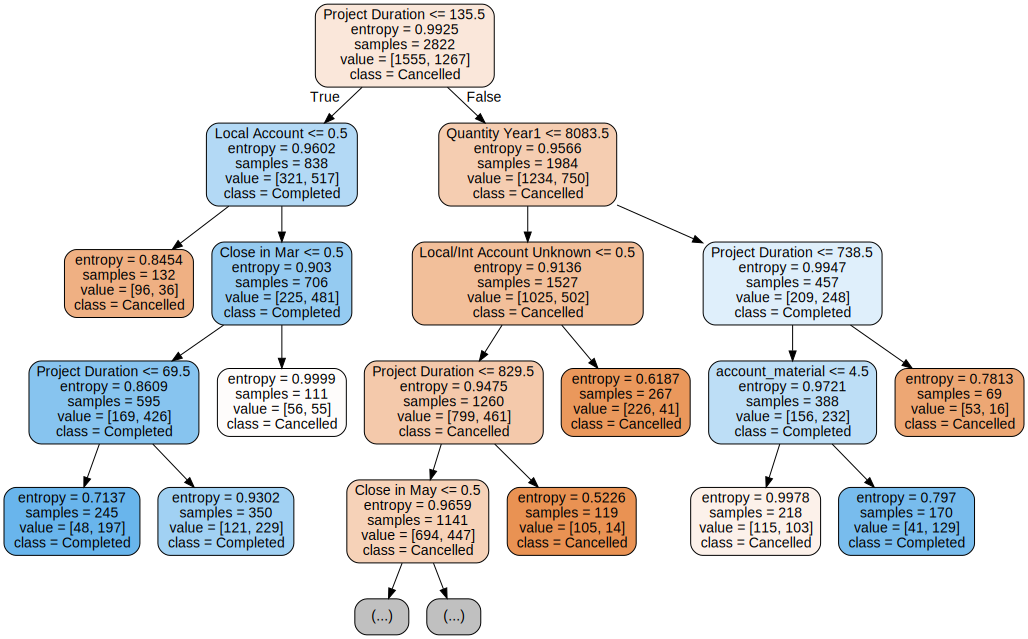

In [118]:
dot_data = export_graphviz(clf_AIL, out_file =None ,max_depth = 4, feature_names = features__AIL.columns, 
                           class_names = clf_AIL.classes_, filled = True,rounded = True)
graph = graphviz.Source(dot_data)
graph

In [119]:
#graph.render('graph_AIL_23/11.pdf', view=True)  

In [ ]:
# Randome Forest Model

rfc_params = {'max_depth': [5,8,10],
            'min_samples_split': [7,10,11],
              'n_estimators': [200, 500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'criterion' :['gini', 'entropy']}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 20, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score

In [ ]:
rfc_AIL = RandomForestClassifier()
print (tune_hyperparameters(rfc_AIL, rfc_params, features_AIL, labels_AIL_cor))
best_params, best_score

In [ ]:
rfc_AIL = RandomForestClassifier(criterion = 'entropy', max_features = 'auto', n_estimators = 200, max_depth = 10, min_samples_split = 7)
rfc_AIL.fit(features_AIL, labels_AIL_cor)
rfc_cv_scores = cross_val_score(rfc_AIL, features_AIL,labels_AIL_cor,cv= 50)
rfc_cv_scores.mean()

In [120]:

# Adaboost Model

ADA_params_AIL= {'base_estimator__max_depth': [1,2,3],
             'n_estimators':[5,10,20],
                 'base_estimator__min_samples_leaf':[50,60,70],
                 'learning_rate':[0.2, 0.3,0.4]}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 20, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score

DTC = DecisionTreeClassifier()
ABC = AdaBoostClassifier(base_estimator = DTC)

print(tune_hyperparameters(ABC, params = ADA_params_AIL , feat = features_AIL, lab = labels_AIL))
dt_best_params, dt_best_score = best_params, best_score

In [ ]:
DTC = DecisionTreeClassifier(min_samples_leaf = 50,max_depth = 3 )
clf_AIL = AdaBoostClassifier(base_estimator = DTC, learning_rate = 0.2, n_estimators = 10)
clf_AIL.fit(features_AIL, labels_AIL)
clf_cv_scores = cross_val_score(clf_AIL, features_AIL,labels_AIL,cv= 100)
clf_cv_scores.mean()

In [121]:
#DTC = DecisionTreeClassifier(min_samples_leaf = 50,max_depth = 3)
#ABC = AdaBoostClassifier(base_estimator = DTC, learning_rate = 0.2, n_estimators = 10)

#grid_search_ABC_AIL = GridSearchCV(ABC, param_grid=ADA_params_AIL,cv = 10, scoring = 'accuracy')
#grid_search_ABC_AIL.fit(features_AIL, labels_AIL)
#print(grid_search_ABC_AIL.fit(features_AIL, labels_AIL))

#clf_cv_scores = cross_val_score(grid_search_ABC_AIL, features_AIL,labels_AIL,cv= 10)
#print (clf_cv_scores.mean())

GridSearchCV(cv=10, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 2], 'base_estimator__criterion': ['gini', 'entropy'], 'base_estimator__max_depth': [4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)
0.619034419143


In [179]:
#DTC = DecisionTreeClassifier(min_samples_leaf = 50,max_depth = 3 )
#clf_AIL = AdaBoostClassifier(base_estimator = DTC, learning_rate = 0.5, n_estimators = 50)
#clf_AIL.fit(features_AIL, labels_AIL)
#clf_cv_scores = cross_val_score(clf_AIL, features_AIL,labels_AIL,cv= 500)
#clf_cv_scores.mean()

AIL_prediction = clf_AIL.predict(features_AIL_act)

In [180]:
AIL_prediction = pd.DataFrame(AIL_prediction)
AIL_2019 = df_AIL.loc[(df_AIL['Project Status'].isin(['Active']))]
AIL_2019 = AIL_2019.reset_index()
AIL_2019 = pd.concat([AIL_2019,AIL_prediction],axis =1)

#### AIC model

In [140]:
status = df_AIC['Project Status Cor']
float(status[status == 'Cancelled'].shape[0]) / float(status.shape[0])

0.5768402927249247

Insert parameter for AIC

In [ ]:
# Decision Tree

#### Tune parameter
dt_params = {'max_depth': [5,8,10],
            'min_samples_split': [7,10,11]}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 100, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score

In [141]:
dt_AIC = DecisionTreeClassifier()
tune_hyperparameters(dt_AIC, params = dt_params, feat = features_AIC, lab = labels_AIC)

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'max_depth': 6, 'min_samples_split': 180}, 77.36)

In [142]:
clf_AIC = DecisionTreeClassifier(criterion = 'entropy',splitter = 'best', max_depth = 4, min_samples_split = 50)
clf_AIC.fit(features_AIC, labels_AIC)
clf_cv_scores = cross_val_score(clf_AIC, features_AIC,labels_AIC,cv= 100)
clf_cv_scores.mean()

0.7059649122807017

In [143]:
importance_dt = sorted(list(zip(features__AIC.columns, clf_AIC.feature_importances_)), key=lambda x: x[1], reverse = True)
importance_dt

[('G1', 0.26850686258453105),
 ('Local Account', 0.17896211927580719),
 ('Project Duration', 0.16349434440787466),
 ('Reference unknown', 0.15193266035454708),
 ('Existing Customer', 0.08646044479642324),
 ('Working seniority ', 0.0651061020668442),
 ('Chong Qing', 0.031874640279991616),
 ('Indirect Channel', 0.02814331703580503),
 ('Past Account Projects', 0.025519509198175982),
 ('International Account', 0.0),
 ('Local/Int Account Unknown', 0.0),
 ('AI Application L1 unknown', 0.0),
 ('AIC Assembly', 0.0),
 ('AIC Edgebanding', 0.0),
 ('AIC Engineered Wood', 0.0),
 ('AIC Lamination', 0.0),
 ('AIC Profile Wrapping', 0.0),
 ('AIS Shoe', 0.0),
 ('Bags & Pouches', 0.0),
 ('Diapers', 0.0),
 ('End of line', 0.0),
 ('Envelopes', 0.0),
 ('Femcare', 0.0),
 ('Fiber and Fabric', 0.0),
 ('Folding  boxes', 0.0),
 ('Graphic Industry', 0.0),
 ('Laminating', 0.0),
 ('Others', 0.0),
 ('Self adhesive labels', 0.0),
 ('3rd level not defined', 0.0),
 ('AI Platform unknown', 0.0),
 ('AIC ONLY: Hotmelt Non

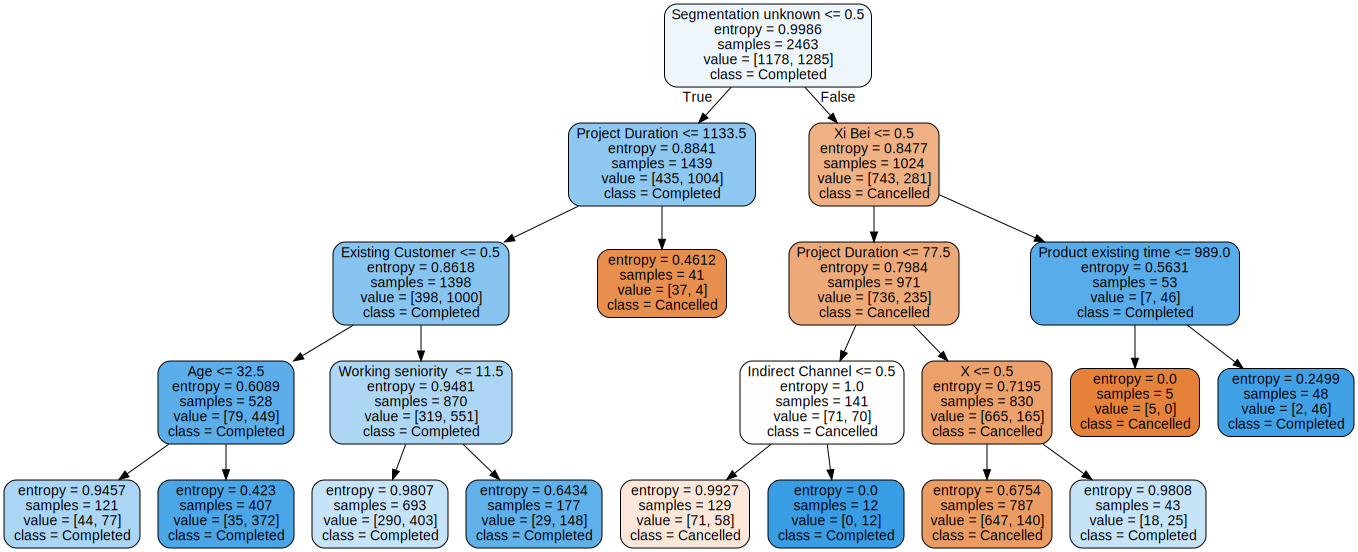

In [505]:
dot_data = export_graphviz(clf_AIC, out_file =None ,max_depth = 4, feature_names = features__AIC.columns, 
                           class_names = clf_AIC.classes_, filled = True,rounded = True)
graph = graphviz.Source(dot_data)
graph

In [126]:
#graph.render('graph_AIC_23/11.pdf', view=True)  

In [ ]:
# Random Forest

rfc_params = {'max_depth': [5,8,10],
            'min_samples_split': [7,10,11],
              'n_estimators': [200, 500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'criterion' :['gini', 'entropy']}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 20, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score


In [ ]:
rfc_AIC = RandomForestClassifier()
print (tune_hyperparameters(rfc_AIC, rfc_params, features_AIC, labels_AIC_cor))
best_params, best_score

In [ ]:
rfc_AIC = RandomForestClassifier(criterion = 'entropy', max_features = 'auto', n_estimators = 200, max_depth = 10, min_samples_split = 7)
rfc_AIC.fit(features_AIC, labels_AIC_cor)
rfc_cv_scores = cross_val_score(rfc_AIC, features_AIC,labels_AIC_cor,cv= 50)
rfc_cv_scores.mean()

In [127]:
# Adaboost

ADA_params_AIC= {'base_estimator__max_depth': [1,2,3],
             'n_estimators':[5,10,20],
                 'base_estimator__min_samples_leaf':[50,60,70],
                 'learning_rate':[0.2, 0.3,0.4]}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 20, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score

DTC = DecisionTreeClassifier()
ABC = AdaBoostClassifier(base_estimator = DTC)

print(tune_hyperparameters(ABC, params = ADA_params_AIC , feat = features_AIC, lab = labels_AIC))
dt_best_params, dt_best_score = best_params, best_score

In [ ]:
DTC = DecisionTreeClassifier(min_samples_leaf = 50,max_depth = 3)
clf_AIC = AdaBoostClassifier(base_estimator = DTC, learning_rate = 0.2, n_estimators = 10)
clf_AIC.fit(features_AIC, labels_AIC)
clf_cv_scores = cross_val_score(clf_AIC, features_AIC,labels_AIC,cv= 100)
clf_cv_scores.mean()

In [128]:
#DTC = DecisionTreeClassifier(min_samples_leaf = 50,max_depth = 3)
#ABC = AdaBoostClassifier(base_estimator = DTC, learning_rate = 0.2, n_estimators = 10)

#grid_search_ABC_AIC = GridSearchCV(ABC, param_grid=ADA_params_AIC,cv = 10, scoring = 'accuracy')
#grid_search_ABC_AIC.fit(features_AIC, labels_AIC)
#print(grid_search_ABC_AIC.fit(features_AIC, labels_AIC))

#clf_cv_scores = cross_val_score(grid_search_ABC_AIC, features_AIC,labels_AIC,cv= 10)
#print (clf_cv_scores.mean())

GridSearchCV(cv=10, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 2], 'base_estimator__criterion': ['gini', 'entropy'], 'base_estimator__max_depth': [4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)
0.703004884689


In [129]:
status = df_AIC['Project Status Cor']
float(status[status == 'Cancelled'].shape[0]) / float(status.shape[0])

0.49575703439035285

In [181]:
#DTC = DecisionTreeClassifier(min_samples_leaf = 50,max_depth = 3 )
#clf_AIC = AdaBoostClassifier(base_estimator = DTC, learning_rate = 0.5, n_estimators = 50)
#clf_AIC.fit(features_AIC, labels_AIC)
#clf_cv_scores = cross_val_score(clf_AIC, features_AIC,labels_AIC,cv= 500)
#clf_cv_scores.mean()

AIC_prediction = clf_AIC.predict(features_AIC_act)

In [182]:
AIC_prediction = pd.DataFrame(AIC_prediction)
AIC_2019 = df_AIC.loc[(df_AIC['Project Status'].isin(['Active']))]
AIC_2019 = AIC_2019.reset_index()
AIC_2019 = pd.concat([AIC_2019,AIC_prediction],axis =1)

#### AIN model

Insert parameter for AIN

In [355]:
# Decision Tree

#### Tune parameter
dt_params = {'max_depth': [5,6,10],
            'min_samples_split': [30,50,70,90]}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 100, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score

In [356]:
dt_AIN = DecisionTreeClassifier()
tune_hyperparameters(dt_AIN, params = dt_params, feat = features_AIN, lab = labels_AIN)

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'max_depth': 6, 'min_samples_split': 70}, 74.1)

In [354]:
clf_AIN = DecisionTreeClassifier(criterion = 'entropy',splitter = 'best', max_depth = 6, min_samples_split = 70)
clf_AIN.fit(features_AIN, labels_AIN)
clf_cv_scores = cross_val_score(clf_AIN, features_AIN,labels_AIN,cv= 100)
clf_cv_scores.mean()

0.7315299736495388

In [509]:
importance_dt = sorted(list(zip(features__AIN.columns, clf_AIN.feature_importances_)), key=lambda x: x[1], reverse = True)
importance_dt

[(u'No link to AI KSI Master Projects', 0.31850236991307146),
 (u'Sales Annualized', 0.15329852803688643),
 ('Project Duration', 0.10238157509553666),
 ('Segmentation unknown', 0.056265443482108338),
 ('Product existing time', 0.05516813925996563),
 (u'Sales Year1', 0.041276545969510414),
 ('Unit Price Euro', 0.036016698281801367),
 (u'Master Degree', 0.02942548802672355),
 ('An Hui', 0.028589027345621715),
 ('education background unknown', 0.027727965159224696),
 (u'YES, in past', 0.027147422811115478),
 (u'Systematical Vocational training of min. 2 years', 0.027086264633426761),
 (u'Product / Process Upgrade', 0.023185527929418259),
 ('account_past_size', 0.023034608160762634),
 (u'Bachelor Degree', 0.019054552224136857),
 ('Shan Dong', 0.018023973327410684),
 (u'Styrenics', 0.013815870343279081),
 ('International Account', 0.0),
 ('Local Account', 0.0),
 ('Local/Int Account Unknown', 0.0),
 ('AI Application L1 unknown', 0.0),
 (u'AIC Assembly', 0.0),
 (u'AIC Edgebanding', 0.0),
 (u'

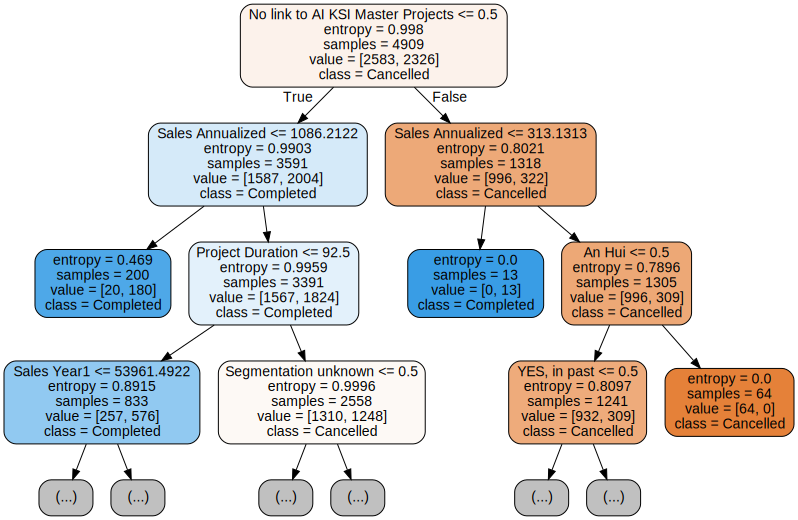

In [510]:
dot_data = export_graphviz(clf_AIN, out_file =None ,max_depth = 3, feature_names = features__AIN.columns, class_names = clf_AIN.classes_,
                           filled = True,rounded = True)
graph = graphviz.Source(dot_data)
graph

In [134]:
#graph.render('graph_AIN_23/11.pdf', view=True)  

In [ ]:
# Random Forest

rfc_params = {'max_depth': [5,8,10],
            'min_samples_split': [7,10,11],
              'n_estimators': [200, 500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'criterion' :['gini', 'entropy']}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 20, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score

In [ ]:
rfc_AIN = RandomForestClassifier()
print (tune_hyperparameters(rfc_AIN, rfc_params, features_AIN, labels_AIN_cor))
best_params, best_score

In [ ]:
rfc_AIN = RandomForestClassifier(criterion = 'entropy', max_features = 'auto', n_estimators = 200, max_depth = 10, min_samples_split = 7)
rfc_AIN.fit(features_AIN, labels_AIN_cor)
rfc_cv_scores = cross_val_score(rfc_AIN, features_AIN,labels_AIN_cor,cv= 50)
rfc_cv_scores.mean()

In [135]:
# Adaboost

ADA_params_AIN= {'base_estimator__max_depth': [1,2,3],
             'n_estimators':[5,10,20],
                 'base_estimator__min_samples_leaf':[50,60,70],
                 'learning_rate':[0.2, 0.3,0.4]}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 20, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score

DTC = DecisionTreeClassifier()
ABC = AdaBoostClassifier(base_estimator = DTC)

print(tune_hyperparameters(ABC, params = ADA_params_AIN , feat = features_AIN, lab = labels_AIN))
dt_best_params, dt_best_score = best_params, best_score

In [ ]:
DTC = DecisionTreeClassifier(min_samples_leaf = 50,max_depth = 3)
clf_AIN = AdaBoostClassifier(base_estimator = DTC, learning_rate = 0.2, n_estimators = 10)
clf_AIN.fit(features_AIN, labels_AIN)
clf_cv_scores = cross_val_score(clf_AIN, features_AIN,labels_AIN,cv= 100)
clf_cv_scores.mean()

In [136]:
#DTC = DecisionTreeClassifier()
#ABC = AdaBoostClassifier(base_estimator = DTC)
#grid_search_ABC_AIN = GridSearchCV(ABC, param_grid=ADA_params_AIN,cv = 10, scoring = 'accuracy')
#grid_search_ABC_AIN.fit(features_AIN, labels_AIN)
#print(grid_search_ABC_AIN.fit(features_AIN, labels_AIN))

#clf_cv_scores = cross_val_score(grid_search_ABC_AIN, features_AIN,labels_AIN,cv= 10)
#print (clf_cv_scores.mean())

GridSearchCV(cv=10, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 2], 'base_estimator__criterion': ['gini', 'entropy'], 'base_estimator__max_depth': [4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)
0.588919656627


In [137]:
status = df_AIN['Project Status Cor']
float(status[status == 'Cancelled'].shape[0]) / float(status.shape[0])

0.5116564417177915

In [183]:
#DTC = DecisionTreeClassifier(min_samples_leaf = 50,max_depth = 3 )
#clf_AIN = AdaBoostClassifier(base_estimator = DTC, learning_rate = 0.5, n_estimators = 50)
#clf_AIN.fit(features_AIN, labels_AIN)
#clf_cv_scores = cross_val_score(clf_AIN, features_AIN,labels_AIN,cv= 500)
#clf_cv_scores.mean()

AIN_prediction = clf_AIN.predict(features_AIN_act)

In [184]:
AIN_prediction = pd.DataFrame(AIN_prediction)
AIN_2019 = df_AIN.loc[(df_AIN['Project Status'].isin(['Active']))]
AIN_2019 = AIN_2019.reset_index()
AIN_2019 = pd.concat([AIN_2019,AIN_prediction],axis =1)

#### AIP model

Insert parameter for AIP

In [363]:
#### Tune parameter
dt_params = {'max_depth': [6,7,8,9],
            'min_samples_split': [7,10,20,50,180]}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 100, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score

In [364]:
dt_AIP = DecisionTreeClassifier()
tune_hyperparameters(dt_AIP, params = dt_params, feat = features_AIP, lab = labels_AIP)

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'max_depth': 7, 'min_samples_split': 7}, 72.49)

In [365]:
clf_AIP = DecisionTreeClassifier(criterion = 'entropy',splitter = 'best', max_depth = 7, min_samples_split = 7)
clf_AIP.fit(features_AIP, labels_AIP)
clf_cv_scores = cross_val_score(clf_AIP, features_AIP, labels_AIP,cv= 100)
clf_cv_scores.mean()

0.7103405572755419

In [513]:
importance_dt = sorted(list(zip(features__AIP.columns, clf_AIP.feature_importances_)), key=lambda x: x[1], reverse = True)
importance_dt

[('Project Duration', 0.43114789219983179),
 ('Segmentation unknown', 0.23142420185468685),
 ('New Customer', 0.080861705992997648),
 ('Local Account', 0.069118618441868535),
 ('Project with KSI Link', 0.057862060792744446),
 ('account_material', 0.054258402204709816),
 (u'Age', 0.032743587337731098),
 ('Close in Apr', 0.026690502511133064),
 (u'WB Acrylic', 0.015893028664296732),
 ('International Account', 0.0),
 ('Local/Int Account Unknown', 0.0),
 ('AI Application L1 unknown', 0.0),
 (u'AIC Assembly', 0.0),
 (u'AIC Edgebanding', 0.0),
 (u'AIC Lamination', 0.0),
 (u'AIC Profile Wrapping', 0.0),
 (u'AIE emulsion', 0.0),
 (u'AIS Shoe', 0.0),
 (u'Bags & Pouches', 0.0),
 (u'Cigarette Packaging', 0.0),
 (u'Cigarettes', 0.0),
 (u'Corrugated boxes', 0.0),
 (u'Diapers', 0.0),
 (u'End of line', 0.0),
 (u'Envelopes', 0.0),
 (u'Femcare', 0.0),
 (u'Fiber Glass', 0.0),
 (u'Fiber and Fabric', 0.0),
 (u'Flexible Packaging', 0.0),
 (u'Folding  boxes', 0.0),
 (u'Graphic Industry', 0.0),
 (u'Labeling'

In [514]:
status = df_AIP['Project Status Cor']
float(status[status == 'Cancelled'].shape[0]) / float(status.shape[0])

0.5002263467632413

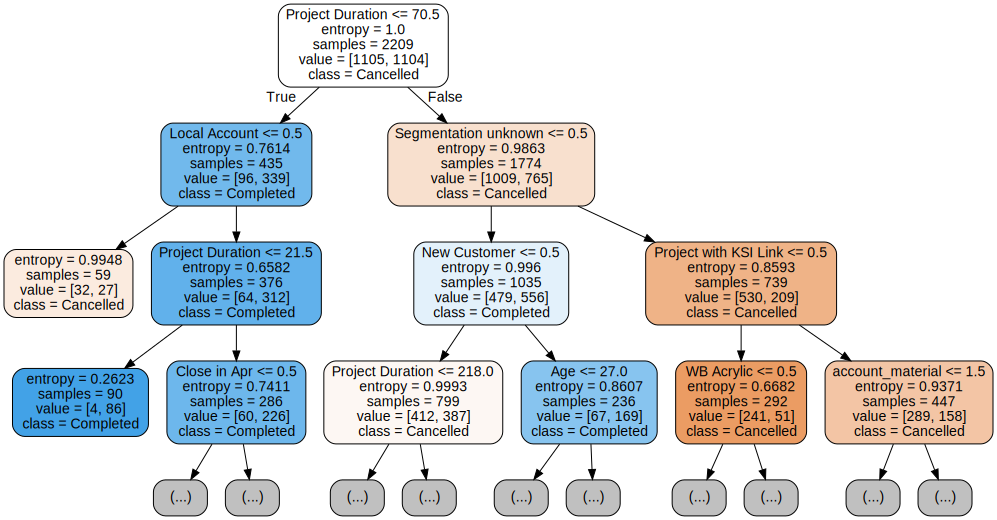

In [515]:
dot_data = export_graphviz(clf_AIP, out_file =None ,max_depth = 3, feature_names = features__AIP.columns, class_names = clf_AIP.classes_,
                           filled = True,rounded = True)
graph = graphviz.Source(dot_data)
graph

In [143]:
#graph.render('graph_AIP_23/11.pdf', view=True)  

In [ ]:
# Random Forest

rfc_params = {'max_depth': [5,8,10],
            'min_samples_split': [7,10,11],
              'n_estimators': [200, 500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'criterion' :['gini', 'entropy']}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 20, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score

In [ ]:
rfc_AIP = RandomForestClassifier()
print (tune_hyperparameters(rfc_AIP, rfc_params, features_AIP, labels_AIP_cor))
best_params, best_score

In [ ]:
rfc_AIP = RandomForestClassifier(criterion = 'entropy', max_features = 'auto', n_estimators = 200, max_depth = 10, min_samples_split = 7)
rfc_AIP.fit(features_AIP, labels_AIP_cor)
rfc_cv_scores = cross_val_score(rfc_AIP, features_AIP,labels_AIP_cor,cv= 50)
rfc_cv_scores.mean()

In [144]:
# Adaboost

ADA_params_AIP= {'base_estimator__max_depth': [1,2,3],
             'n_estimators':[5,10,20],
                 'base_estimator__min_samples_leaf':[50,60,70],
                 'learning_rate':[0.2, 0.3,0.4]}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 20, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score

DTC = DecisionTreeClassifier()
ABC = AdaBoostClassifier(base_estimator = DTC)

print(tune_hyperparameters(ABC, params = ADA_params_AIP , feat = features_AIP, lab = labels_AIP))
dt_best_params, dt_best_score = best_params, best_score

In [ ]:
DTC = DecisionTreeClassifier(min_samples_leaf = 50,max_depth = 3)
clf_AIP = AdaBoostClassifier(base_estimator = DTC, learning_rate = 0.2, n_estimators = 10)
clf_AIP.fit(features_AIP, labels_AIP)
clf_cv_scores = cross_val_score(clf_AIP, features_AIP,labels_AIP,cv= 100)
clf_cv_scores.mean()

In [145]:
#DTC = DecisionTreeClassifier()
#ABC = AdaBoostClassifier(base_estimator = DTC)
#grid_search_ABC_AIP = GridSearchCV(ABC, param_grid=ADA_params_AIP,cv = 10, scoring = 'accuracy')
#grid_search_ABC_AIP.fit(features_AIP, labels_AIP)
#print(grid_search_ABC_AIP.fit(features_AIP, labels_AIP))

#clf_cv_scores = cross_val_score(grid_search_ABC_AIP, features_AIP,labels_AIP,cv= 10)
#print (clf_cv_scores.mean())

GridSearchCV(cv=10, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 2], 'base_estimator__criterion': ['gini', 'entropy'], 'base_estimator__max_depth': [4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)
0.64737576286


In [185]:
#DTC = DecisionTreeClassifier(min_samples_leaf = 50,max_depth = 3 )
#clf_AIP = AdaBoostClassifier(base_estimator = DTC, learning_rate = 0.5, n_estimators = 50)
#clf_AIP.fit(features_AIP, labels_AIP)
#clf_cv_scores = cross_val_score(clf_AIP, features_AIP,labels_AIP,cv= 500)
#clf_cv_scores.mean()

AIP_prediction = clf_AIP.predict(features_AIP_act)

In [186]:
AIP_prediction = pd.DataFrame(AIP_prediction)
AIP_2019 = df_AIP.loc[(df_AIP['Project Status'].isin(['Active']))]
AIP_2019 = AIP_2019.reset_index()
AIP_2019 = pd.concat([AIP_2019,AIP_prediction],axis =1)

#### AIH model

Insert parameter for AIH

In [378]:
#### Tune parameter
dt_params = {'max_depth': [5,7,8],
            'min_samples_split': [7,50,70,90,100]}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 100, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score

In [379]:
dt_AIH = DecisionTreeClassifier()
tune_hyperparameters(dt_AIH, params = dt_params, feat = features_AIH, lab = labels_AIH)

C:\Users\zhongx2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


({'max_depth': 5, 'min_samples_split': 70}, 75.57)

In [380]:
clf_AIH = DecisionTreeClassifier(criterion = 'entropy',splitter = 'best', max_depth = 5, min_samples_split = 70)
clf_AIH.fit(features_AIH, labels_AIH)
clf_cv_scores = cross_val_score(clf_AIH, features_AIH, labels_AIH,cv= 100)
clf_cv_scores.mean()

0.7296666666666667

In [ ]:
# Random Forest

rfc_params = {'max_depth': [5,8,10],
            'min_samples_split': [7,10,11],
              'n_estimators': [200, 500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'criterion' :['gini', 'entropy']}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 20, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score

In [ ]:
rfc_AIH = RandomForestClassifier()
print (tune_hyperparameters(rfc_AIH, rfc_params, features_AIH, labels_AIH_cor))
best_params, best_score

In [ ]:
rfc_AIH = RandomForestClassifier(criterion = 'entropy', max_features = 'auto', n_estimators = 200, max_depth = 10, min_samples_split = 7)
rfc_AIH.fit(features_AIH, labels_AIH_cor)
rfc_cv_scores = cross_val_score(rfc_AIH, features_AIH,labels_AIH_cor,cv= 50)
rfc_cv_scores.mean()

In [188]:
# Adaboost

ADA_params_AIH= {'base_estimator__max_depth': [1,2,3],
             'n_estimators':[5,10,20],
                 'base_estimator__min_samples_leaf':[50,60,70],
                 'learning_rate':[0.2, 0.3,0.4]}

def tune_hyperparameters(model, params, feat, lab):
    from sklearn.model_selection import GridSearchCV
    global best_params, best_score
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 20, scoring = 'accuracy', n_jobs = -1)
    # Fit using grid search.
    grid.fit(feat, lab)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    return best_params, best_score

DTC = DecisionTreeClassifier()
ABC = AdaBoostClassifier(base_estimator = DTC)

print(tune_hyperparameters(ABC, params = ADA_params_AIH , feat = features_AIH, lab = labels_AIH))
dt_best_params, dt_best_score = best_params, best_score

In [ ]:
DTC = DecisionTreeClassifier(min_samples_leaf = 50,max_depth = 3)
clf_AIH = AdaBoostClassifier(base_estimator = DTC, learning_rate = 0.2, n_estimators = 10)
clf_AIH.fit(features_AIH, labels_AIH)
clf_cv_scores = cross_val_score(clf_AIH, features_AIH,labels_AIH,cv= 100)
clf_cv_scores.mean()

In [189]:
AIH_prediction = pd.DataFrame(AIH_prediction)
AIH_2019 = df_AIH.loc[(df_AIH['Project Status'].isin(['Active']))]
AIH_2019 = AIH_2019.reset_index()
AIH_2019 = pd.concat([AIH_2019,AIH_prediction],axis =1)

#### Concat all SU predictions together

In [199]:
frame = [AIF_2019, AIS_2019, AIC_2019, AIP_2019, AIN_2019, AIH_2019, AIL_2019]

Predicted = pd.concat(frame, axis = 0)

In [200]:
Predicted.head()

index  Project ID AI Application L1  AI Application L2  \
0   3532  0004269326       End of line  Carton clos/Trays   
1   3899  0004278433       End of line       Case Sealing   
2   4610  0004295218       End of line       Case Sealing   
3   5600  0004326357       End of line       Case Sealing   
4   7028  0004375430       End of line            Pouches   

                     AI Platform Primary Brand   Secondary Brand  \
0  Hotmelt Non-Reactive, Non PSA    Technomelt   Technomelt-None   
1  Hotmelt Non-Reactive, Non PSA    Technomelt   Technomelt-None   
2  Hotmelt Non-Reactive, Non PSA    Technomelt  Technomelt-Supra   
3  Hotmelt Non-Reactive, Non PSA    Technomelt   Technomelt-None   
4                    Hotmelt PSA    Technomelt   Technomelt-None   

                                     eNACE Code (L6)            IB Product  \
0                                MISC. FOOD PRODUCTS  TECHNOMELT SUPRA 801   
1     manufacture of other products (chemicals etc.)  TECHNOMELT SUPRA 181   
2     manufacture of other products (chemicals etc.)  TECHNOMELT SUPRA 165   
3  Manufact. of non-alcoholic beverages (soft dri...   TECHNOMELT SUPRA 81   
4                                MISC. FOOD PRODUCTS              134-2734   

  IB Product Key            Material Number Material Number Key  Product Type  \
0         112587  TECHNOMELT SUPRA 801 25KG          0002053903  Existing IDH   
1         107575  TECHNOMELT SUPRA 181 25KG          0001909432  Existing IDH   
2         107175  TECHNOMELT SUPRA 165 25KG          0001812426  Existing IDH   
3         114017   TECHNOMELT SUPRA 81 25KG          0002257440  Existing IDH   
4         101969   TECHNOMELT 134-2734 20KG          0001237324  Existing IDH   

               Reference Description Reference ID  Reference Type  \
0             AIF Next Generation HM   0004401442  Master Project   
1            AIF Alternative Channel   0004401563  Master Project   
2             AIF Next Generation HM   0004401442  Master Project   
3             AIF Next Generation HM   0004401442  Master Project   
4  No link to AI KSI Master Projects   0004321358  Master Project   

  Technology L1  Technology L1 Key Technology L2  Technology L2 Key  \
0      Hotmelts                1.0       Olefins                1.0   
1      Hotmelts                1.0       Olefins                1.0   
2      Hotmelts                1.0           EVA                5.0   
3      Hotmelts                1.0           EVA                5.0   
4      Hotmelts                1.0     Styrenics                2.0   

     Sales Year1  Sales Year1 Weighted  Sales Annualized  \
0   24383.838384          14630.303030      33527.777778   
1   46950.757576          42255.681818      46950.757576   
2  130181.818182          78109.090909     130181.818182   
3   12085.858586          10877.272727      21150.252525   
4   25000.000000          15000.000000      37500.000000   

   Sales Annualized Weighted  Unit Price  Quantity Year1  \
0               20116.666666       24.14            8000   
1               42255.681818       24.79           15000   
2               78109.090909       28.64           36000   
3               19035.227272       23.93            4000   
4               22500.000000       19.80           10000   

   Quantity Year1 Weighted  Quantity Year1CON  Quantity Year1CON Weighted  \
0                   4800.0              320.0                       192.0   
1                  13500.0              600.0                       540.0   
2                  21600.0             1440.0                       864.0   
3                   3600.0              160.0                       144.0   
4                   6000.0              500.0                       300.0   

   Quantity Year1KG  Quantity Year1KG Weighted  Quantity Year2  \
0            8000.0                     4800.0         11000.0   
1           15000.0                    13500.0         15000.0   
2           36000.0                    21600.0